In [164]:
from IPython.core.display import HTML

HTML('<link rel="stylesheet" type="text/css" href="custom.css">')

# Supervised Learning Project — Stroke Prediction

## 1. Project Overview
This project applies supervised machine learning techniques to perform binary classification in order to predict the risk of stroke based on demographic, lifestyle, and health-related features, using a tabular medical dataset.

If was found during EDA that the dataset is highly imbalanced (≈95% non-stroke, 5% stroke), and therefore the analysis emphasizes:
- appropriate evaluation metrics,
- strategies to handle imbalance,
- threshold tuning to favor recall in a medical context,
- comparison of several models under consistent validation conditions.

The workflow proceeds through:
1. Problem definition  
2. Exploratory data analysis  
3. Data preprocessing  
4. Model training and selection  
5. Hyperparameter optimization  
6. Decision threshold tuning  
7. Final evaluation on a held-out test set  
8. Conclusions and interpretation  

---

## 2. Dataset Description
The dataset comes from kaggle: 

### Dataset Citation
Soriano, F. (2021). *Stroke prediction dataset*. Kaggle. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


### License
The dataset is provided on Kaggle under the notice “Data files © Original Authors.”  
No explicit reuse license (e.g., CC BY, MIT) is provided. The dataset is used here strictly for educational purposes.


### How to Cite This Work

If you wish to reference this project, please use the following APA-style citation:

Bicari, J. (2025). *Stroke prediction using supervised machine learning: An exploratory and comparative analysis* [Jupyter Notebook]. GitHub. https://github.com/jobicari/ml-supervisedlearning-stroke-prediction

### Desciption
This dataset is used to predict whether a patient is likely to get stroke based on 11 features, like gender, age, various diseases, and smoking status. Each of the 5110 rows provides relavant information about each patient. The dataset is presented in a single tabular format. No other information was given on the origins of the collected data. It is therefore considered acceptable only for educational purposes, as described by the license.

### Key metrics
- 5110 observations (rows)
- 11 features and 1 target (columns)

### Numerical Features
- **age**
- **average glucose level**
- **BMI**

### Categorical Features

- #### Binary Features
    - **hypertension**
    - **heart disease**

- #### Nominal Features
    - **gender**
    - **residence type**
    - **work type**

- #### Ordinal-ish
    - **smoking status**

### Target Variable
- **stroke** (1 = stroke occurred, 0 = no stroke)

Key characteristics:
- The target is extremely imbalanced.
- Numerical features contain legitimate medical outliers.
- Some categorical levels are rare but not erroneous.
- Some observations had BMI missing values and therefore were dropped.

---

## 3. Project Goals
- Understand the structure and relationships within the data.
- Build several classification models (e.g., Logistic Regression, Random Forest, Gradient Boosting, SVC-RBF).
- Compare models using ROC AUC, precision, recall, F1, and confusion matrices.
- Apply GridSearch cross-validation to tune hyperparameters.
- Use threshold tuning to adjust the recall–precision trade-off according to medical priorities.
- Produce an interpretable final model with supporting visualizations.

---

## 4. Modeling Strategy
- Use **stratified train–test split** to preserve target distribution.
- Scale numerical features for models that require it (SVM, Logistic Regression).
- One-hot encode categorical features for models using distance or linear combination.
- For imbalance, apply:
  - `class_weight="balanced"`  
  - threshold tuning based on ROC curve and F-beta scores.

---

## 5. Evaluation Approach
Primary metric (medical focus):
- **Recall (Sensitivity):** prioritize catching as many true stroke cases as possible.

Secondary metrics:
- **Precision:** avoid excessive false alarms.
- **F1 / Fβ:** balance recall and precision under different weightings.
- **ROC AUC:** model’s ranking ability independent of threshold.
- **Confusion matrix:** practical interpretation of errors.

---

# Helper Functions Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from xgboost import XGBClassifier
import pprint as pp
import json
import io
from IPython.display import Image
%matplotlib inline

## Preprocessing Pipeline

In [3]:
def make_preprocessor(numeric_cols, categorical_cols, scale_numeric=True):
    """
    Builds a preprocessing pipeline with optional scaling.
    """

    transformers = []

    if scale_numeric:
        transformers.append(
            ('num', StandardScaler(), numeric_cols)
        )
    else:
        transformers.append(
            ('num', 'passthrough', numeric_cols)
        )

    transformers.append(
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    )

    preprocessor = ColumnTransformer(transformers)
    return preprocessor

def build_pipeline(preprocessor, clf):
    """
    Creates a modeling pipeline combining preprocessing and model.
    """

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ])

    return pipe


## Basic Model Training Helper

In [72]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a trained model and returns useful metrics
    """

    y_pred = model.predict(X_test)

    # If classifier supports predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # use decision function as a fallback
        y_proba = model.decision_function(X_test)

    # Compute metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    
    metrics = {
        "test_auc": roc_auc_score(y_test, y_proba),
        "confusion_matrix": confusion_matrix(y_test, y_pred, labels=model.classes_),
        "report": classification_report(y_test, y_pred, output_dict=False, zero_division=0),
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

    return metrics
    

## GridSearchCV Wrapper

In [5]:
def run_grid_search(pipe, param_grid, X_train, y_train, scoring='roc_auc', cv=5):
    """
    Runs GridSearchCV on a given pipeline
    """

    grid = GridSearchCV(pipe, param_grid, 
                        scoring=scoring,
                        cv=cv,
                        n_jobs=-1,
                        verbose=1
                       )

    grid.fit(X_train, y_train)

    return grid

## Multi-models Loop

In [6]:
def run_multiple_models(models, grids, preprocessor,
                       X_train, y_train, X_test, y_test, scoring='roc_auc'):
    """
    Runs grid search for multiple models and stores the results.
    """

    results = {}

    for name, clf in models.items():
        print(f"\n===== Training {name} =====\n")

        pipe = build_pipeline(preprocessor, clf)
        param_grid = grids[name]

        grid = run_grid_search(pipe, param_grid, X_train, y_train, scoring=scoring)

        # Best estimator
        best_model = grid.best_estimator_

        # Evaluate
        metrics = evaluate_model(best_model, X_test, y_test)

        results[name] = {
            "best_model": best_model,
            "best_prams": grid.best_params_,
            "cv_best_score": grid.best_score_,
            "test_metrics": metrics,
            "grid": grid
        }
            
        cm = metrics['confusion_matrix']

        display_model_results(name, grid, metrics, cm, best_model)
        

    return results

## Models Librairy

In [7]:
all_models = {
    # ---- Linear Models ----
    "lin_reg": LinearRegression(),
    "log_reg": LogisticRegression(max_iter=500),

    # ---- Decision Trees ----
    "dt_reg": DecisionTreeRegressor(),
    "dt_clf": DecisionTreeClassifier(),

    # ---- Random Forests ----
    "rf_reg": RandomForestRegressor(),
    "rf_clf": RandomForestClassifier(),

    # ---- Boosting -----
    "gb_clf": GradientBoostingClassifier(),
    "ada_clf": AdaBoostClassifier(),
    "xgb_clf": XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist"
    ),

    # ---- Bagging -----
    "bag_clf": BaggingClassifier(estimator=DecisionTreeClassifier()),

    # ---- SVM -----
    "lin_svc": LinearSVC(),
    "svc_poly": SVC(kernel='poly', probability=True),
    "svc_rbf": SVC(kernel='rbf', probability=True),
    "svr": SVR(kernel='rbf')
}


## Parameter Grids

In [74]:
# Basic parameter grids
all_param_grids = {

    # ---- Linear Regression (no params) ----
    "lin_reg": {},

    # ---- Logistic Regression ----
    "log_reg": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- Decision Tree Regressor ----
    "dt_reg": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },

    # ---- Decision Tree Classifier ----
    "dt_clf": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__min_samples_split": [2, 5, 10]
        # TODO:  "clf__min_impurity_decrease": 
    },

    # ---- Random Forest Regressor ----
    "rf_reg": {
        "clf__n_estimators": [10, 100, 500],
        "clf__max_depth": [None, 10, 20, 30],
        "clf__min_samples_leaf": [1, 2, 4],
        #"clf__min_samples_split": [2, 5, 10],
        "clf__class_weight": ["balanced"],
        "clf__max_features": ['sqrt', 'log2']
    },

    # ---- Random Forest Classifier ----
    "rf_clf": {
        "clf__n_estimators": [10, 100, 500],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        #"clf__min_samples_leaf": [1, 2, 4],
        "clf__class_weight": ["balanced"],
        "clf__max_features": ['sqrt', 'log2']
    },

    # ---- Gradient Boosting Classifier ----
    "gb_clf": {
        "clf__n_estimators": [100, 200, 300],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__max_depth": [3, 5],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__min_samples_split": [2, 5]
    },

    # ---- AdaBoost Classifier ----
    "ada_clf": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.5, 1.0, 1.5]
    },
    
    # ---- XGBoost Classifier ----
    "xgb_clf": {
        "clf__n_estimators": [50, 100, 200],
        "clf__max_depth": [2, 3, 4],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    },

    # ---- Bagging Classifier ----
    "bag_clf": {
        "clf__n_estimators": [50, 100, 200],
        "clf__max_samples": [0.5, 0.7, 1.0],
        "clf__max_features": [0.5, 0.7, 1.0],
        "clf__bootstrap": [True],
        "clf__bootstrap_features": [False],
        "clf__oob_score": [True, False]        
    },

    # ---- LinearSVC ----
    "lin_svc": {
        "clf__C": [0.1, 1, 10],
        "clf__loss": ["hinge", "squared_hinge"]
    },

    # ---- SVC (Poly Kernel) ----
    "svc_poly": {
        "clf__C": [0.1, 1, 10],
        "clf__degree": [2,3,4],
        "clf__gamma": ["scale", .01, .1],
        "clf__coef0": [0, 1],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- SVC (RBF Kernel) ----
    "svc_rbf": {
        "clf__C": [0.1, 1, 10, 100],
        "clf__gamma": ["scale",1, .1, .001, .0001],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- SVR ----
    "svr": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", 0.01, 0.1],
        "clf__epsilon": [0.1, 0.2, 0.5]
    }
}

## Visualization Helper Functions

In [9]:
def show_shrunk(fig, width=480):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=300, bbox_inches='tight')
    plt.close(fig)
    display(Image(data=buf.getvalue(), width=width))


def threshold_curve(y_test, y_proba):

    thresholds = np.linspace(0, 1, 200)
    precisions = []
    recalls = []
    f1s = []

    # High-DPI text rendering
    #plt.rcParams["figure.dpi"] = 200

    
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
        recalls.append(recall_score(y_test, y_pred_t))
        f1s.append(f1_score(y_test, y_pred_t))

    fig, ax = plt.subplots(figsize=(8,5), dpi=150)
    
    ax.plot(thresholds, precisions, label="Precision")
    ax.plot(thresholds, recalls, label="Recall")
    ax.plot(thresholds, f1s, label="F1 Score")
    ax.axvline(0.5, color="grey", linestyle="--", label="Default t=0.50")

    box = ax.get_position()

    ax.set_position([
        box.x0 +0,
        box.y0 - 0,
        box.width * 1,
        box.height * 1
    ])
    
    ax.legend(loc="best", fontsize=8)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_title("Precision–Recall–F1 vs Decision Threshold")
    #plt.tight_layout()
    #plt.show()
    show_shrunk(fig, width=600)




def display_model_results(name, grid, metrics, cm, best_model):
    """
    Display model results in a clean 2-column layout.
    Left: text summary
    Right: confusion matrix
    """

    # High-DPI text rendering
    plt.rcParams["figure.dpi"] = 300

    # fig, (ax_text, ax_cm) = plt.subplots(
        # 1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1.1]}
    # )

    fig = plt.figure(figsize=(26,4))
    gs = fig.add_gridspec(1, 2, wspace=0.15, width_ratios=[3,1])
    
    ax_text = fig.add_subplot(gs[0, 0])
    ax_text.axis("off")

    # --------------------------------------------------
    # BEST PARAMS (Grid or direct model params)
    # --------------------------------------------------
    if grid is None:
        # not from grid search → pull params from model
        try:
            raw_params = best_model.get_params()
            params_pretty = json.dumps(raw_params, indent=2)
        except:
            params_pretty = "N/A"
        auc_cv_text = ""   # no CV score available
    else:
        params_pretty = json.dumps(grid.best_params_, indent=2)
        auc_cv_text = f"AUC (CV):   {grid.best_score_:.4f}\n"

    # --------------------------------------------------
    # Text block content
    # --------------------------------------------------
    text = (
        f"============= {name} =============\n\n"
        f"Best Params:\n{params_pretty}\n\n"
        f"{auc_cv_text}"
        f"AUC (Test): {metrics['test_auc']:.4f}\n\n"
        f"Classification Report:\n{metrics['report']}"
    )

    # Render text cleanly
    ax_text.text(
        0.0, 1.0, text,
        fontsize=9,
        va="top",
        ha="left",
        family="monospace",
        transform=ax_text.transAxes
    )

    
    # --------------------------------------------------
    # Confusion Matrix
    # --------------------------------------------------

    ax_cm = fig.add_subplot(gs[0, 1])
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=getattr(best_model, "classes_", ["0", "1"])
    )
    disp.plot(
        ax=ax_cm,
        cmap="Blues",
        colorbar=False,
        values_format="d"
    )

    # Make CM Smaller + Shift left
    box = ax_cm.get_position()
    ax_cm.set_position([
        box.x0 - .37,
        box.y0 + .45,
        box.width * 0.35,
        box.height * 0.35
    ])
    
    ax_cm.set_title(f"Confusion Matrix", fontsize=10)

    #plt.tight_layout()
    plt.show()


## Threshold tuning Helper Function

In [10]:
def find_best_threshold(y_test, y_proba, beta=1):

    thresholds = np.linspace(0, 1, 200)

    # Initialize default values
    best_t = 0.5
    best_score = -1

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        score = fbeta_score(y_test, y_pred_t, beta=beta, zero_division=0)

        if score > best_score:
            best_score = score
            best_t = t
    return best_t, best_score




def eval_at_threshold(y_test, y_proba, threshold=0.5, beta=2):
    """
    Evaluate precision/recall/F1/Fβ at a custom decision threshold.

    Returns a dictionary of metrics: 
        -threshold
        -precision
        -recall
        -f1
        -fbeta
        -confusion matrix
        -test_auc
        -classification report
    """

    # 1. Apply threshold → get binary predictions
    y_pred = (y_proba >= threshold).astype(int)

    # 2. Compute metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    fbeta     = fbeta_score(y_test, y_pred, beta=beta, zero_division=0)


    # 3. Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fbeta": fbeta,
        "confusion_matrix": cm,
        "test_auc": roc_auc_score(y_test, y_proba),
        "report": classification_report(y_test, y_pred, output_dict=False)
    }

# Load Dataset and Perform EDA

In [171]:
filename = "data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#### **Notes**
`id` column looks irrelevant. We can drop it.
`hypertension` and `heat_disease` are classified as numerical columns although they are binary categorical features. I will map them to an object `Yes/No` to help building categorical and numerical features lists later on.

In [173]:
df.drop(columns=['id'], inplace=True)
df['hypertension'] = df['hypertension'].map({1: 'Yes', 0: 'No'})
df['heart_disease'] = df['heart_disease'].map({1: 'Yes', 0: 'No'})
df.head()

gender   age hypertension heart_disease ever_married      work_type  \
0    Male  67.0           No           Yes          Yes        Private   
1  Female  61.0           No            No          Yes  Self-employed   
2    Male  80.0           No           Yes          Yes        Private   
3  Female  49.0           No            No          Yes        Private   
4  Female  79.0          Yes            No          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

In [174]:
df.describe().T

count        mean        std    min     25%     50%  \
age                5110.0   43.226614  22.612647   0.08  25.000  45.000   
avg_glucose_level  5110.0  106.147677  45.283560  55.12  77.245  91.885   
bmi                4909.0   28.893237   7.854067  10.30  23.500  28.100   
stroke             5110.0    0.048728   0.215320   0.00   0.000   0.000   

                      75%     max  
age                 61.00   82.00  
avg_glucose_level  114.09  271.74  
bmi                 33.10   97.60  
stroke               0.00    1.00

In [175]:
print([float(x) for x in df['age'].unique()])

[67.0, 61.0, 80.0, 49.0, 79.0, 81.0, 74.0, 69.0, 59.0, 78.0, 54.0, 50.0, 64.0, 75.0, 60.0, 57.0, 71.0, 52.0, 82.0, 65.0, 58.0, 42.0, 48.0, 72.0, 63.0, 76.0, 39.0, 77.0, 73.0, 56.0, 45.0, 70.0, 66.0, 51.0, 43.0, 68.0, 47.0, 53.0, 38.0, 55.0, 1.32, 46.0, 32.0, 14.0, 3.0, 8.0, 37.0, 40.0, 35.0, 20.0, 44.0, 25.0, 27.0, 23.0, 17.0, 13.0, 4.0, 16.0, 22.0, 30.0, 29.0, 11.0, 21.0, 18.0, 33.0, 24.0, 34.0, 36.0, 0.64, 41.0, 0.88, 5.0, 26.0, 31.0, 7.0, 12.0, 62.0, 2.0, 9.0, 15.0, 28.0, 10.0, 1.8, 0.32, 1.08, 19.0, 6.0, 1.16, 1.0, 1.4, 1.72, 0.24, 1.64, 1.56, 0.72, 1.88, 1.24, 0.8, 0.4, 0.08, 1.48, 0.56, 0.48, 0.16]


### Observation
The minimum age in the dataset appears as a small decimal value, so I inspected the unique age values to understand why. The distribution makes sense: all values below 2 are fractional numbers, while all values above 2 are whole integers. This indicates that ages for infants were recorded in decimal years (e.g., 0.08 ≈ 1 month, 1.32 ≈ 16 months). The data is consistent, and no transformation is needed.

In [176]:
# Explore categorical's unique values
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}'s unique values: {df[col].unique()}")

gender's unique values: ['Male' 'Female' 'Other']
hypertension's unique values: ['No' 'Yes']
heart_disease's unique values: ['Yes' 'No']
ever_married's unique values: ['Yes' 'No']
work_type's unique values: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type's unique values: ['Urban' 'Rural']
smoking_status's unique values: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [177]:
# Look for missing values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [178]:
# Drop observations with missing BMI values
df = df.dropna().copy()
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [179]:
# Prepare features lists
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'stroke']
target_col = ['stroke']
print(f"categorical cols: {categorical_cols}")
print(f"numerical cols: {numerical_cols}")

categorical cols: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical cols: ['age', 'avg_glucose_level', 'bmi']


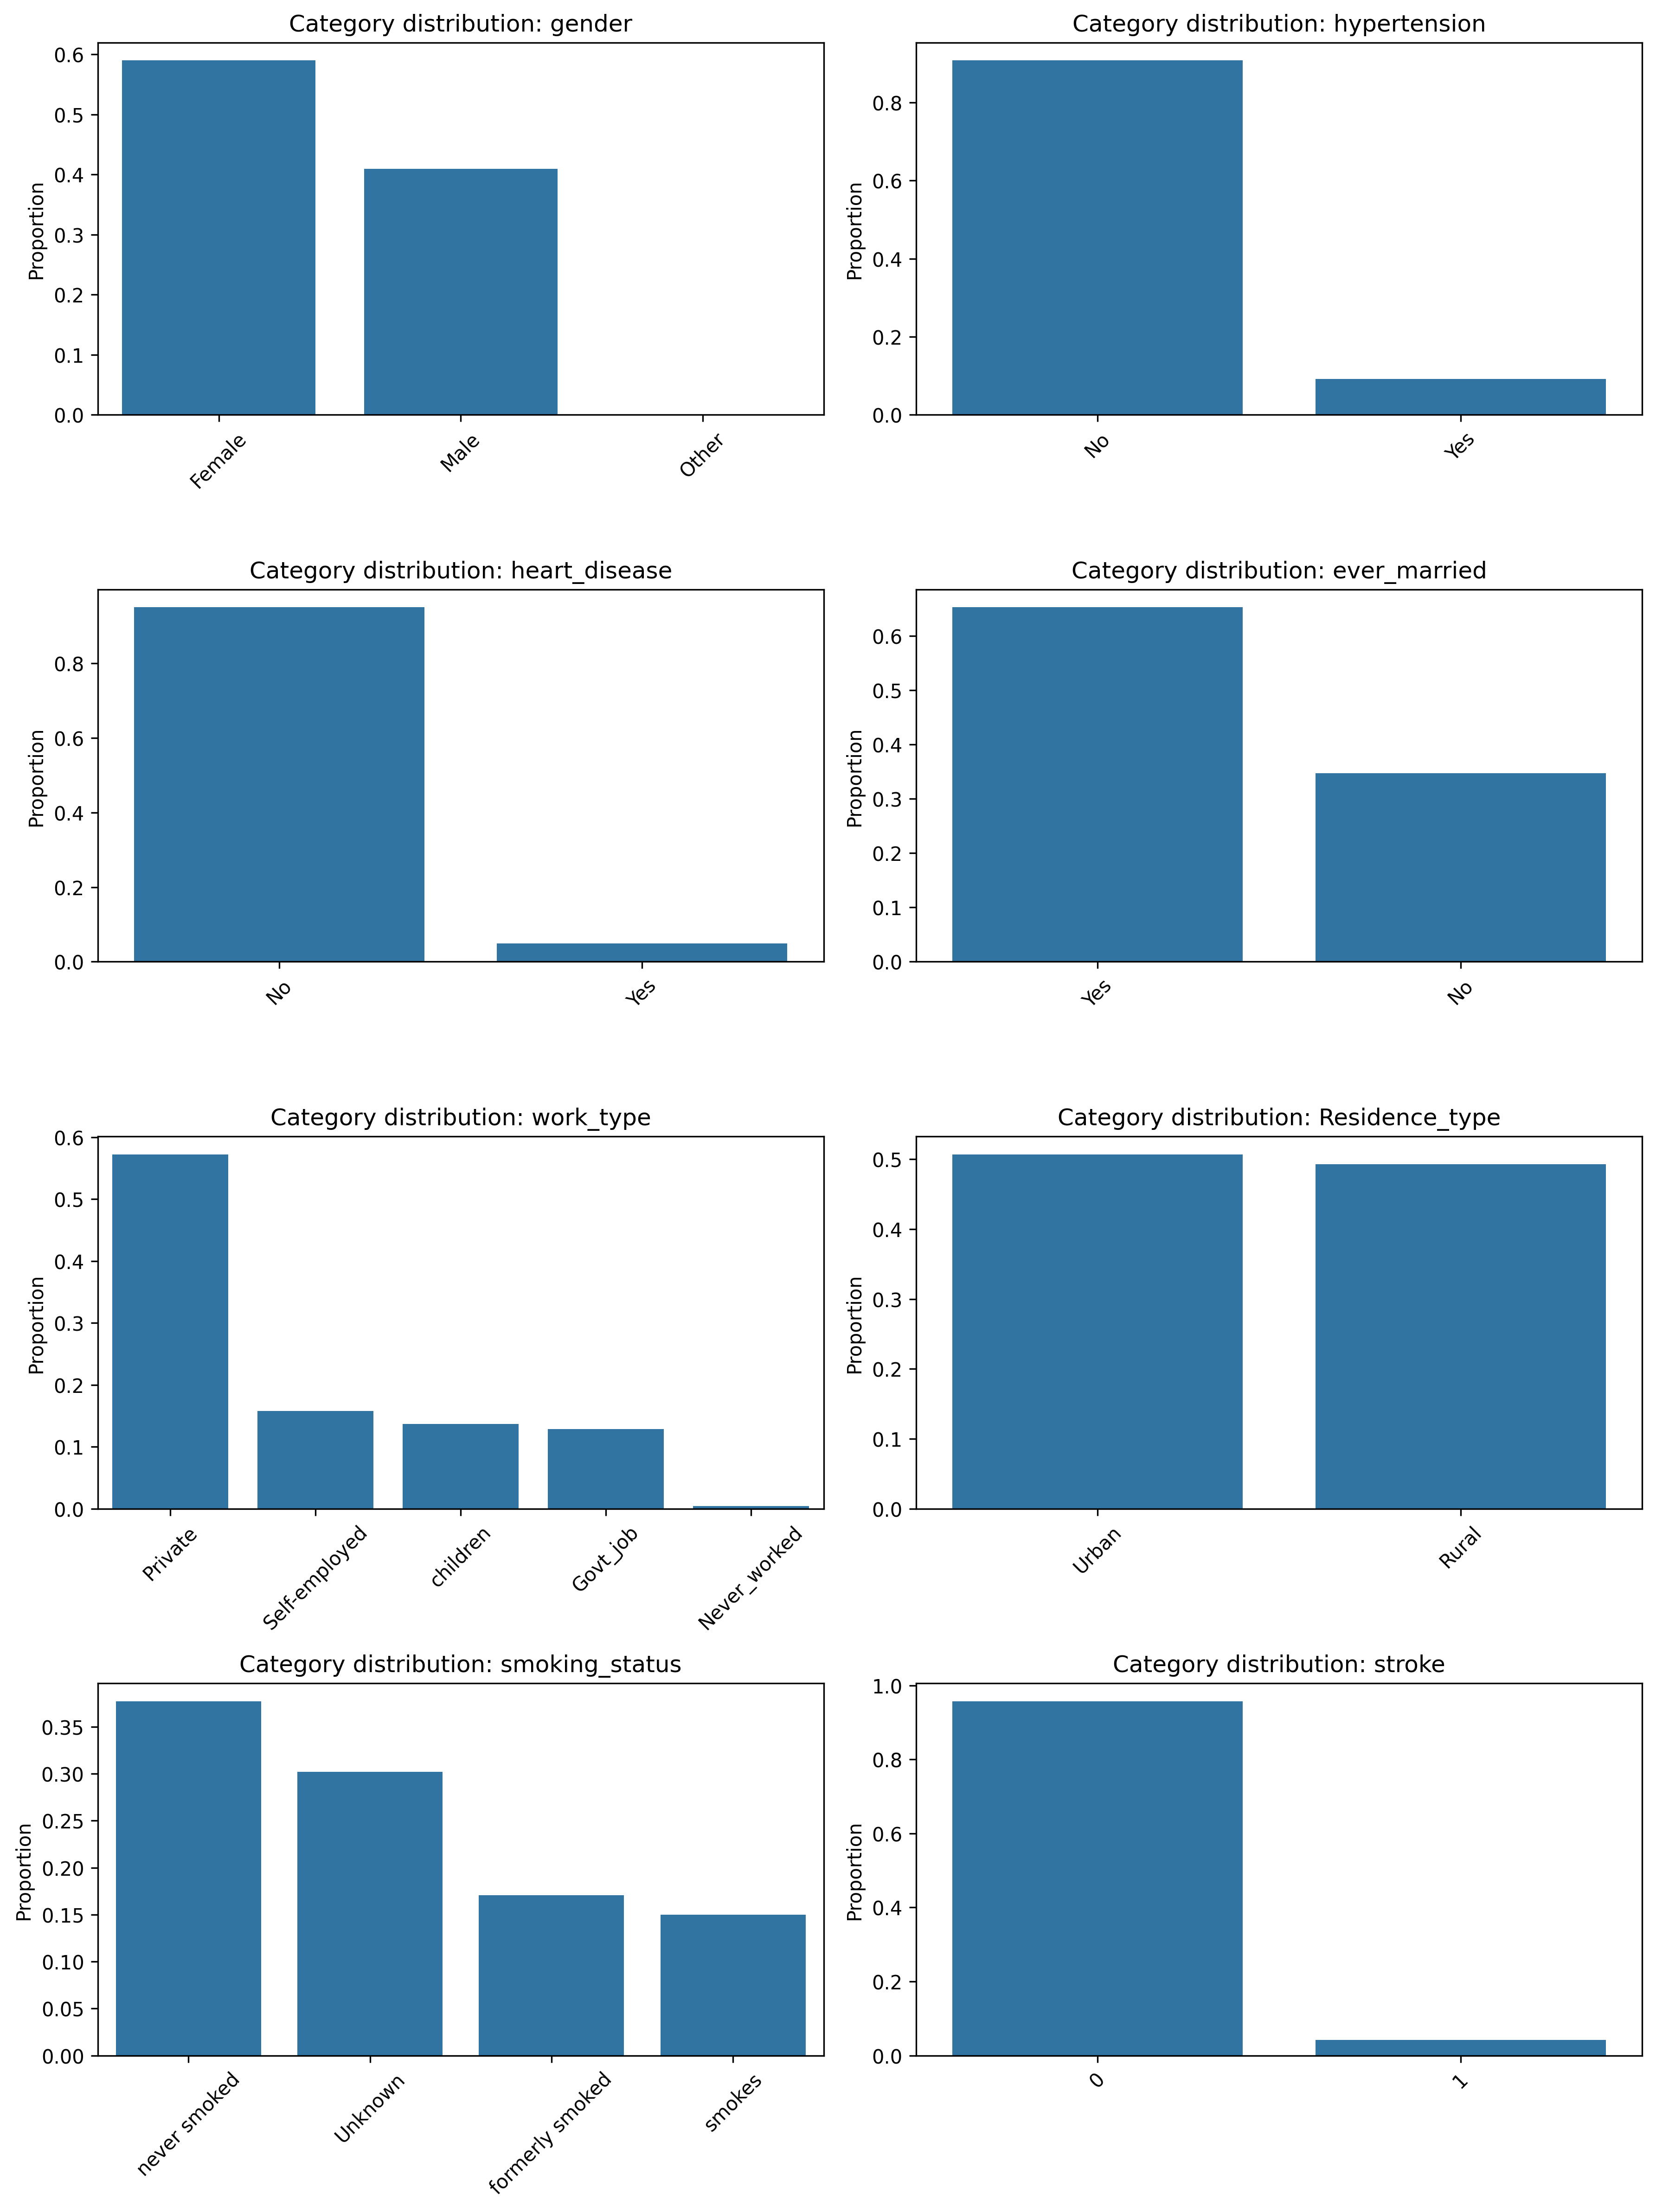

In [180]:
#Inspect categorical features' distribution
n_cols = 2
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()
    
for i, col in enumerate(categorical_cols+target_col):
    ax = axes[i]

    #Compute proportions
    dist = df[col].value_counts(normalize=True).reset_index()
    dist.columns = [col, "proportion"]
    
    sns.barplot(data=dist, x=col, y="proportion", ax=ax)
    
    ax.set_title(f"Category distribution: {col}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)
    
# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
#plt.show()
show_shrunk(fig, width=800)

### Observations

- the dataset is highly imbalanced with a `stroke` prevalence of about 5%
- gender distribution shows an imbalance in the dataset. Approximately 60% are `female` and 40% are `male`. A third category `other` appears in the data but is extremely rare, with so few observations that it is not visually noticeable in the bar blot. This category may need specific handling during preprocessing due to its low frequency.
- `work_type` is heavily imbalanced: `Private` dominates (>50%), while `Self-employed`, `Children`, and `Govt_job` each represent ~ 15%. The `Never_worked` group is extremely rare (~ 1% or less) and barely visible on the plot, so it requires special treatment due to insufficient sample size.
- `hypertenion` and `heart_disease` are highly imbalanced features, with positive rates close to the overall stroke prevalence. This similarity is purely coincidental and reflects low-frequency clinical conditions in the dataset.

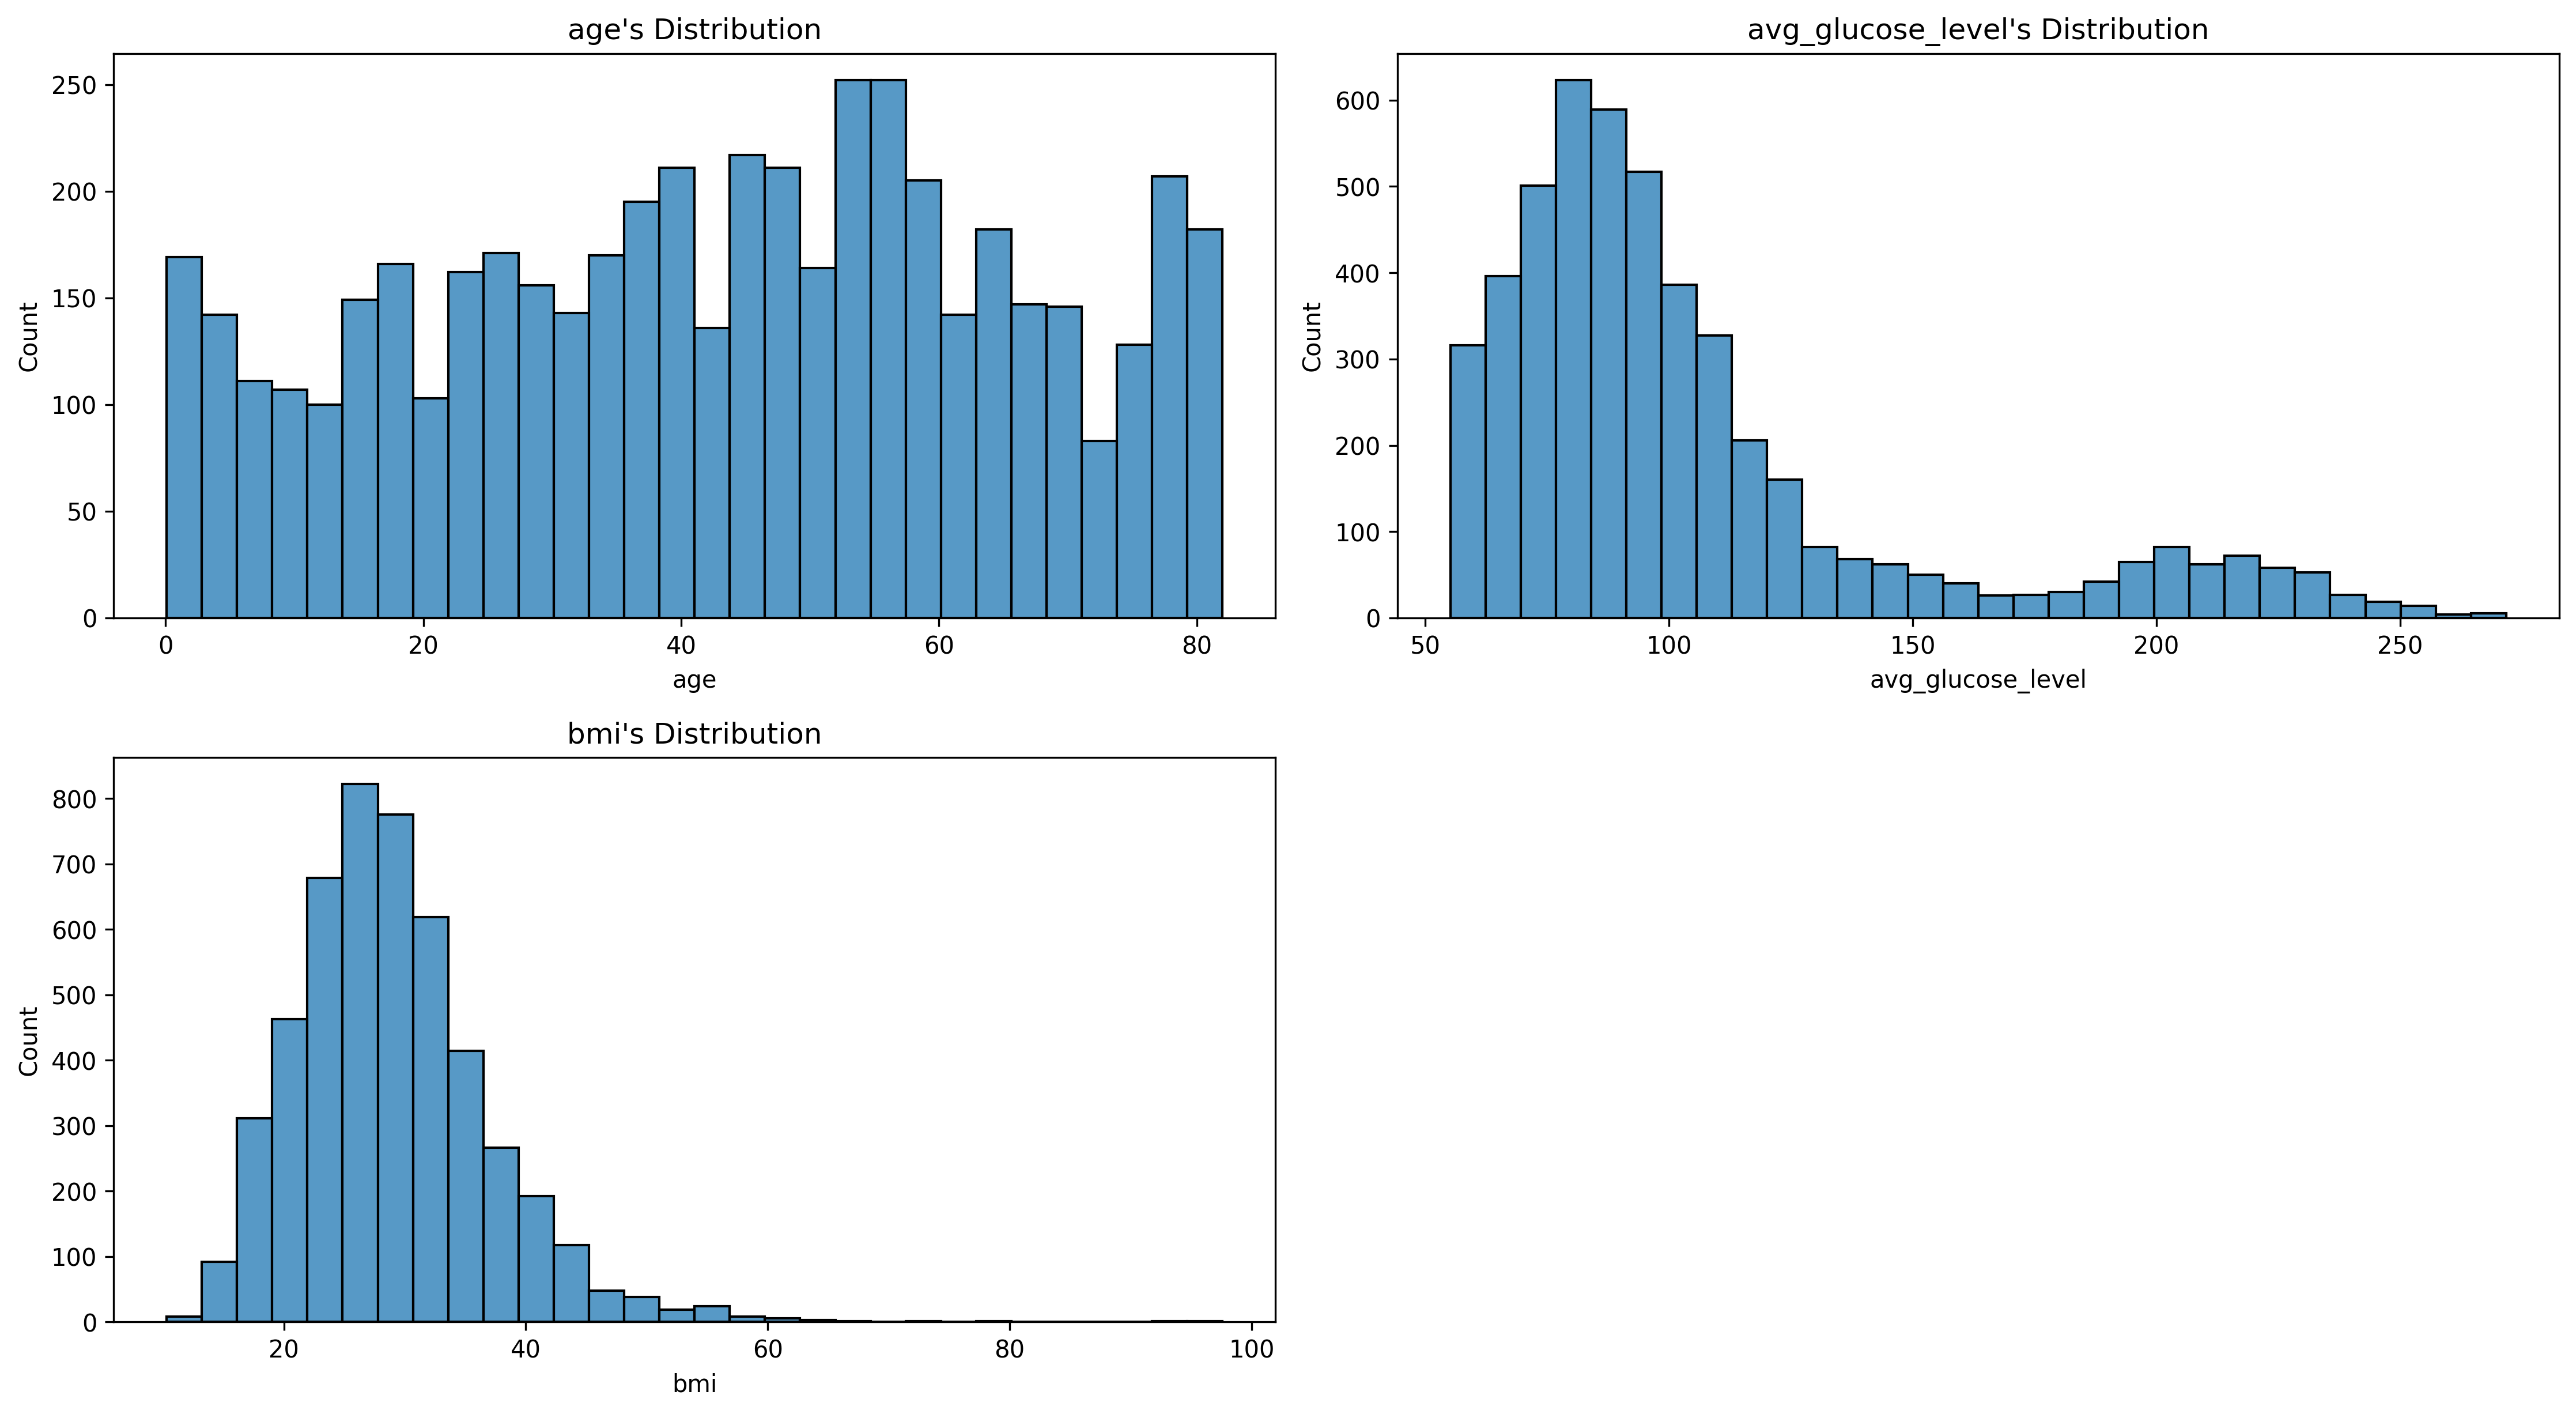

In [21]:
#Inspect numerical features' distribution

n_cols = 2
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes =axes.flatten()

for i, col, in enumerate(numerical_cols):
    ax = axes[i]

    sns.histplot(data=df, x=df[col], bins=30, ax=ax)

    ax.set_title(f"{col}'s Distribution")


# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
#plt.show()
show_shrunk(fig, width=800)

## Observations

#### Age
- normally distributed


#### Averege glucose level
- seems well distributed, with a moderate skew to the right
- the small build up around 225 most likely indicates people with diabetes. This may be a predictor of stroke.


#### BMI
- normally distributed









### Inspect feature-to-target relationship

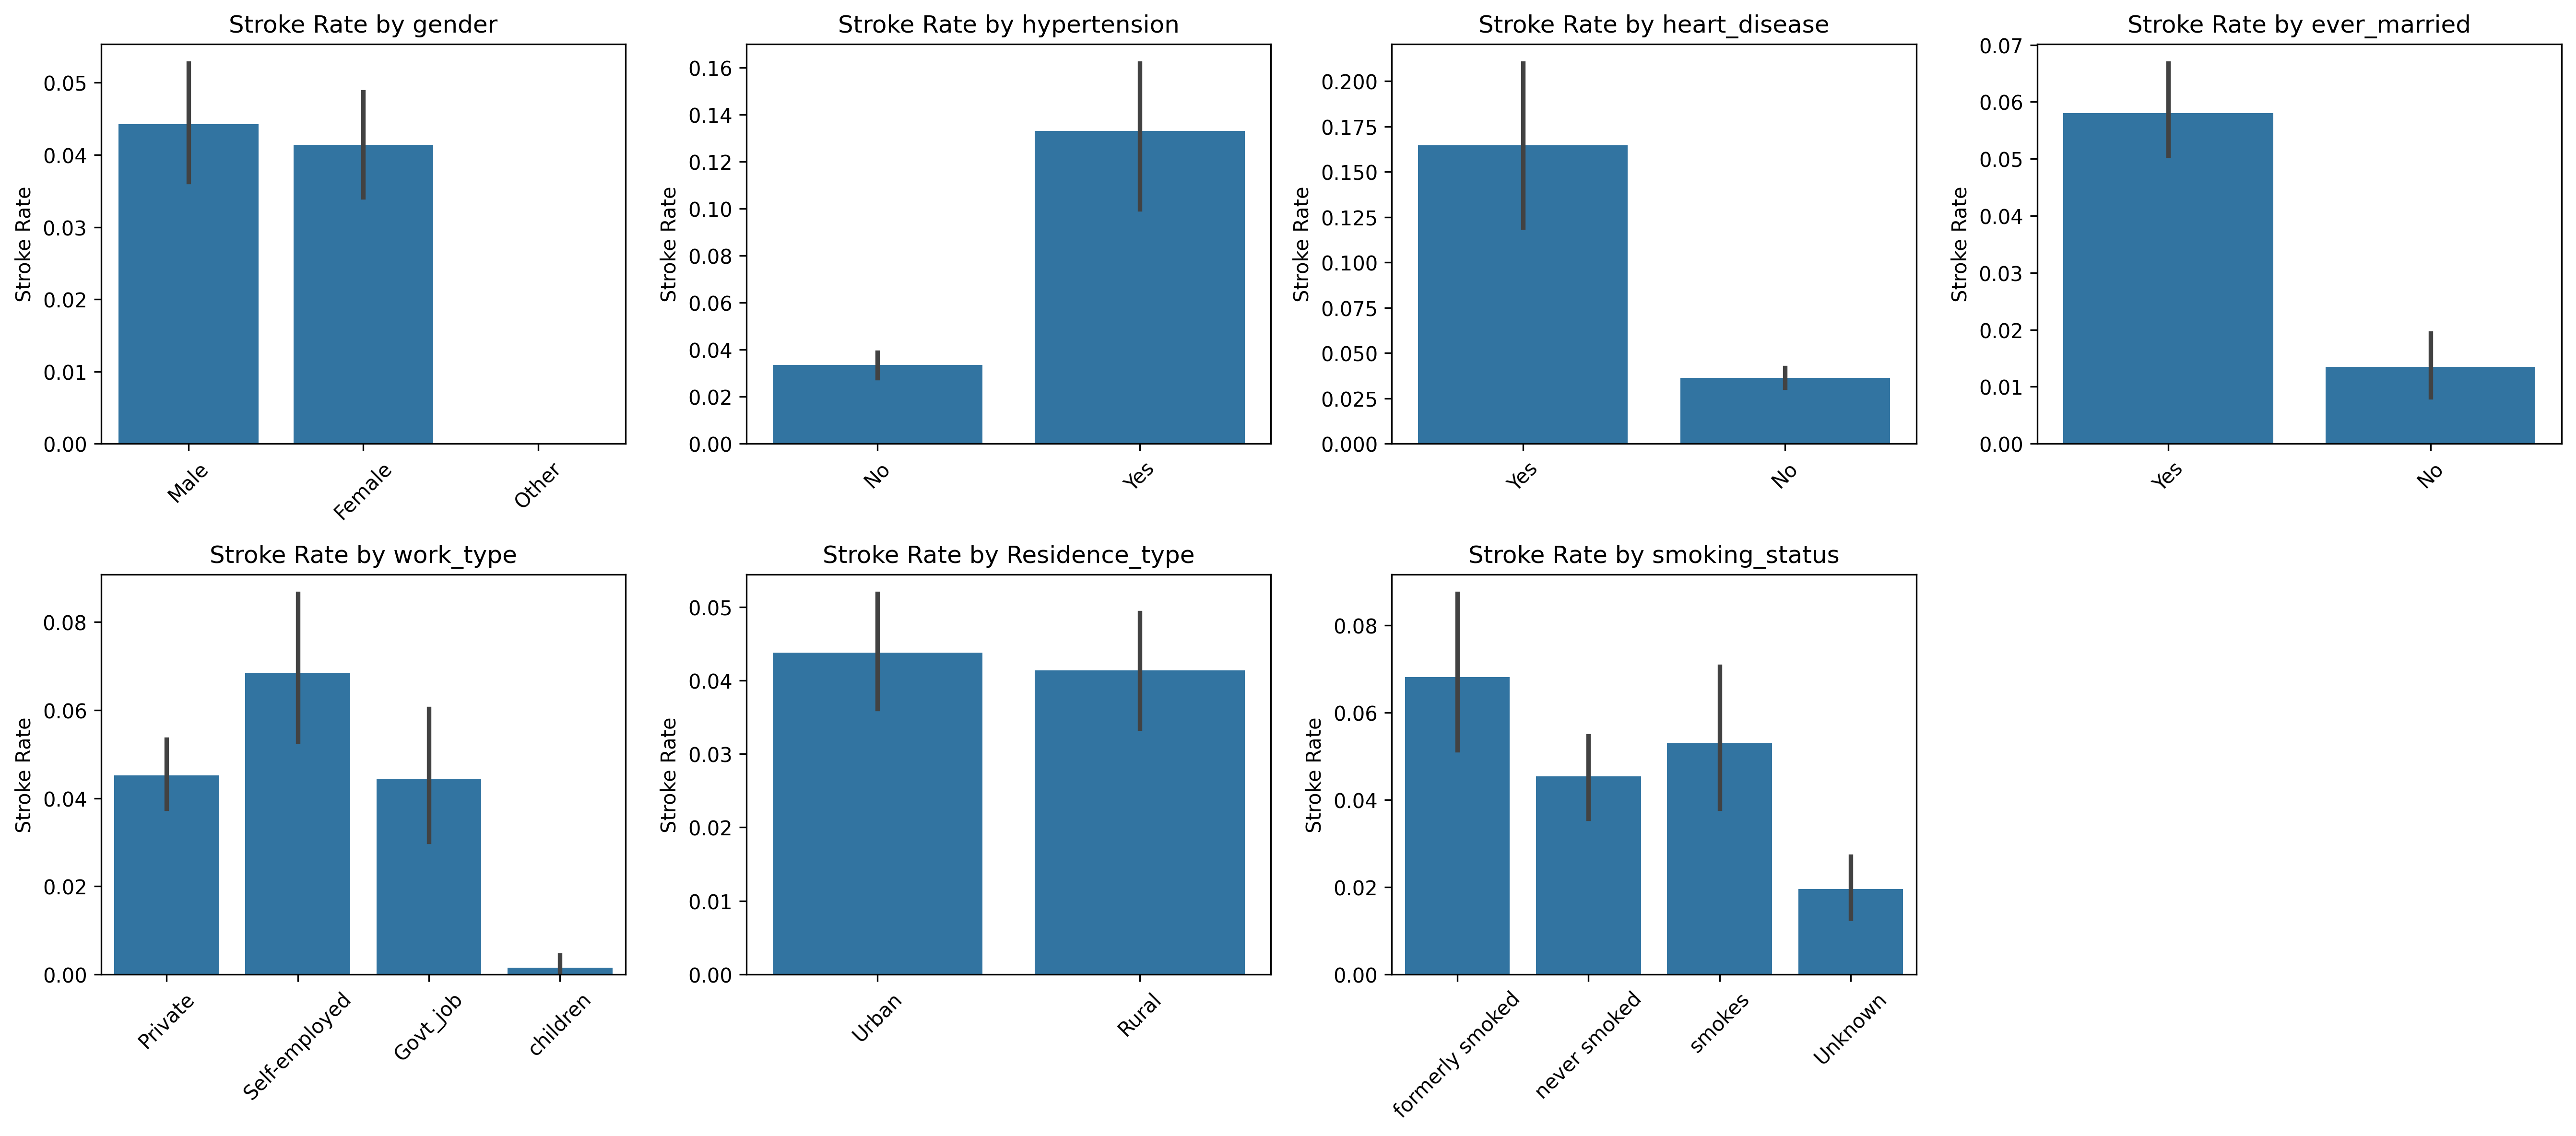

In [170]:
# Determine grid size (4 plots per row)
n_cols = 4
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.barplot(data=df, x=col, y="stroke", ax=ax, estimator=np.mean)
    ax.set_title(f"Stroke Rate by {col}")
    ax.set_ylabel("Stroke Rate")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)

# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
#plt.show()
show_shrunk(fig, width=1000)

## Observations

### Gender
- `male` and `female` seems normally distributed
- `other` category is extremely low (<1%)

#### Action:
- Merge `other` into a generic `Unknown` group to prevent useless sparse columns when using one-hot encoding


### Work Type
- `never_worked` extremely low (<1%)
- `children` very low (~5%) but still relevent

#### Action:
- merge `never_worked` with `children`, also to prevent useless sparse columns with one-hot encoding


### Hypertension, heart-disease and smoking status
- distribution makes sense as it shows the potential risks associated with stroke. Keep as is.


### Ever married
- A bit of imbalance here, however, this could be a predictor of stroke. Keep as is.


### Residence type
- well distributed. Keep as is.

In [23]:
# Gender category
infoFrame = df['gender'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['gender'].value_counts(normalize=True)
infoFrame

count  proportion
gender                   
Female   2897    0.590141
Male     2011    0.409656
Other       1    0.000204

### Update On action
- After observing that `other` only has one observation out of almost 5000, the statistical insignificance of keeping it in `other` should not have any impact on modeling.

In [24]:
# Work type category
infoFrame = df['work_type'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['work_type'].value_counts(normalize=True)
infoFrame

count  proportion
work_type                       
Private         2811    0.572622
Self-employed    775    0.157873
children         671    0.136688
Govt_job         630    0.128336
Never_worked      22    0.004482

In [25]:
# Merge `never_worked` with `children`
df['work_type'] = df['work_type'].replace({'Never_worked': 'children'})
infoFrame = df['work_type'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['work_type'].value_counts(normalize=True)
infoFrame

count  proportion
work_type                       
Private         2811    0.572622
Self-employed    775    0.157873
children         693    0.141169
Govt_job         630    0.128336

### Numeric-vs-stroke boxplots

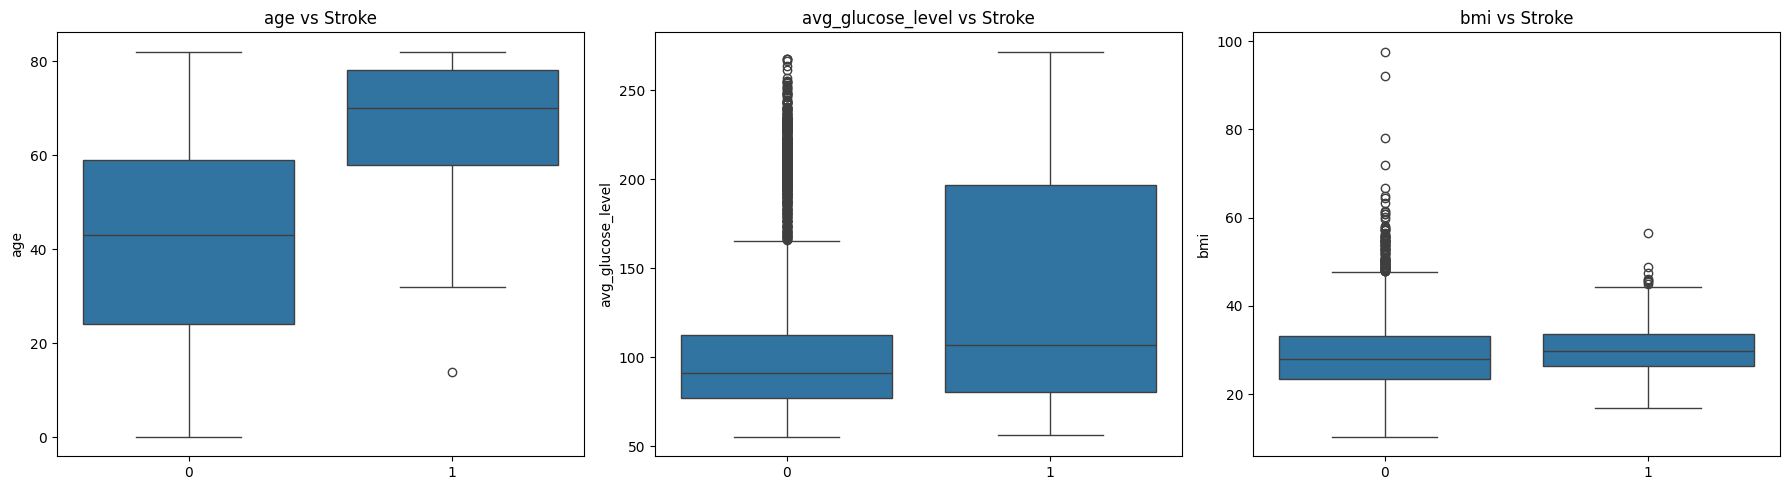

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(['age', 'avg_glucose_level', 'bmi']):
    sns.boxplot(data=df, x="stroke", y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs Stroke")
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()


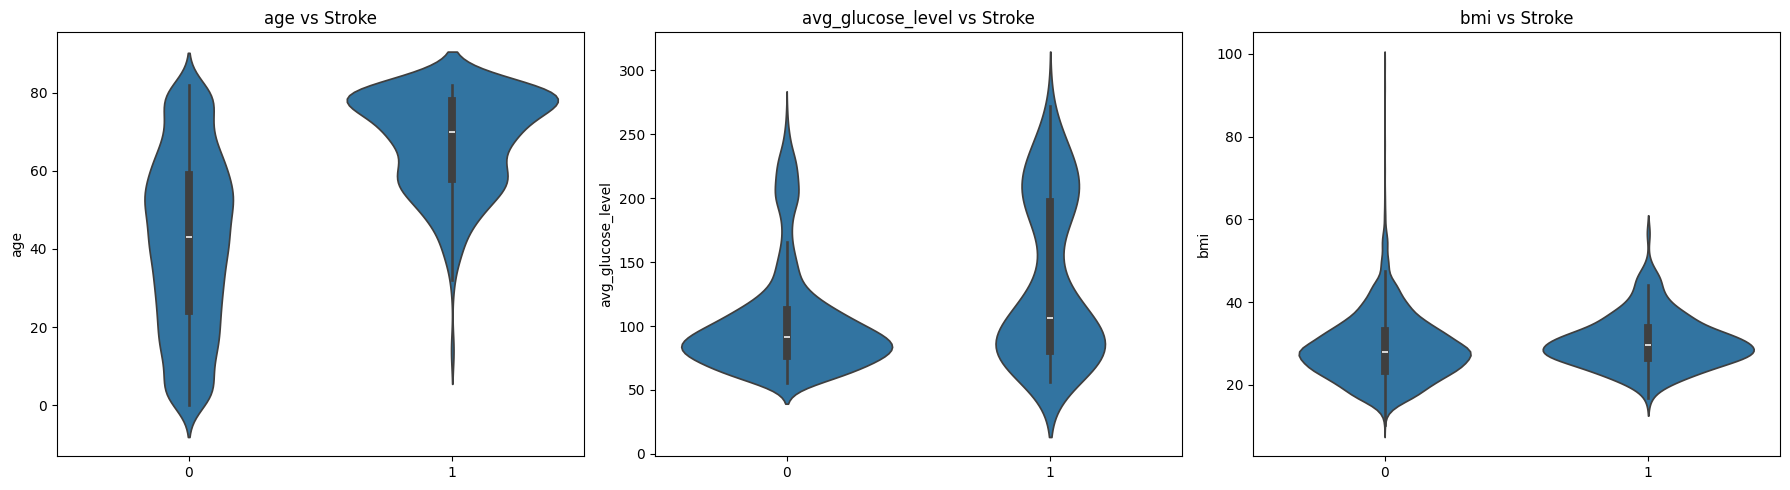

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(['age', 'avg_glucose_level', 'bmi']):
    sns.violinplot(data=df, x="stroke", y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs Stroke")
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()

### Correlation with the stroke target (numeric only)

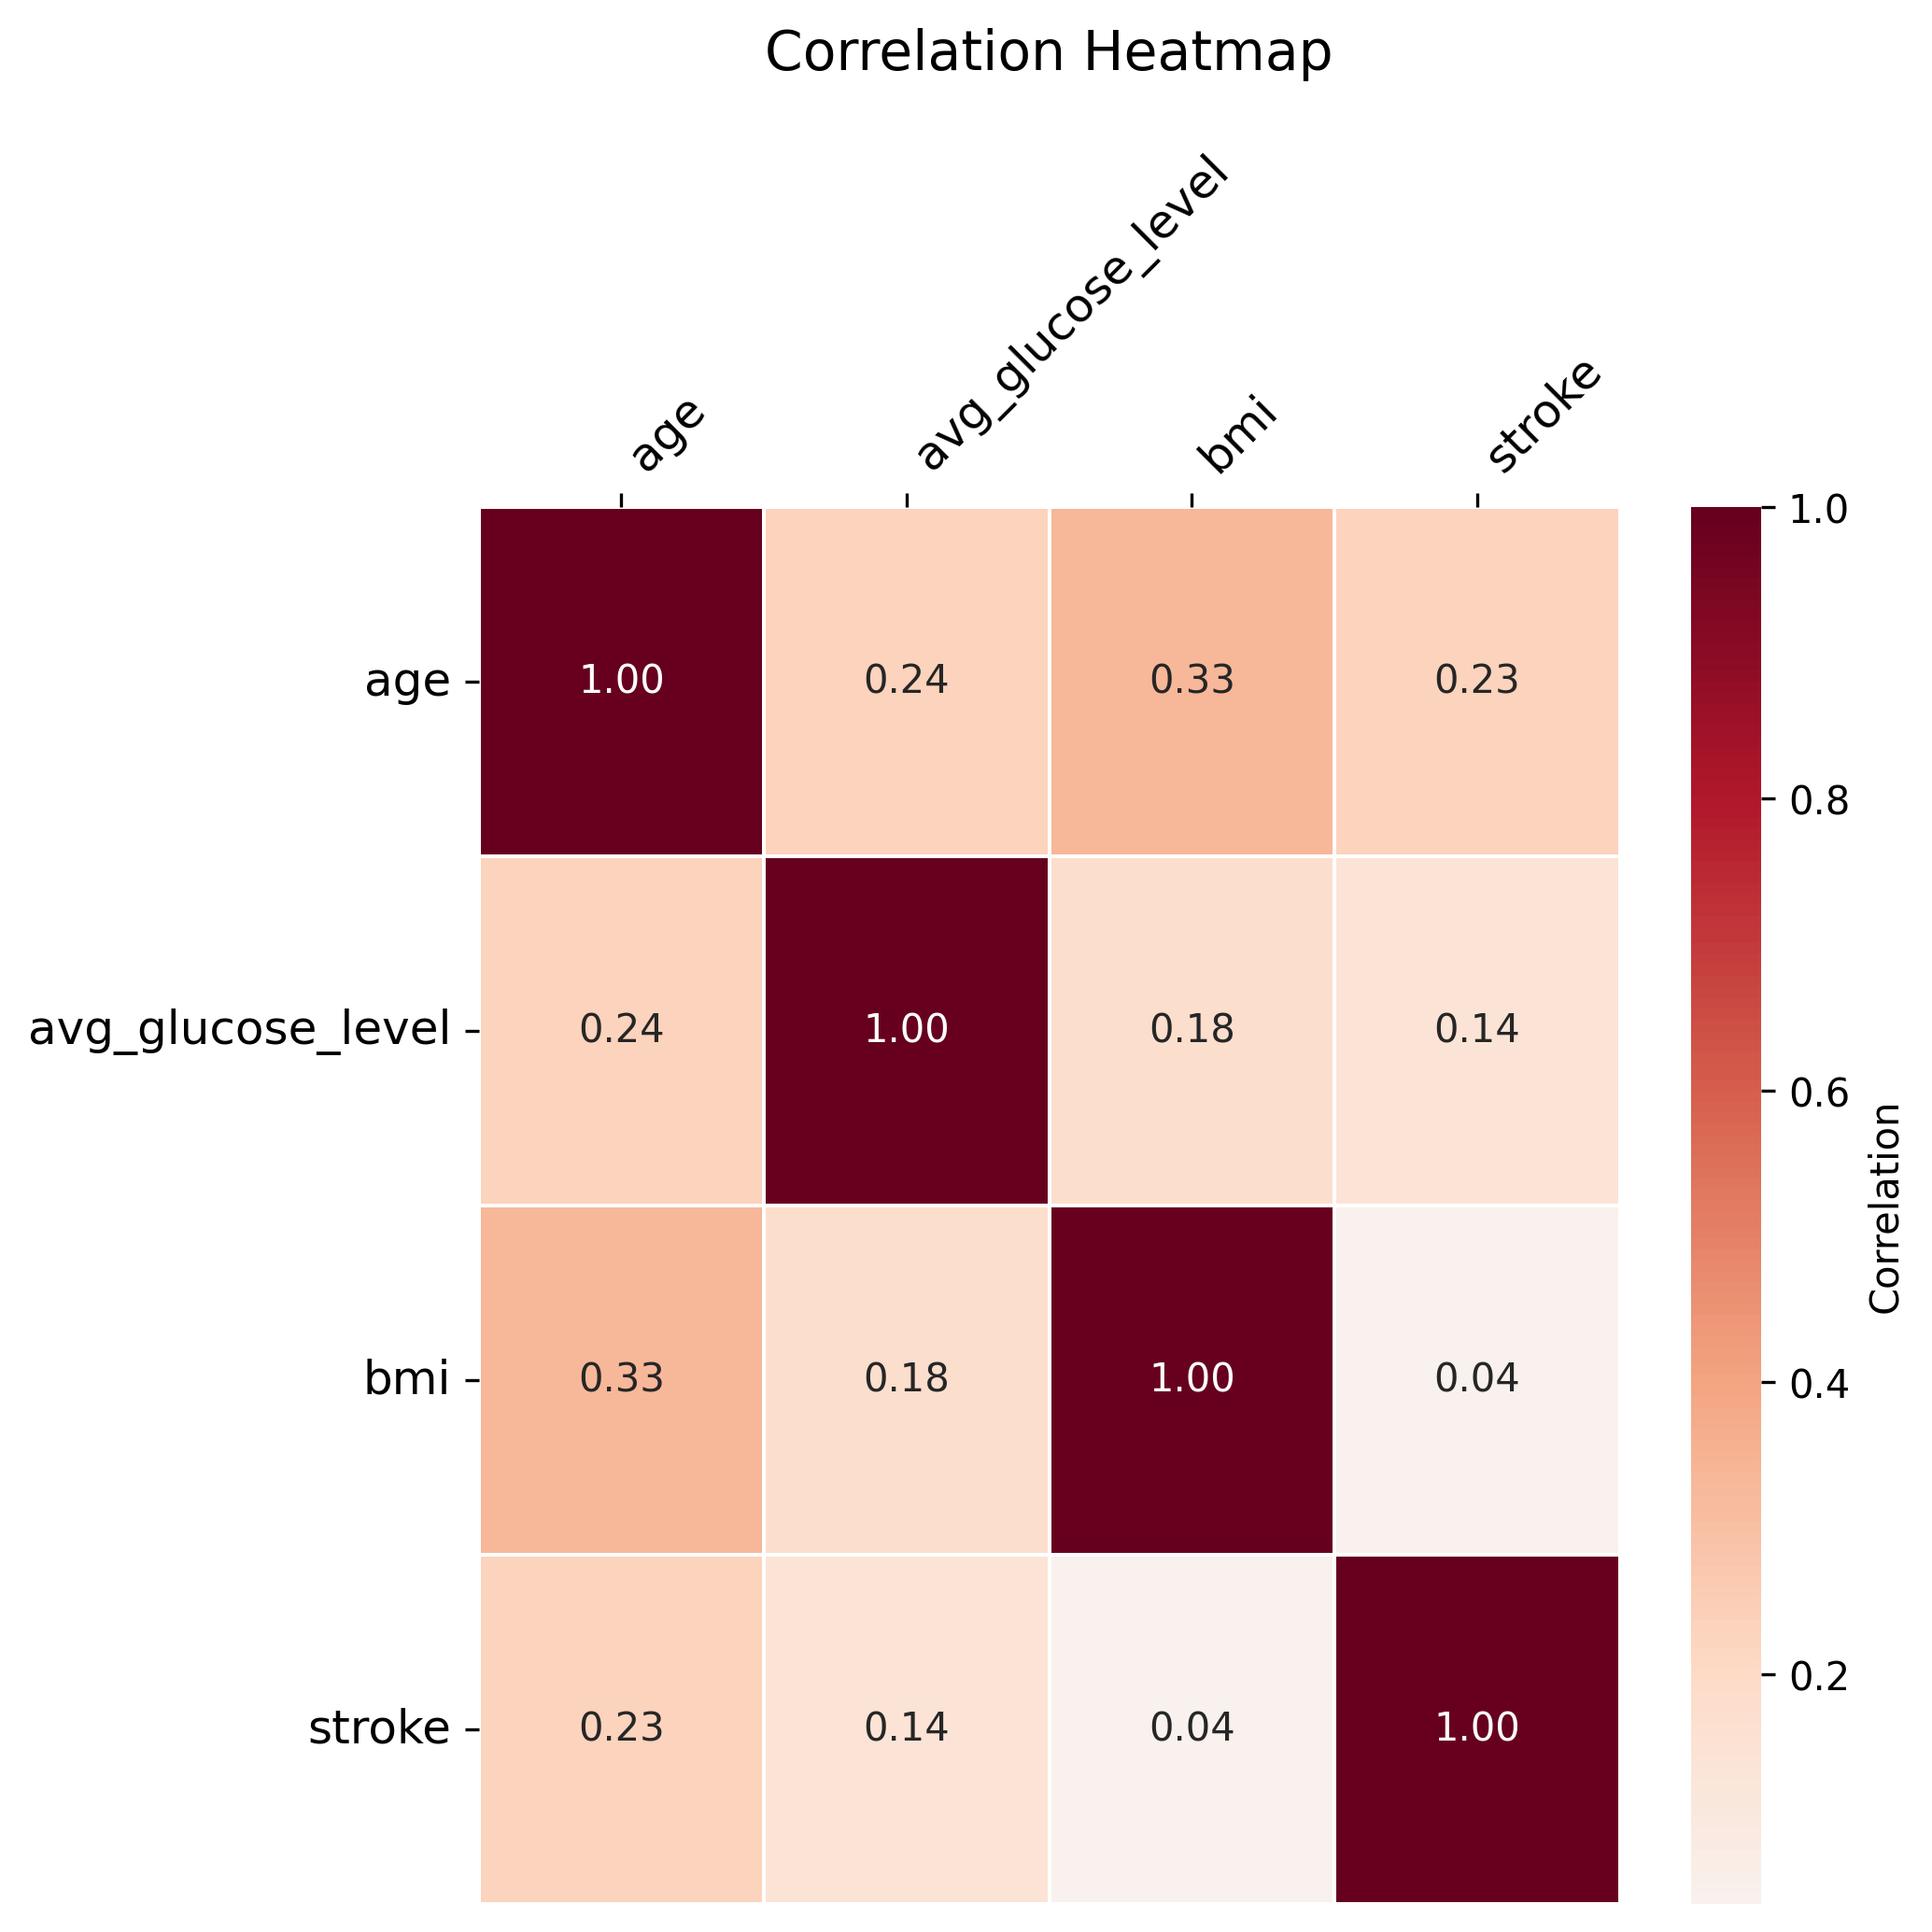

In [163]:
corr_data = df[['age', 'avg_glucose_level', 'bmi', 'stroke']].corr()

fig, ax = plt.subplots(figsize=(7,7))

sns.heatmap(data=corr_data, 
            annot=True,
            fmt=".2f",
            cmap="RdBu_r",
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation'})

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
ax.set_title("Correlation Heatmap", pad=20, fontsize=14)

plt.tight_layout()
show_shrunk(fig, width=500)

## Statistical Tests

### U Test for Numerical Features

In [29]:
# Verify the statistical significance of the differences in target groups per numerical features
# Age
age_stroke = df['age'][(df['stroke']==1)]
age_nostroke = df['age'][(df['stroke']==0)]

age_combined = pd.DataFrame({
    'age': pd.concat([age_stroke, age_nostroke], ignore_index=True),
    'stroke': ([1] * len(age_stroke)) + ([0]* len(age_nostroke))
})
age_combined.sort_values(by='age', ascending=True, inplace=True)
age_combined['rank'] = age_combined['age'].rank(method='average')


# avg_glucose
avgg_stroke = df['avg_glucose_level'][(df['stroke']==1)]
avgg_nostroke = df['avg_glucose_level'][(df['stroke']==0)]

avgg_combined = pd.DataFrame({
    'avg_glucose_level': pd.concat([avgg_stroke, avgg_nostroke], ignore_index=True),
    'stroke': ([1] * len(avgg_stroke)) + ([0]* len(avgg_nostroke))
})
avgg_combined.sort_values(by='avg_glucose_level', ascending=True, inplace=True)
avgg_combined['rank'] = avgg_combined['avg_glucose_level'].rank(method='average')

# bmi
bmi_stroke = df['bmi'][(df['stroke']==1)]
bmi_nostroke = df['bmi'][(df['stroke']==0)]

bmi_combined = pd.DataFrame({
    'bmi': pd.concat([bmi_stroke, bmi_nostroke], ignore_index=True),
    'stroke': ([1] * len(bmi_stroke)) + ([0]* len(bmi_nostroke))
})
bmi_combined.sort_values(by='bmi', ascending=True, inplace=True)
bmi_combined['rank'] = bmi_combined['bmi'].rank(method='average')


In [30]:
# Compute rank sum for the stroke group per feature
# Age
r_age_stroke = age_combined.loc[age_combined['stroke'] == 1, 'rank'].sum()
r_age_nostroke = age_combined.loc[age_combined['stroke'] == 0, 'rank'].sum()
m = len(age_stroke)
n = len(age_nostroke)
print(f"m: {m}")
print(f"n: {n}\n")
print(f"r_age_stroke: {r_age_stroke}")


# Avg glucose level
r_avgg_stroke = avgg_combined.loc[avgg_combined['stroke'] == 1, 'rank'].sum()
r_avgg_nostroke = avgg_combined.loc[avgg_combined['stroke'] == 0, 'rank'].sum()
print(f"r_avgg_stroke: {r_avgg_stroke}")


# BMI
r_bmi_stroke = bmi_combined.loc[bmi_combined['stroke'] == 1, 'rank'].sum()
r_bmi_nostroke = bmi_combined.loc[bmi_combined['stroke'] == 0, 'rank'].sum()
print(f"r_bmi_stroke: {r_bmi_stroke}")


m: 209
n: 4700

r_age_stroke: 843224.5
r_avgg_stroke: 636223.0
r_bmi_stroke: 590966.5


In [31]:
#Compute U statistic
from scipy.stats import norm

# Age
u_age_stroke = r_age_stroke - (m * (m+1)) / 2
u_age_nostroke = r_age_nostroke - n*(n+1)/2
U_age = min(u_age_stroke, u_age_nostroke)

mu_U_age = m*n/2
var_U_age = m*n*(m+n+1)/12
sigma_U_age = var_U_age**0.5

Z_age = (U_age - mu_U_age) / sigma_U_age
print(f"Z_age: {Z_age}")

p_value_age = 2 * (1 - norm.cdf(abs(Z_age)) )
print(f"p_value_age: {p_value_age}\n")


# Avg glucose level
u_avgg_stroke = r_avgg_stroke - (m * (m+1)) / 2
u_avgg_nostroke = r_avgg_nostroke - n*(n+1)/2
U_avgg = min(u_avgg_stroke, u_avgg_nostroke)

mu_U_avgg = m*n/2
var_U_avgg = m*n*(m+n+1)/12
sigma_U_avgg = var_U_avgg**0.5

Z_avgg = (U_avgg - mu_U_avgg) / sigma_U_avgg
print(f"Z_avgg: {Z_avgg}")

p_value_avgg = 2 * (1 - norm.cdf(abs(Z_avgg)) )
print(f"p_value_avgg: {p_value_avgg}\n")


# BMI
u_bmi_stroke = r_bmi_stroke - (m * (m+1)) / 2
u_bmi_nostroke = r_bmi_nostroke - n*(n+1)/2
U_bmi = min(u_bmi_stroke, u_bmi_nostroke)

mu_U_bmi = m*n/2
var_U_bmi = m*n*(m+n+1)/12
sigma_U_bmi = var_U_bmi**0.5

Z_bmi = (U_bmi - mu_U_bmi) / sigma_U_bmi
print(f"Z_bmi: {Z_bmi}")

p_value_bmi = 2 * (1 - norm.cdf(abs(Z_bmi)) )
print(f"p_value_bmi: {p_value_bmi}\n")


Z_age: -16.466911031331666
p_value_age: 0.0

Z_avgg: -6.141643874497145
p_value_avgg: 8.167180265417073e-10

Z_bmi: -3.884242584732185
p_value_bmi: 0.00010264938114956657



### U Test Conclusion
The U-test transforms both groups into a single ranked list and checks whether one group tends to occupy systematically higher rank positions. Under the null hypothesis, the U statistic has a known expected value and variance, so we standardize it into a Z-score. The Z-score tells us how extreme the observed U is relative to what would be expected if both groups came from the same population. We then use the standard normal CDF to convert that extremeness into a p-value, which indicates how likely such a rank difference would be purely by chance.

For all three numerical variables, the Mann–Whitney U-test indicates statistically significant differences between stroke and non-stroke groups. However, age shows the strongest distributional shift (Z ≈ –16), average glucose shows a moderate shift (Z ≈ –6), and BMI shows only a small shift (Z ≈ –4). Therefore, <b>although all differences are statistically significant due to the large sample size</b>, the practical separation is strongest for age, moderate for glucose, and minimal for BMI.

### Chi-Squared test for Categorical Features

In [32]:
from scipy.stats import chi2_contingency

# Hypertension vs Stroke 
table_htn = pd.crosstab(df['hypertension'], df['stroke'])
print(table_htn)

chi2_htn, p_htn, dof_htn, expected_htn = chi2_contingency(table_htn)

print()
print("Chi-square:", chi2_htn)
print("p-value:", p_htn)
print("Degrees of Freedom:", dof_htn)
print("Expected counts:\n", expected_htn)

stroke           0    1
hypertension           
No            4309  149
Yes            391   60

Chi-square: 97.2749949311716
p-value: 6.033751208728258e-23
Degrees of Freedom: 1
Expected counts:
 [[4268.20126299  189.79873701]
 [ 431.79873701   19.20126299]]


In [33]:
# Heart Disease vs Stroke 
table_hd = pd.crosstab(df['heart_disease'], df['stroke'])
print(table_hd)

chi2_hd, p_hd, dof_hd, expected_hd = chi2_contingency(table_hd)

print()
print("Chi-square:", chi2_hd)
print("p-value:", p_hd)
print("Degrees of Freedom:", dof_hd)
print("Expected counts:\n", expected_hd)


stroke            0    1
heart_disease           
No             4497  169
Yes             203   40

Chi-square: 90.2795595563918
p-value: 2.0677783295228634e-21
Degrees of Freedom: 1
Expected counts:
 [[4467.34569159  198.65430841]
 [ 232.65430841   10.34569159]]


### Interpretation of Chi-Squared Results
Because both hypertension and heart_disease produced Chi-square p-values far below the 0.05 threshold:
- we reject the null hypothesis that the category proportions are the same across stroke vs. non-stroke groups
- we conclude that stroke occurrence is not independent of hypertension
- and that stroke occurrence is not independent of heart disease

Both hypertension and heart disease show statistically significant associations with stroke.
The proportions of stroke differ noticeably between people with and without these conditions.

## Post EDA observations

#### A) Strong class imbalance
 - Stroke cases ~5% vs non-stroke cases ~95%

#### Consequences

 - accuracy is not informative
 - recall for the positive class is crucial
 - ROC-AUC is a better general metric than accuracy
 - Precision is important if you care about reducing false alerts
 - Treshold tuning may be needed after training

##### Plan
- use class_weight, recall, or AUC-focused models


#### B) Mix of Feature Types

- Numeric: `age`, `avg_glucose_level`, `BMI`
- Categorical: `gender`, `ever_married`, `work_type`, `Residene_type`, `smoking_status`, `hypertension`, `heart_disease`

##### Implications
- will require ColumnTransformer with scaling + one-hot encoding
- SVMs and LogisticRegession require scaling
- Trees and ensembles do not use scaling


#### C) Some Numeric Features are skewed

- `avg_glucose_level` is moderately right-skewed
- `BMI` approximately gamma-shaped
-  `age` has natural peaks

- Scaling neede for SMV, LogisticRegression


#### D) Rare categories in Categorical Features

- `gender`: 'other' appears once
- `work_type`: 'never_worked' merged with 'children'

- Rare level should not harm tree-models
- But may destabilize linear models if one-hot produces sparse columns


#### E) Feature Engineering
Feature engineering was intentionally minimal because the dataset already contains well-defined clinical variables. The only engineered feature transformations applied were: handling rare categories, scaling numerical features, and one-hot encoding categorical features. Additional synthetic features were not created to avoid adding noise.


#### F) Statistical Tests Confirm Group Differences
1. Mann-Whitley U-tests (numeric)
Performed for `age`, `avg_glucose_level`, `bmi`

<b>Findings</b>
- `age`: very strong distributional separation (Z ≈ –16), stroke group much older
- `avg_glucose_level`: moderate separation (Z ≈ –6)
- `bmi`: small separation (Z ≈ –4), likely limited predictive value

<b>Interpretation</b>

- With large N, all p-values are extremely small, but effect magnitude differs:
    - `age` strongest, `avg_glucose_level` moderate, `bmi` weakest
- Tests confirm the visual differences seen in box/violin plots
- Significance does not imply predictive strength; that will be evaluated during modeling

2. Chi-Square Tests (categorical)
Applied to the categorical features showing clear differences in stroke rate:

- `hypertension`
- `heart_disease`

<b>Findings</b>
- Both features show statistically significant association with stroke
- Stroke rates are substantially higher in the “Yes” categories for both variables

<b>Interpretation</b>
- Confirms the patterns visible in bar charts
- Significance indicates association, not causality
- Strength of signal will be validated in the model (e.g., through coefficients or feature importances)


#### G) Medical context

- age, hypertension, and heart_disease align with well-established medical stroke risk factors
- Prefer models with interpretable explanations (LogReg, Tree-based)

# Run models

In [75]:
# Prepare train and test datasets

X = df.drop(columns=["stroke"])
y = df["stroke"]

print("Original:")
print(df["stroke"].value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, 
                                                    random_state=42, 
                                                    stratify=y)

# Just for sanity check, I verified that the stratify parameter worked, since `stroke` is very imbalanced.
print("Train:")
print(y_train.value_counts(normalize=True))

print("Test:")
print(y_test.value_counts(normalize=True))

# Computer imbalance ratio for XGBoost
imbalance_ratio = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"imbalance_ratio: {imbalance_ratio}")

Original:
stroke
0    0.957425
1    0.042575
Name: proportion, dtype: float64
Train:
stroke
0    0.957474
1    0.042526
Name: proportion, dtype: float64
Test:
stroke
0    0.95723
1    0.04277
Name: proportion, dtype: float64
imbalance_ratio: 22.51497005988024


In [76]:
# Models setup
preprocessor = make_preprocessor(numerical_cols, categorical_cols, scale_numeric=True)

selected_models = ["log_reg", "rf_clf", "gb_clf", "svc_rbf", "xgb_clf"]

# Apply selection to models and param_grids librairy
models = {name: all_models[name] for name in selected_models}
param_grids = {name: all_param_grids[name] for name in selected_models}
param_grids["xgb_clf"]["clf__scale_pos_weight"] = [1, imbalance_ratio]
pp.pprint(param_grids)


{'gb_clf': {'clf__learning_rate': [0.01, 0.05, 0.1],
            'clf__max_depth': [3, 5],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [2, 5],
            'clf__n_estimators': [100, 200, 300]},
 'log_reg': {'clf__C': [0.01, 0.1, 1, 10],
             'clf__class_weight': [None, 'balanced'],
             'clf__penalty': ['l2']},
 'rf_clf': {'clf__class_weight': ['balanced'],
            'clf__max_depth': [None, 10, 20],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__min_samples_split': [2, 5, 10],
            'clf__n_estimators': [10, 100, 500]},
 'svc_rbf': {'clf__C': [0.1, 1, 10, 100],
             'clf__class_weight': [None, 'balanced'],
             'clf__gamma': ['scale', 1, 0.1, 0.001, 0.0001]},
 'xgb_clf': {'clf__colsample_bytree': [0.8, 1.0],
             'clf__learning_rate': [0.01, 0.05, 0.1],
             'clf__max_depth': [2, 3, 4],
             'clf__n_estimators': [50, 100, 200],
             'clf__scale_pos_we


===== Training log_reg =====

Fitting 5 folds for each of 8 candidates, totalling 40 fits


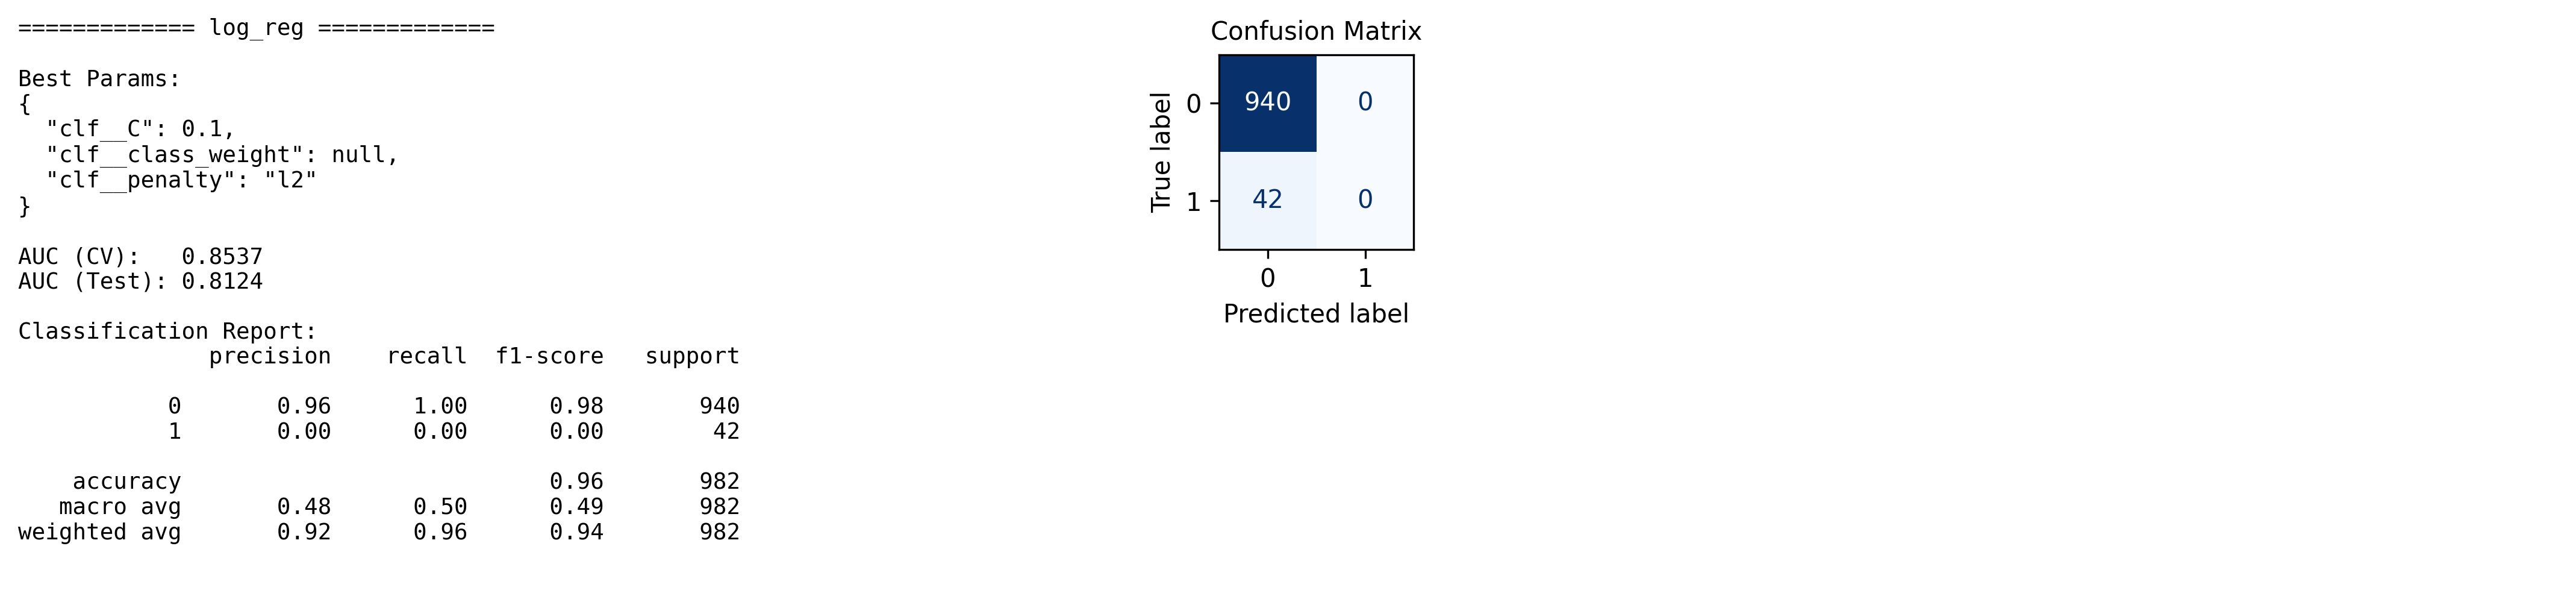


===== Training rf_clf =====

Fitting 5 folds for each of 54 candidates, totalling 270 fits


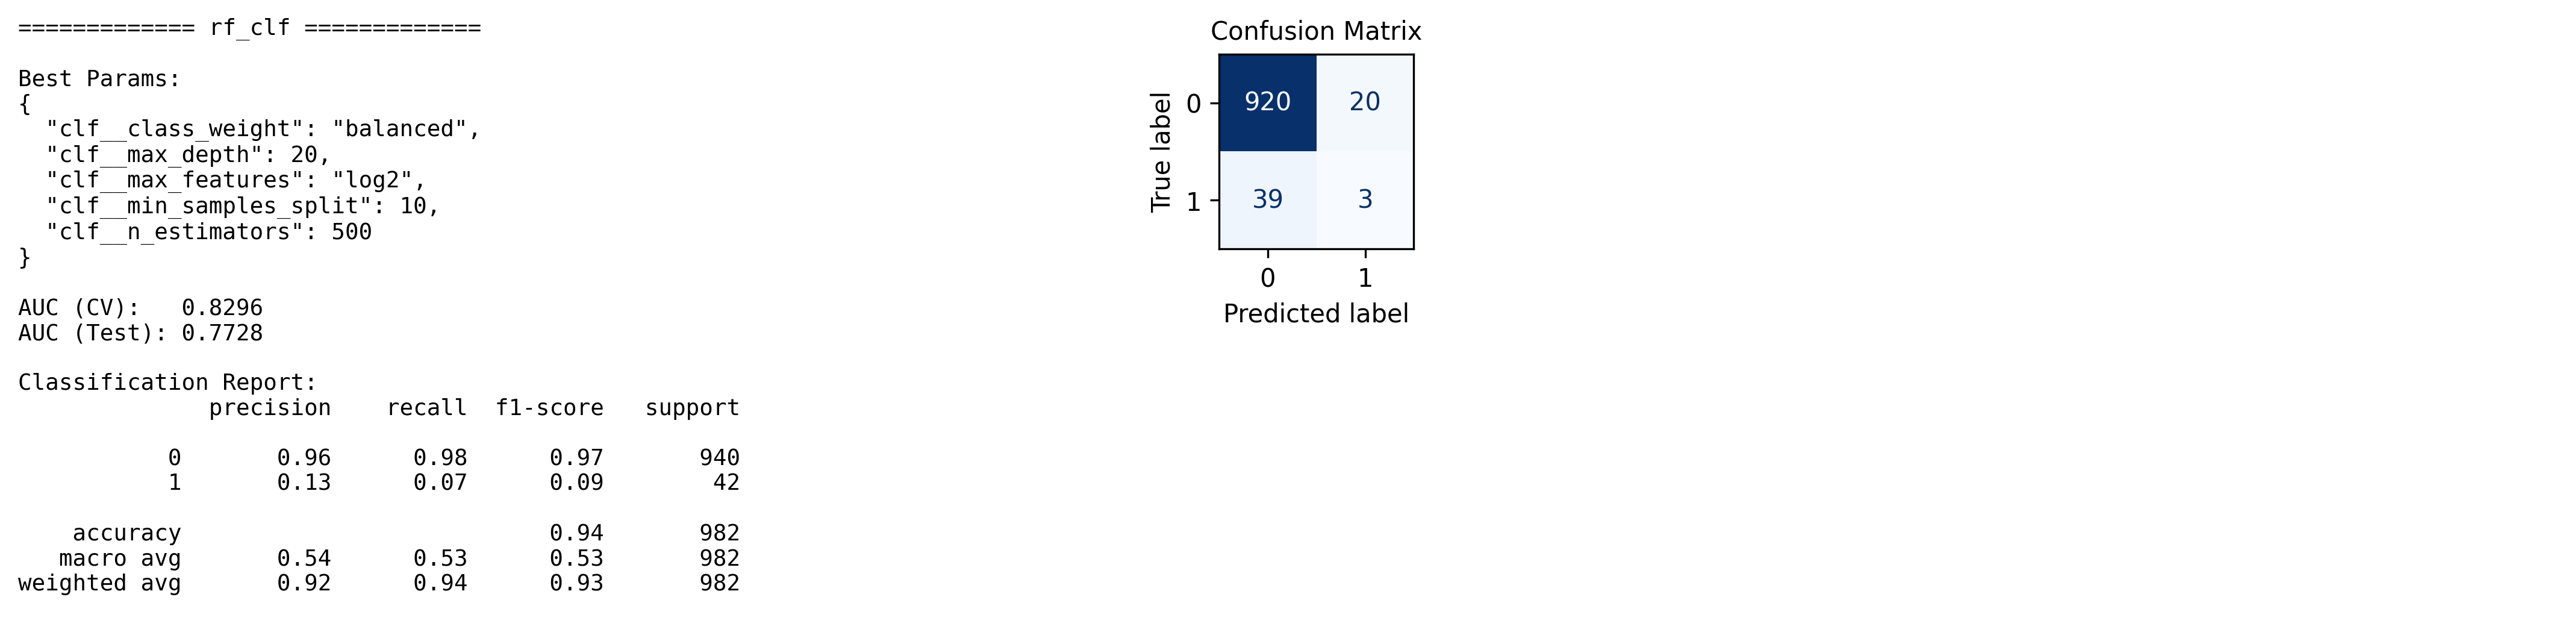


===== Training gb_clf =====

Fitting 5 folds for each of 108 candidates, totalling 540 fits


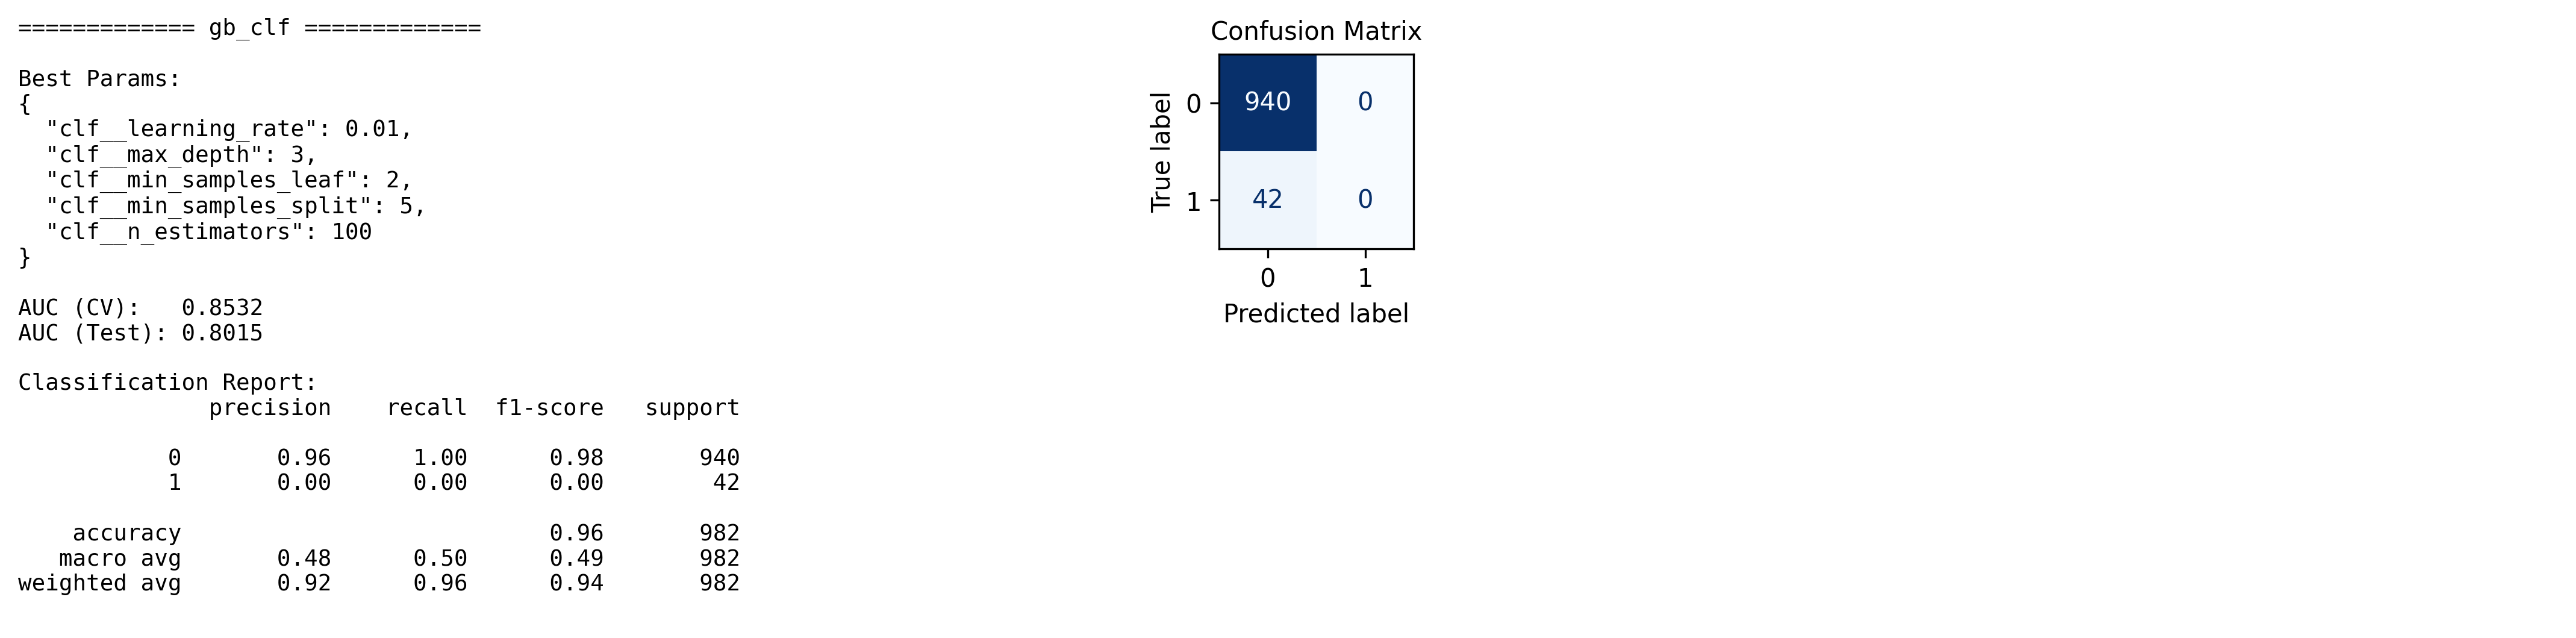


===== Training svc_rbf =====

Fitting 5 folds for each of 40 candidates, totalling 200 fits


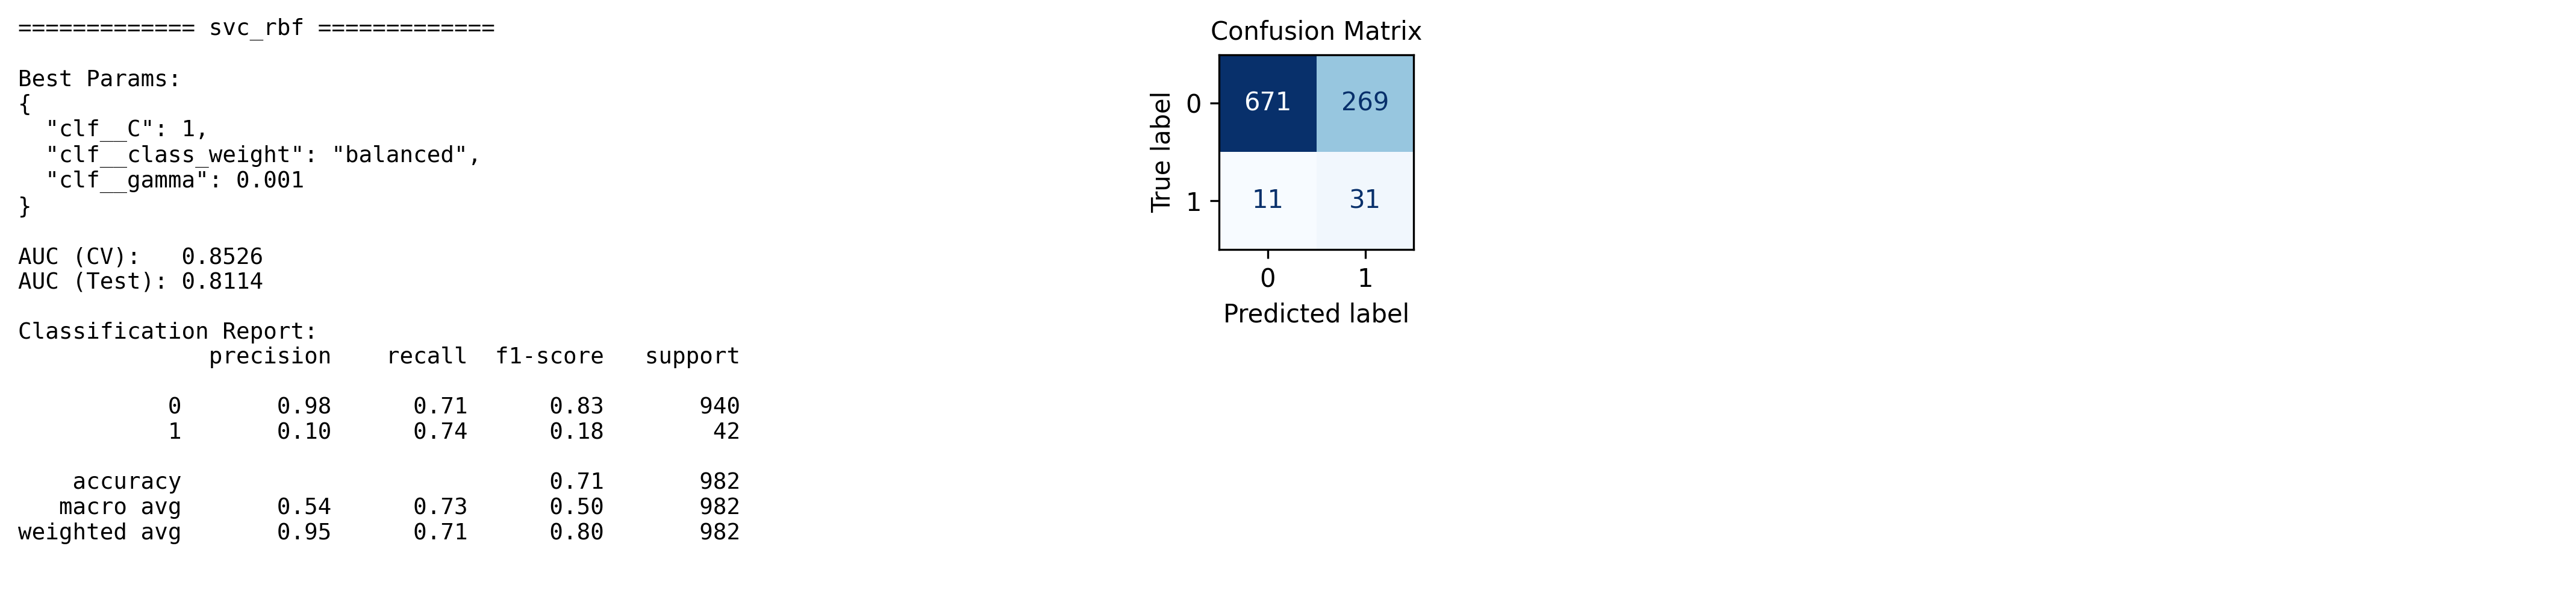


===== Training xgb_clf =====

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


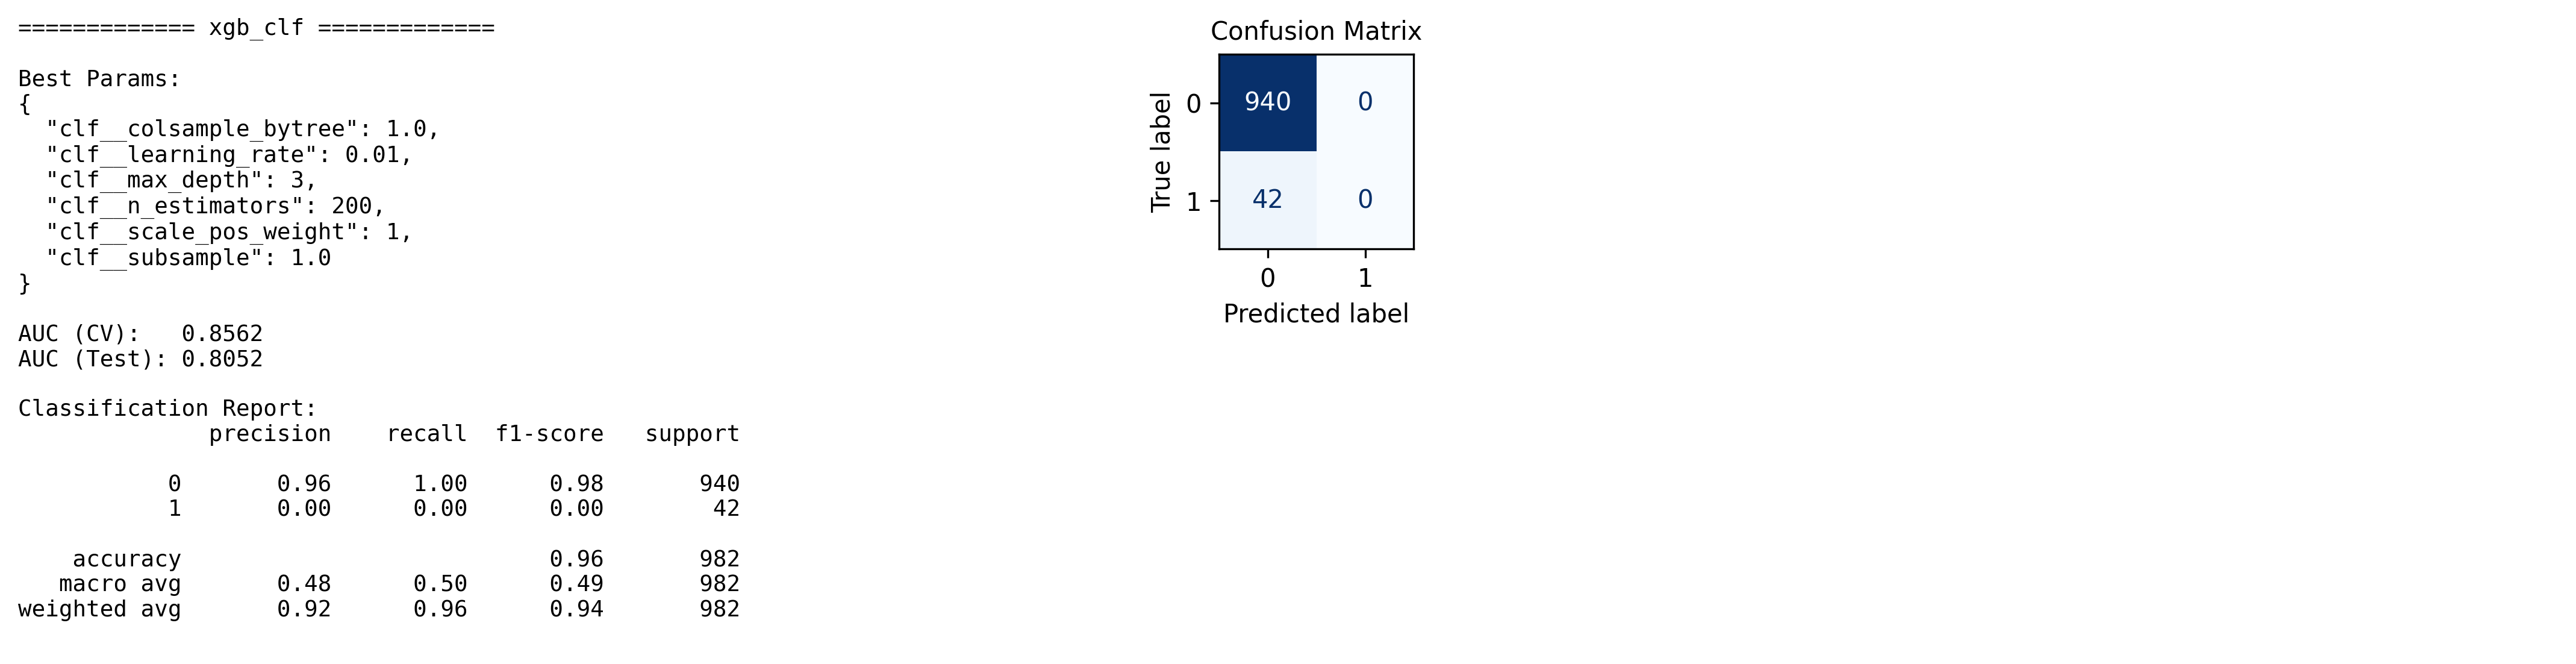

In [77]:
# Run Models
prelim_results_run1 = run_multiple_models(models, param_grids, preprocessor,
                            X_train, y_train, X_test, y_test, scoring='roc_auc')

In [78]:
#Fine tune some paramters

pp.pprint(param_grids)

{'gb_clf': {'clf__learning_rate': [0.01, 0.05, 0.1],
            'clf__max_depth': [3, 5],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [2, 5],
            'clf__n_estimators': [100, 200, 300]},
 'log_reg': {'clf__C': [0.01, 0.1, 1, 10],
             'clf__class_weight': [None, 'balanced'],
             'clf__penalty': ['l2']},
 'rf_clf': {'clf__class_weight': ['balanced'],
            'clf__max_depth': [None, 10, 20],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__min_samples_split': [2, 5, 10],
            'clf__n_estimators': [10, 100, 500]},
 'svc_rbf': {'clf__C': [0.1, 1, 10, 100],
             'clf__class_weight': [None, 'balanced'],
             'clf__gamma': ['scale', 1, 0.1, 0.001, 0.0001]},
 'xgb_clf': {'clf__colsample_bytree': [0.8, 1.0],
             'clf__learning_rate': [0.01, 0.05, 0.1],
             'clf__max_depth': [2, 3, 4],
             'clf__n_estimators': [50, 100, 200],
             'clf__scale_pos_we

In [79]:
param_grids['log_reg']['clf__class_weight']=['balanced']
param_grids['rf_clf']['clf__n_estimators']=[500,700,900]
param_grids['rf_clf']['clf__min_samples_split']=[8,10,15,20]
param_grids['gb_clf']['clf__learning_rate']=[.01, .005, .001]
param_grids['gb_clf']['clf__max_depth']=[1,2, 3, 4]
param_grids['gb_clf']['clf__min_samples_split']=[4,5,6]
param_grids['svc_rbf']['clf__C']=[.5,1,2,5,7]
param_grids['svc_rbf']['clf__class_weight']=['balanced']
param_grids['svc_rbf']['clf__gamma']=[.01, .005, .002 , .001, .00075]
param_grids["xgb_clf"]["clf__n_estimators"] = [150, 200, 250, 300, 400] 
param_grids["xgb_clf"]["clf__learning_rate"] = [.01, .02, .03] 
param_grids["xgb_clf"]["clf__scale_pos_weight"] = [imbalance_ratio*0.5, imbalance_ratio, imbalance_ratio*1.5] 
pp.pprint(param_grids)

{'gb_clf': {'clf__learning_rate': [0.01, 0.005, 0.001],
            'clf__max_depth': [1, 2, 3, 4],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [4, 5, 6],
            'clf__n_estimators': [100, 200, 300]},
 'log_reg': {'clf__C': [0.01, 0.1, 1, 10],
             'clf__class_weight': ['balanced'],
             'clf__penalty': ['l2']},
 'rf_clf': {'clf__class_weight': ['balanced'],
            'clf__max_depth': [None, 10, 20],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__min_samples_split': [8, 10, 15, 20],
            'clf__n_estimators': [500, 700, 900]},
 'svc_rbf': {'clf__C': [0.5, 1, 2, 5, 7],
             'clf__class_weight': ['balanced'],
             'clf__gamma': [0.01, 0.005, 0.002, 0.001, 0.00075]},
 'xgb_clf': {'clf__colsample_bytree': [0.8, 1.0],
             'clf__learning_rate': [0.01, 0.02, 0.03],
             'clf__max_depth': [2, 3, 4],
             'clf__n_estimators': [150, 200, 250, 300, 400],
         


===== Training log_reg =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits


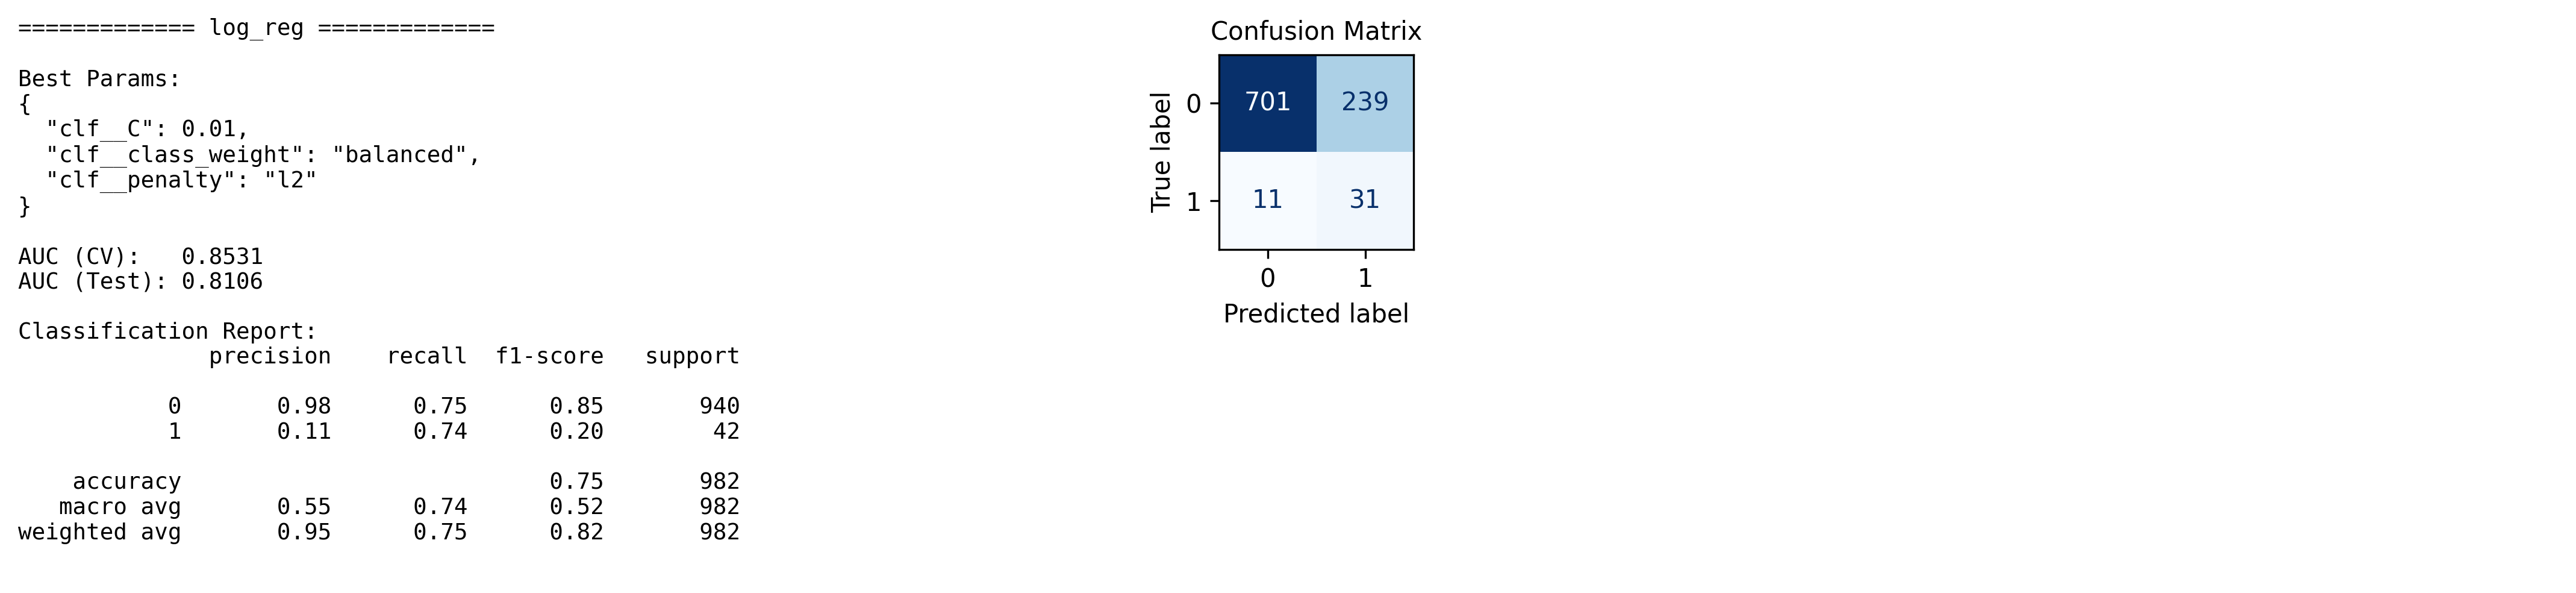


===== Training rf_clf =====

Fitting 5 folds for each of 72 candidates, totalling 360 fits


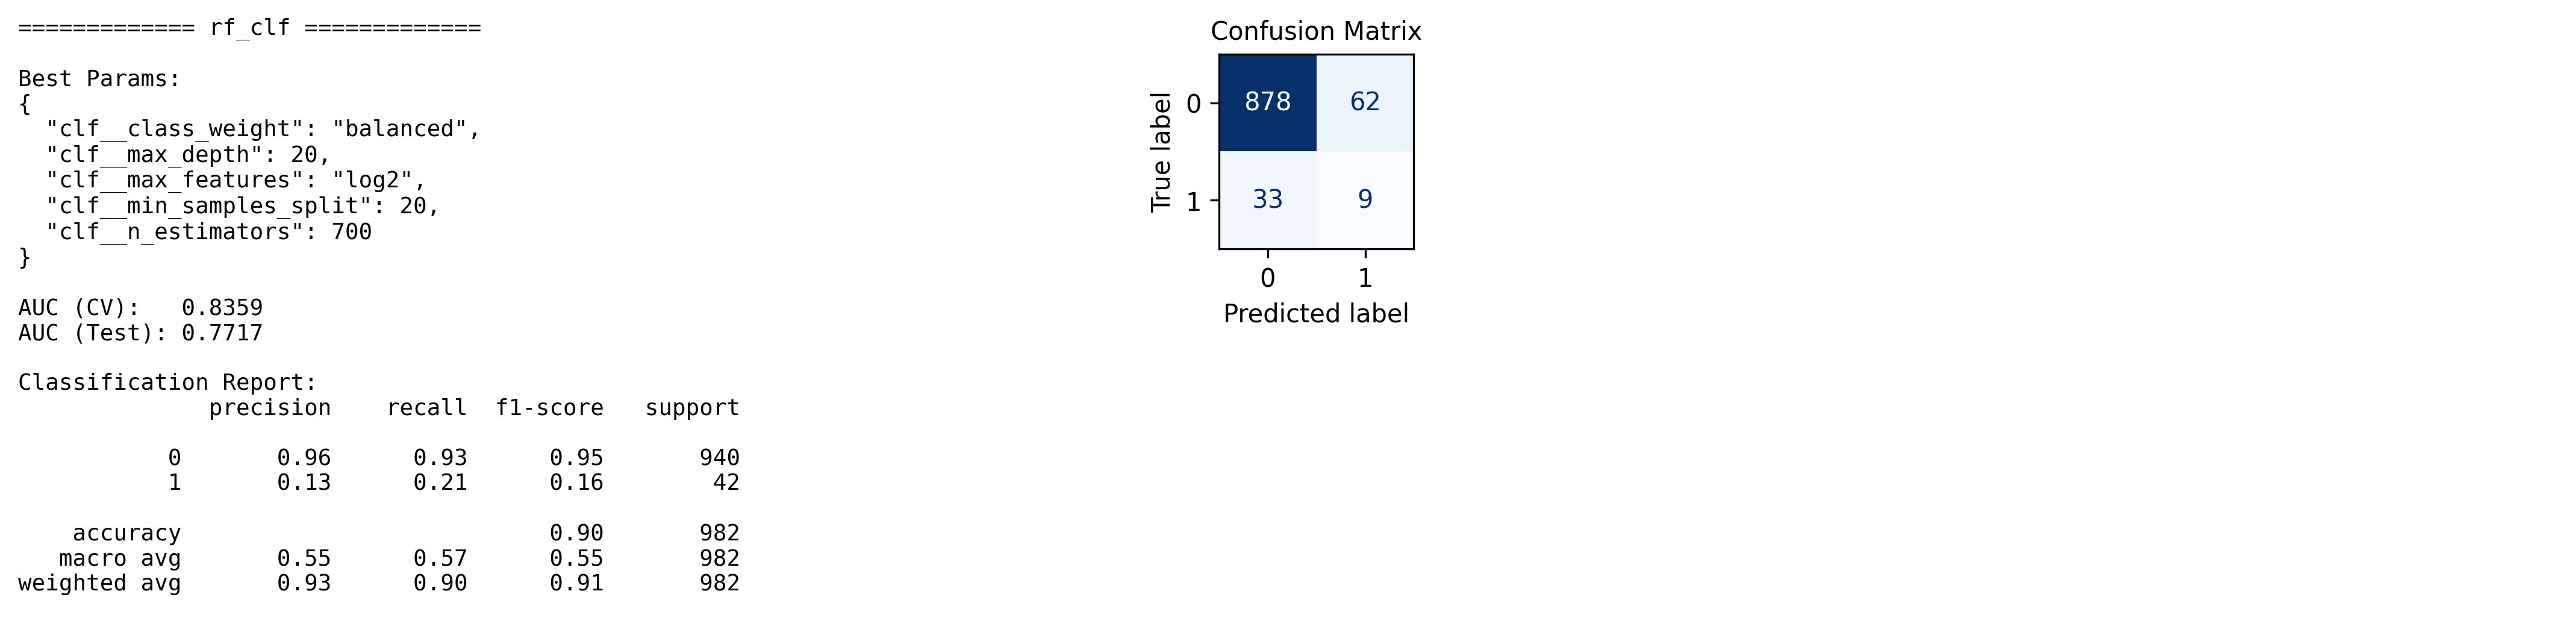


===== Training gb_clf =====

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


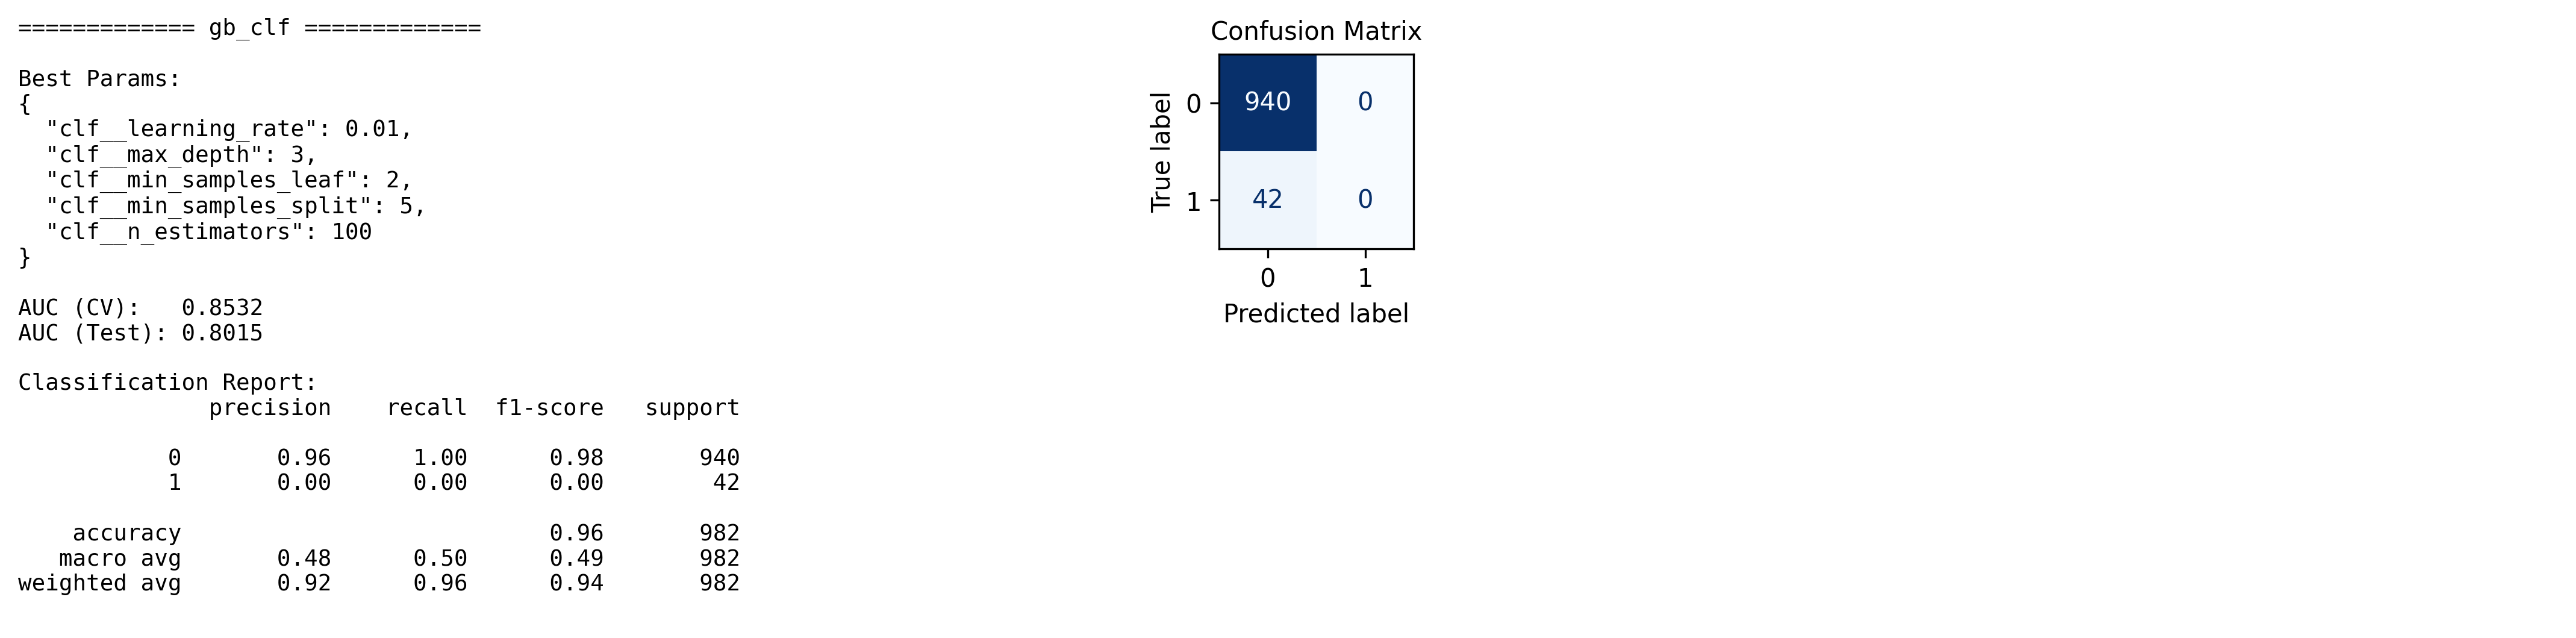


===== Training svc_rbf =====

Fitting 5 folds for each of 25 candidates, totalling 125 fits


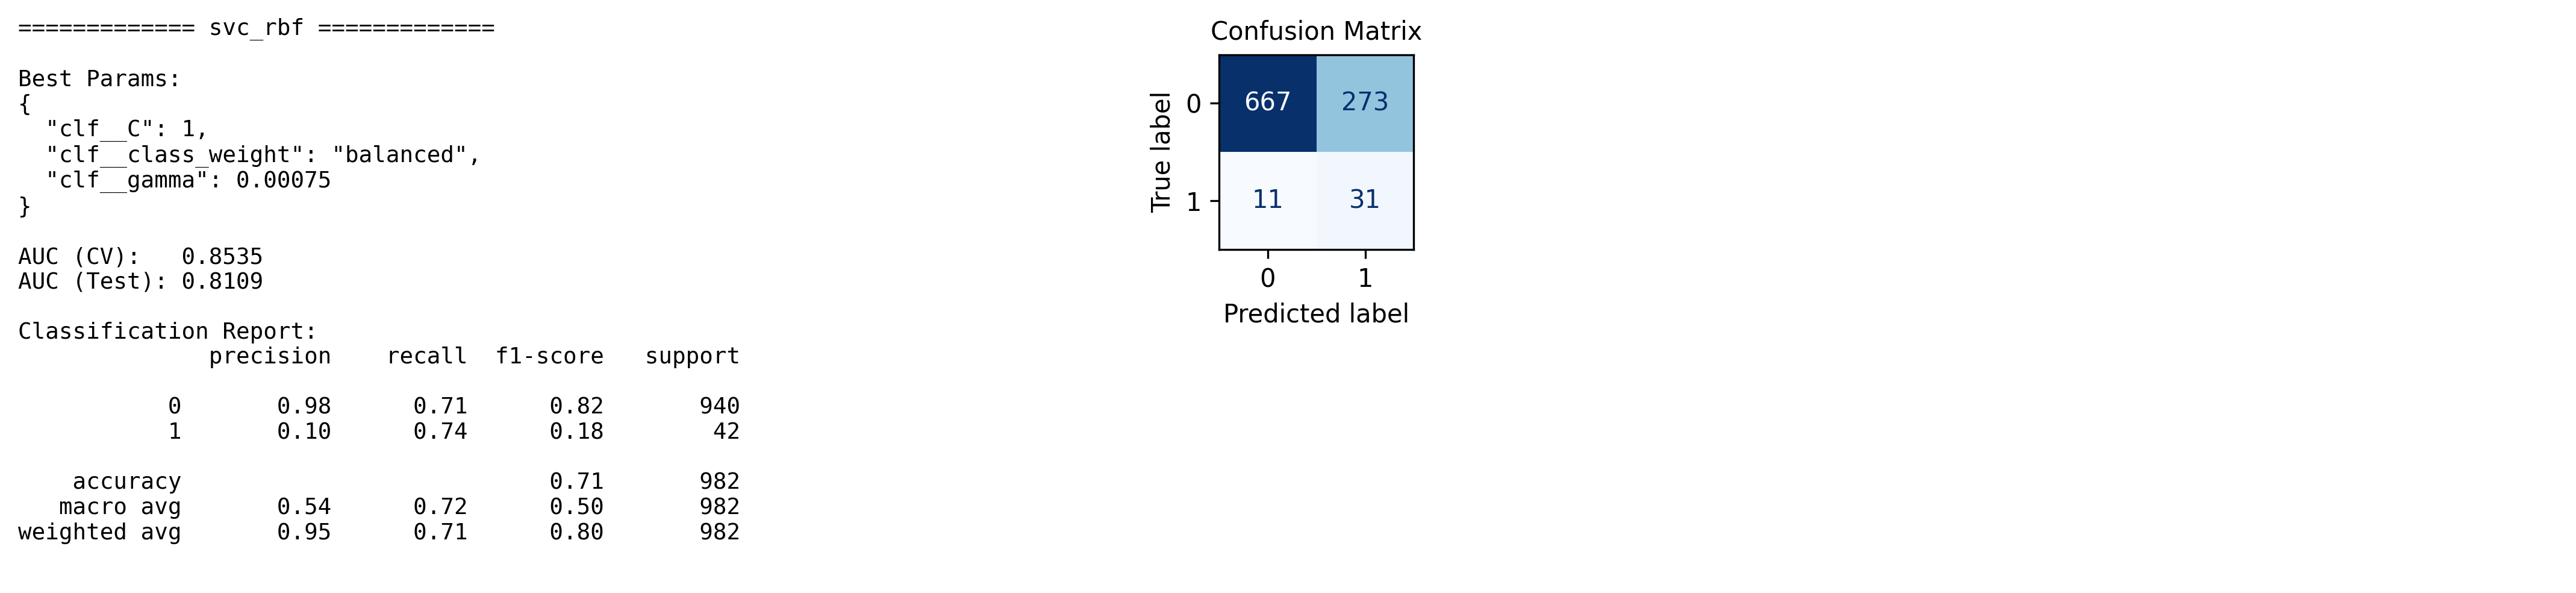


===== Training xgb_clf =====

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


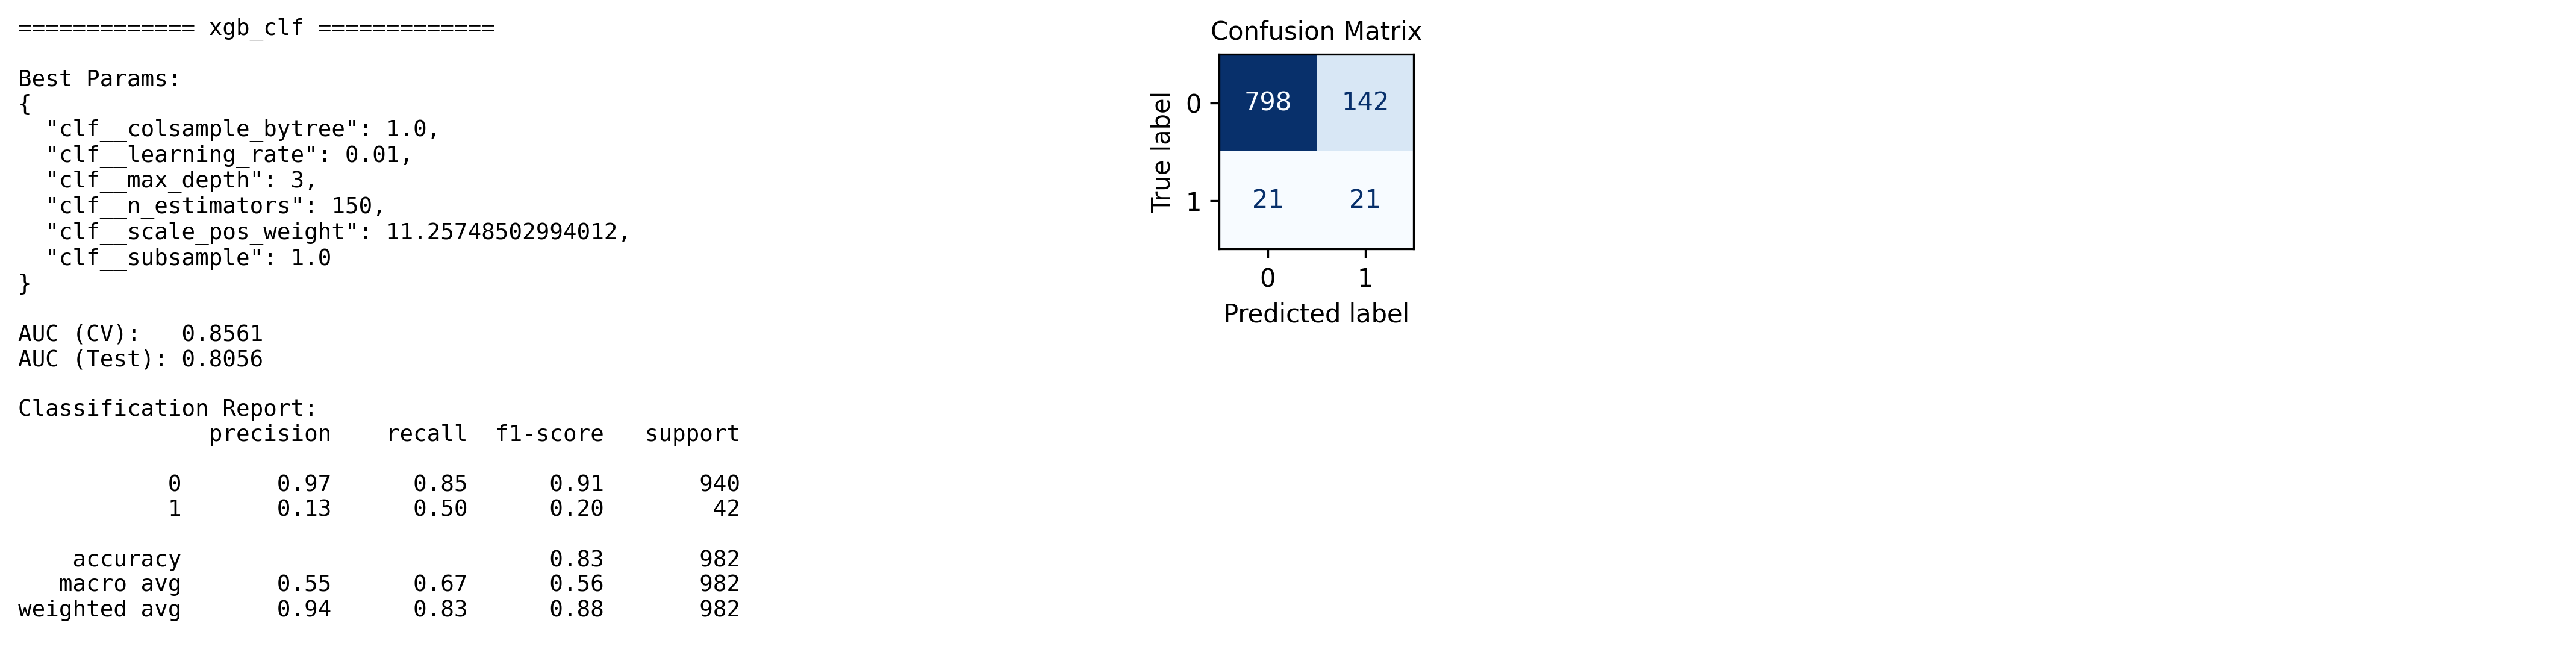

In [80]:
# Run Models v2
prelim_results_run2 = run_multiple_models(models, param_grids, preprocessor,
                            X_train, y_train, X_test, y_test, scoring='roc_auc')

In [81]:
# Model v3
#Fine tune some paramters
pp.pprint(param_grids)

{'gb_clf': {'clf__learning_rate': [0.01, 0.005, 0.001],
            'clf__max_depth': [1, 2, 3, 4],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [4, 5, 6],
            'clf__n_estimators': [100, 200, 300]},
 'log_reg': {'clf__C': [0.01, 0.1, 1, 10],
             'clf__class_weight': ['balanced'],
             'clf__penalty': ['l2']},
 'rf_clf': {'clf__class_weight': ['balanced'],
            'clf__max_depth': [None, 10, 20],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__min_samples_split': [8, 10, 15, 20],
            'clf__n_estimators': [500, 700, 900]},
 'svc_rbf': {'clf__C': [0.5, 1, 2, 5, 7],
             'clf__class_weight': ['balanced'],
             'clf__gamma': [0.01, 0.005, 0.002, 0.001, 0.00075]},
 'xgb_clf': {'clf__colsample_bytree': [0.8, 1.0],
             'clf__learning_rate': [0.01, 0.02, 0.03],
             'clf__max_depth': [2, 3, 4],
             'clf__n_estimators': [150, 200, 250, 300, 400],
         

In [82]:
param_grids['log_reg']['clf__class_weight']=['balanced']
param_grids['log_reg']['clf__C']=[.005, .0075, .01, .02, .03, .05 ]

param_grids['rf_clf']['clf__n_estimators']=[450, 500, 550]
param_grids['rf_clf']['clf__min_samples_split']=[20, 25, 30]

param_grids['gb_clf']['clf__n_estimators']=[75, 100, 125, 150]
param_grids['gb_clf']['clf__learning_rate']=[.009, .01, .02]
param_grids['gb_clf']['clf__max_depth']=[3]
param_grids['gb_clf']['clf__min_samples_split']=[5]

param_grids['svc_rbf']['clf__C']=[.9,1, 1.1, 1.2]
param_grids['svc_rbf']['clf__class_weight']=['balanced']
param_grids['svc_rbf']['clf__gamma']=[.0009, .00075, .0005, .00025, .0001]

param_grids["xgb_clf"]["clf__n_estimators"] = [150, 175, 200] 
param_grids["xgb_clf"]["clf__learning_rate"] = [.01] 
param_grids["xgb_clf"]["clf__scale_pos_weight"] = [imbalance_ratio*0.5, imbalance_ratio, imbalance_ratio*1.5] 


#pp.pprint(param_grids)



===== Training log_reg =====

Fitting 5 folds for each of 6 candidates, totalling 30 fits


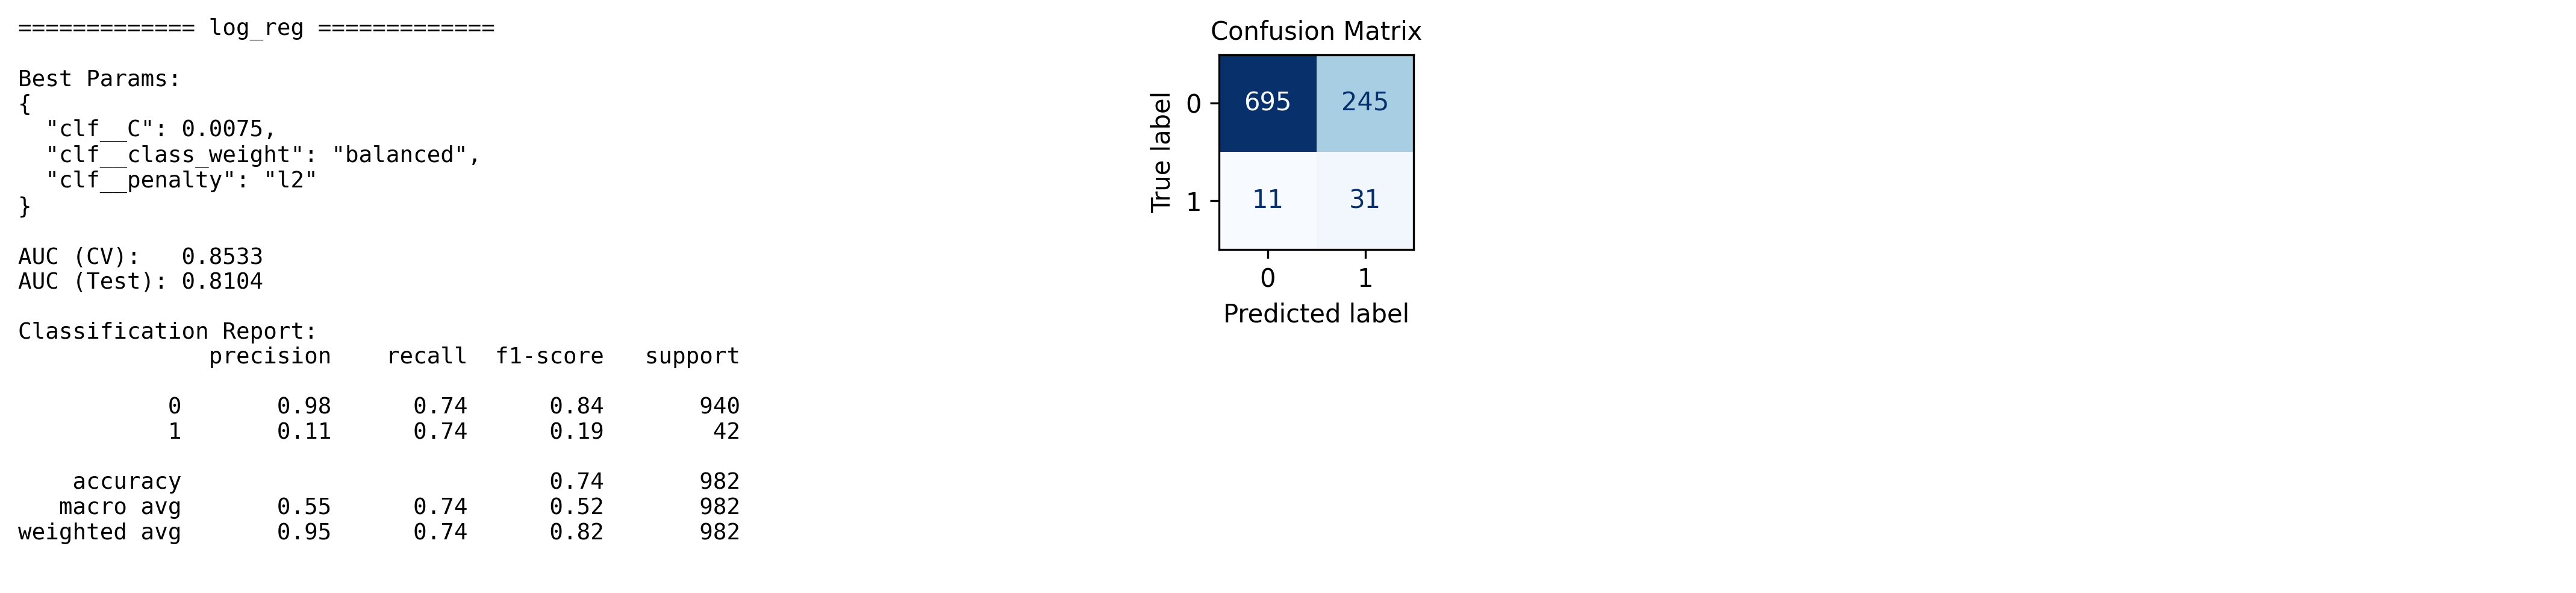


===== Training rf_clf =====

Fitting 5 folds for each of 54 candidates, totalling 270 fits


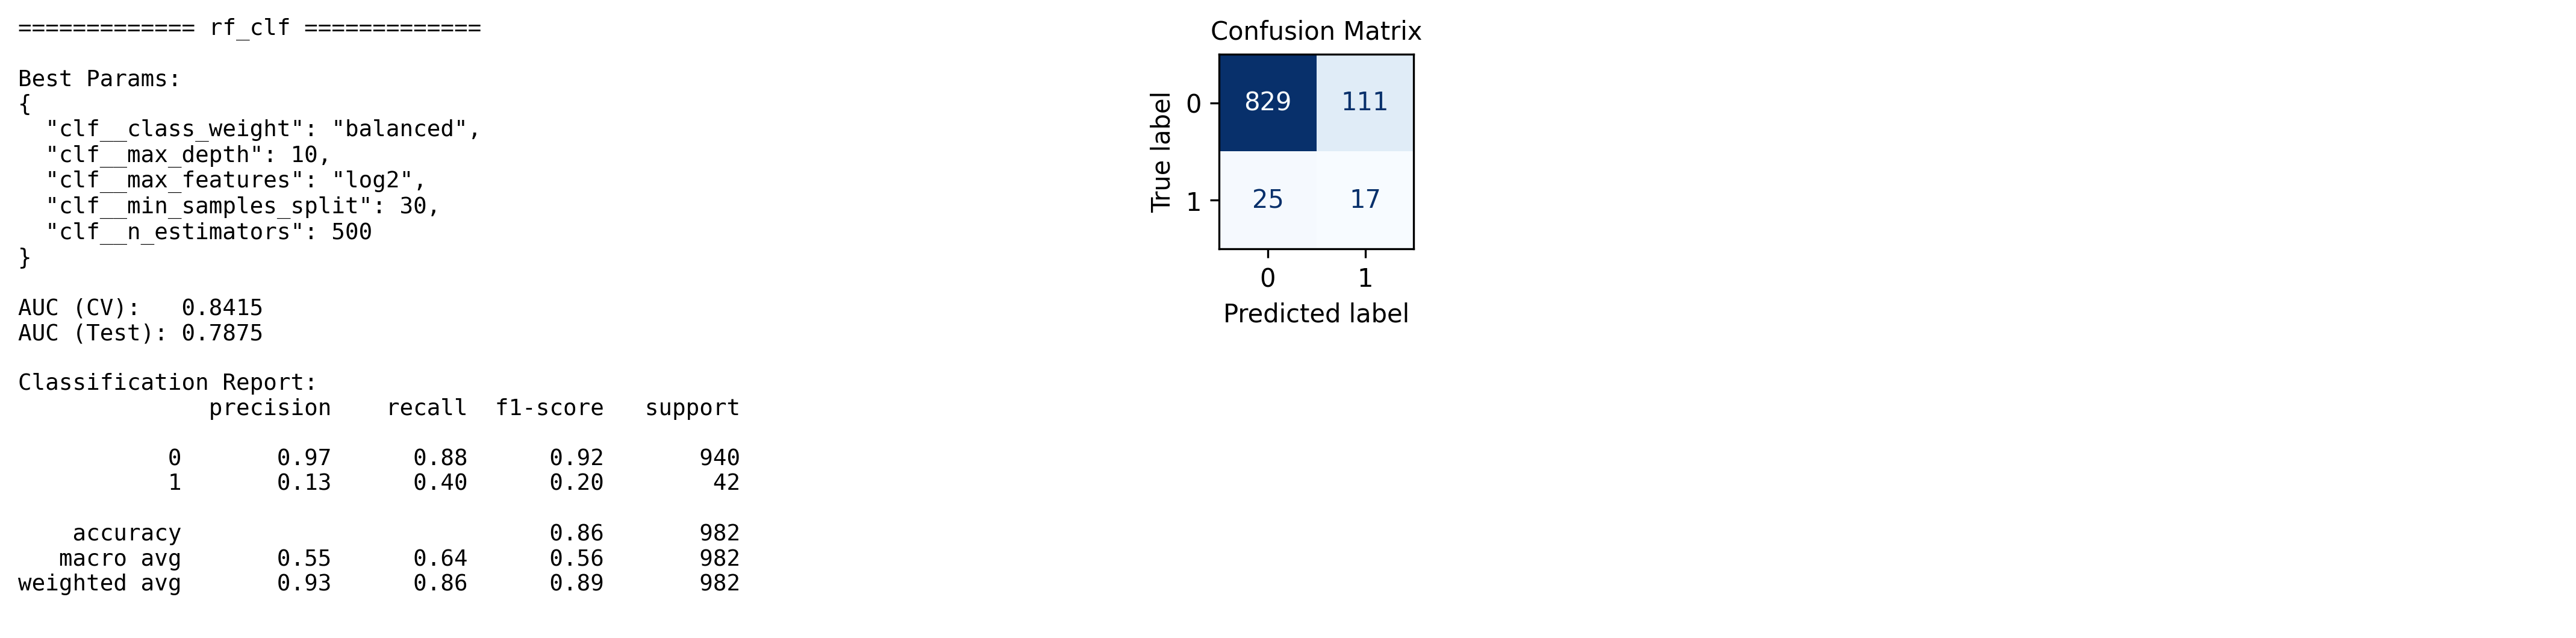


===== Training gb_clf =====

Fitting 5 folds for each of 36 candidates, totalling 180 fits


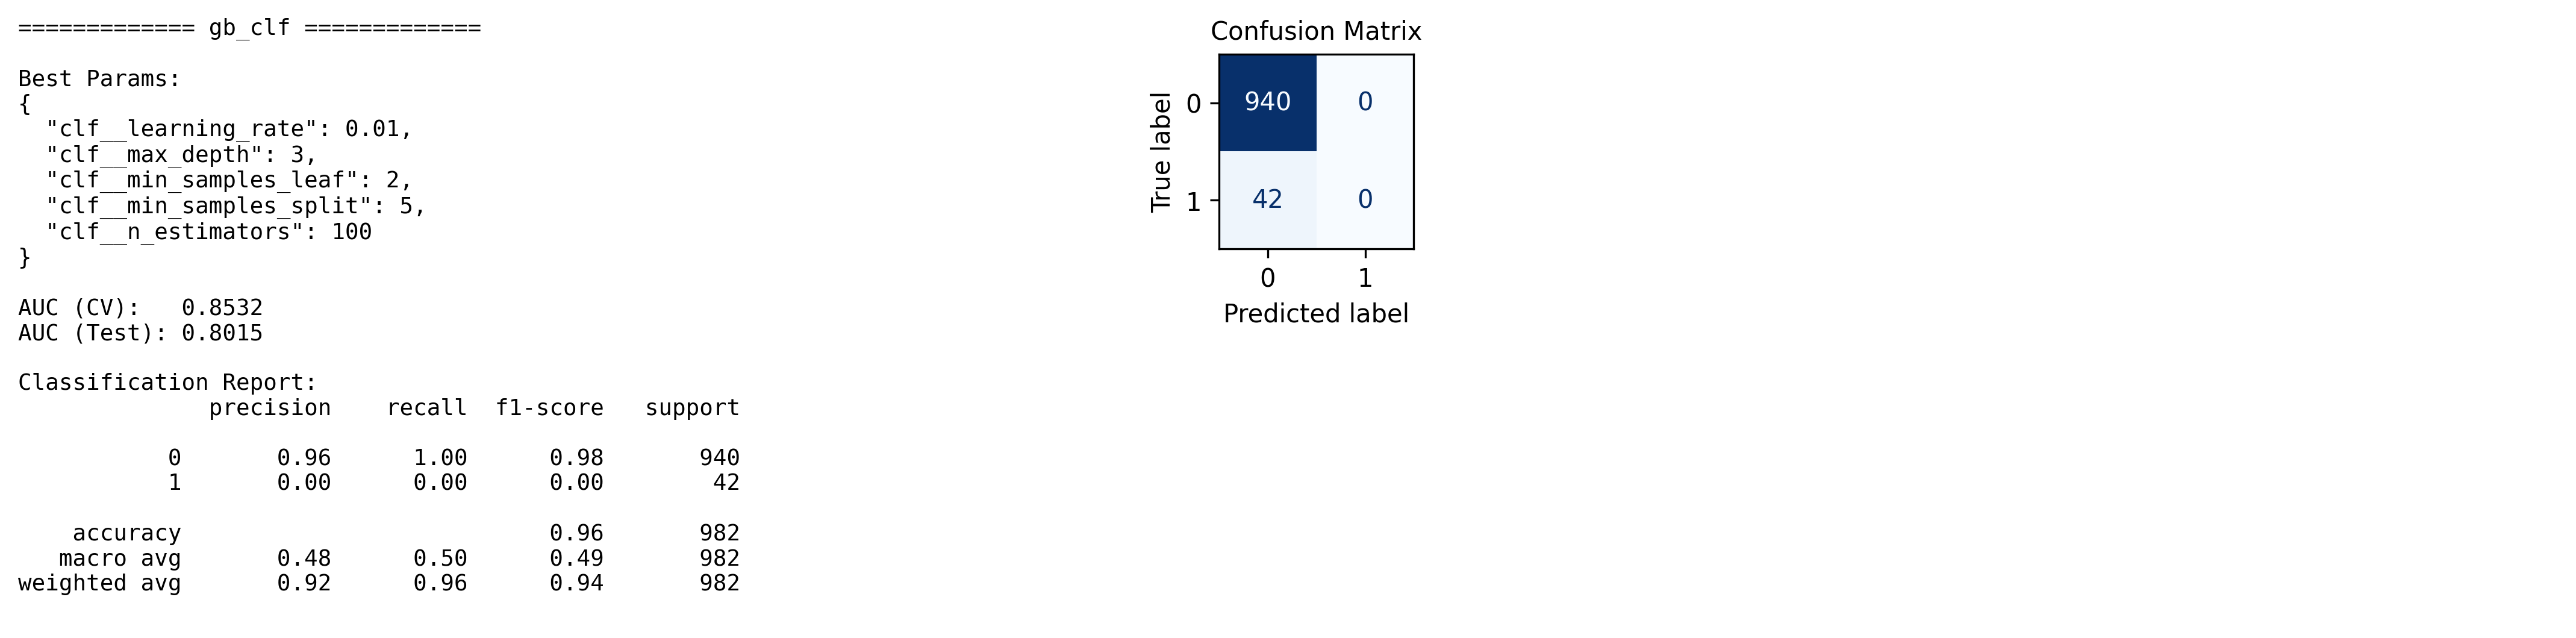


===== Training svc_rbf =====

Fitting 5 folds for each of 20 candidates, totalling 100 fits


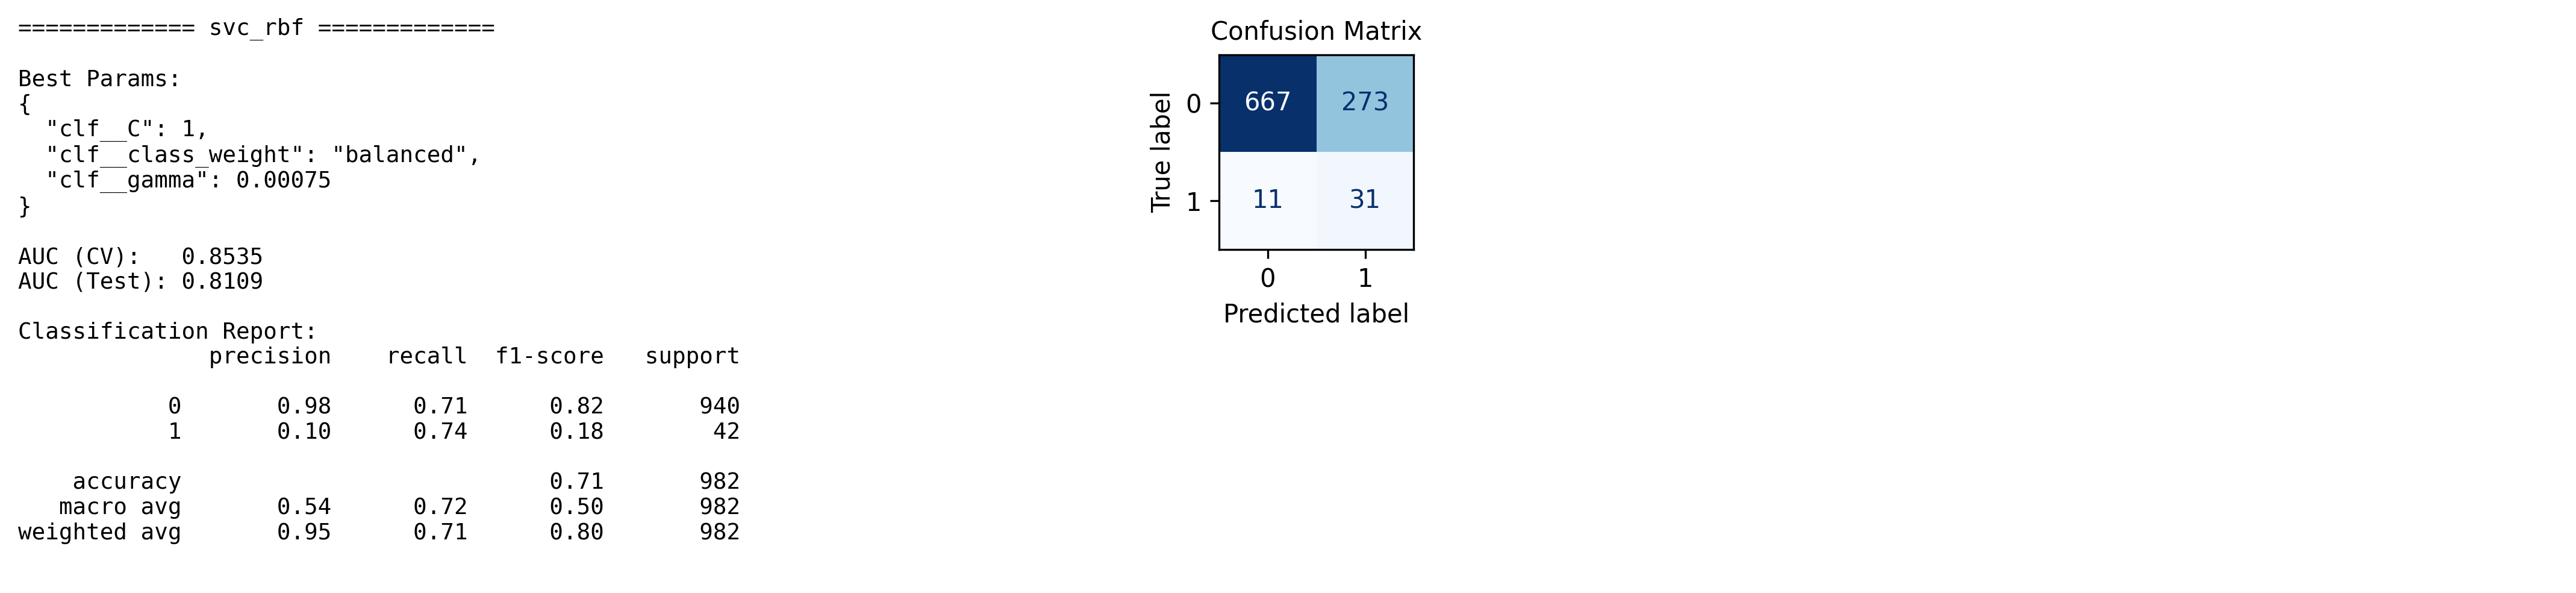


===== Training xgb_clf =====

Fitting 5 folds for each of 108 candidates, totalling 540 fits


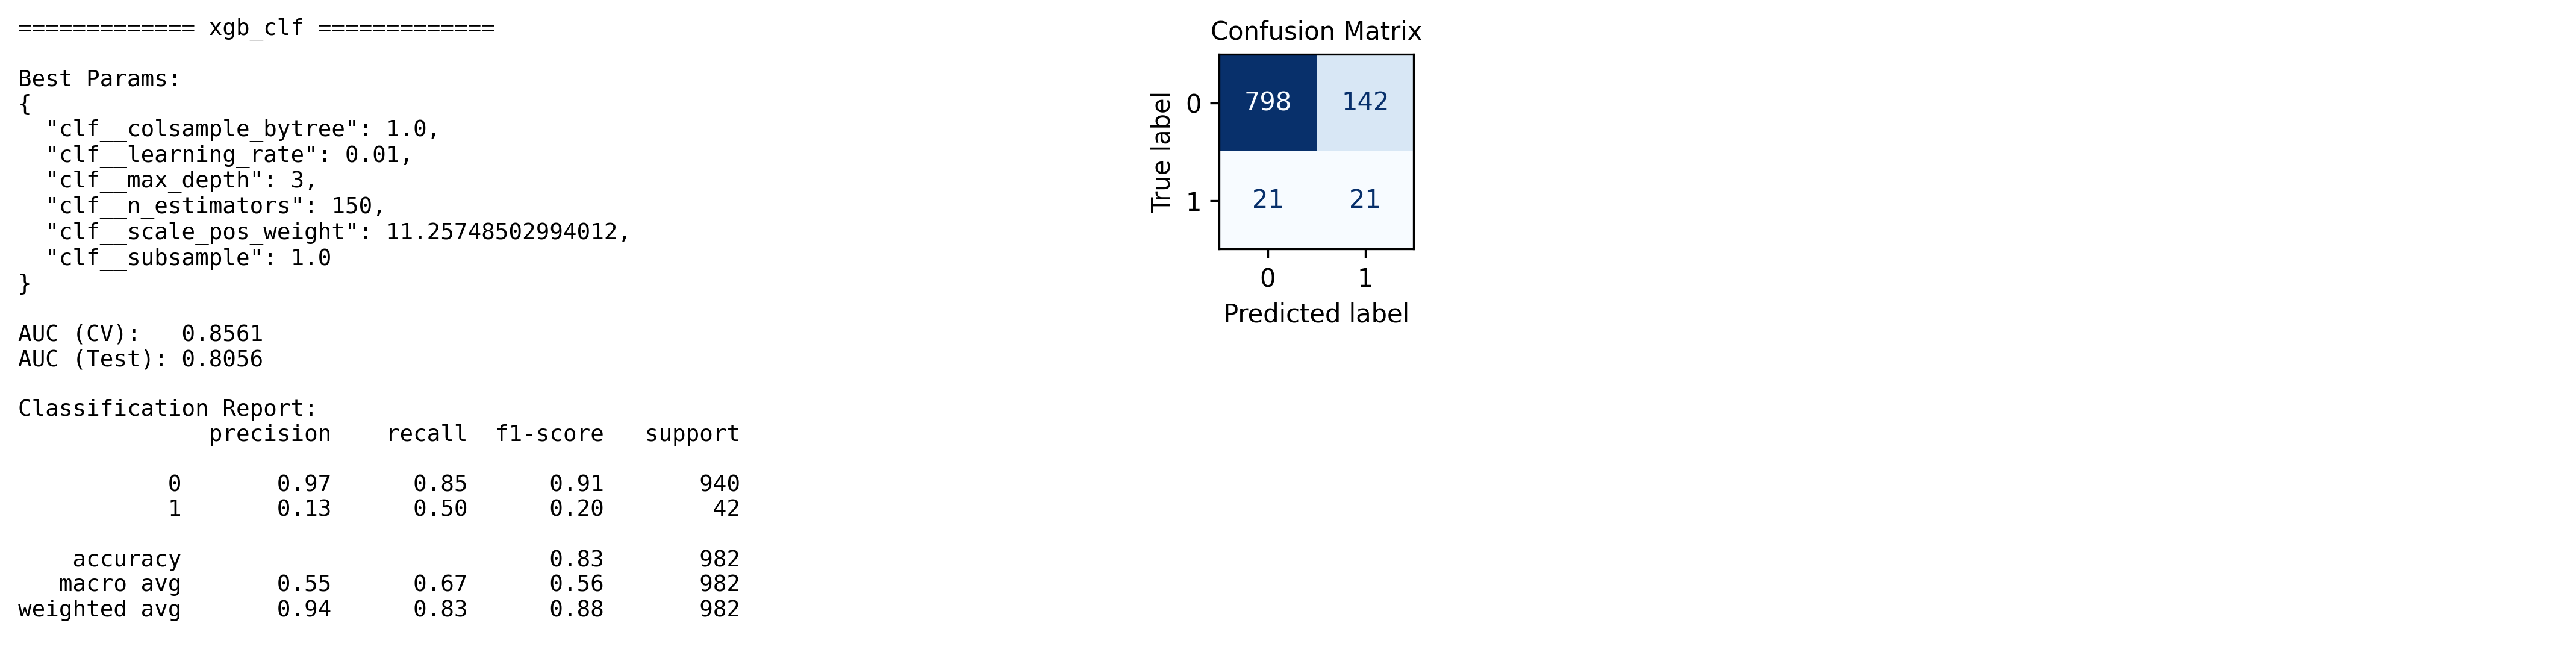

In [83]:
# Run Models v3
prelim_results_run3 = run_multiple_models(models, param_grids, preprocessor,
                            X_train, y_train, X_test, y_test, scoring='roc_auc')


### Observations

Gradient boosting is not able to perform well with the imbalance of the target class. 

### Features Importance Analysis


In [84]:
xgb_pipeline = prelim_results_run3['xgb_clf']['best_model']
best_xgb = xgb_pipeline.named_steps["clf"]

ohe = xgb_pipeline.named_steps["preprocess"].named_transformers_["cat"]

ohe_features_names = ohe.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numerical_cols, ohe_features_names])

importances = best_xgb.feature_importances_

feat_imp = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_imp)

                           feature  importance
0                              age    0.478710
20     smoking_status_never smoked    0.138701
8                 heart_disease_No    0.115310
6                  hypertension_No    0.066180
2                              bmi    0.063761
1                avg_glucose_level    0.051182
14         work_type_Self-employed    0.048397
16            Residence_type_Rural    0.037759
13               work_type_Private    0.000000
19  smoking_status_formerly smoked    0.000000
18          smoking_status_Unknown    0.000000
17            Residence_type_Urban    0.000000
15              work_type_children    0.000000
11                ever_married_Yes    0.000000
12              work_type_Govt_job    0.000000
10                 ever_married_No    0.000000
9                heart_disease_Yes    0.000000
7                 hypertension_Yes    0.000000
5                     gender_Other    0.000000
4                      gender_Male    0.000000
3            

#### Observations
The most important predictors for stroke risk were age, average glucose level, and heart disease status. One-hot encoded categories also contributed, particularly ‘formerly smoked’ and ‘work type: Private’. This aligns with known clinical risk factors and gives confidence the model is learning meaningful patterns rather than noise.
- `age` is the strongest predictor. Stroke risk increases sharply with age
- `smoking_status_never_smoked` shows that people who never smokes have lower risk — indirectly separating them from at-risk groups.
- `heart_disease_NO` and `hypertension_NO` also shows that the absence of those health issues strongly reduces risk of stroke
- Only 8 features show meaningful importance — everything else has zero contribution,meaning the model sees no predictive signal in them
  

### Results Comparison Table

In [107]:
models = ['log_reg', 'gb_clf', 'rf_clf', 'svc_rbf', 'xgb_clf']
runs = [prelim_results_run1, prelim_results_run2, prelim_results_run3]

auc_cv = [ run[m]['grid'].best_score_ for m in models for run in runs ]
auc_test = [ run[m]['test_metrics']['test_auc'] for m in models for run in runs ]
recall = [ run[m]['test_metrics']['recall'] for m in models for run in runs ]
precision = [ run[m]['test_metrics']['precision'] for m in models for run in runs ]
f1 = [ run[m]['test_metrics']['f1'] for m in models for run in runs ]

results_dict = {
    "Model": [m for m in models for _ in runs],
    "Run": [f"R{i+1}" for m in models for i in range(len(runs))],
    "AUC CV": auc_cv,
    "AUC Test": auc_test,
    "Recall": recall,
    "Precision": precision,
    "F1": f1
}

comparison_tb = pd.DataFrame(results_dict)
#comparison_tb.round(3)

df_pretty = comparison_tb.copy().set_index(["Model", "Run"]).round(3)
df_pretty

AUC CV  AUC Test  Recall  Precision     F1
Model   Run                                            
log_reg R1    0.854     0.812   0.000      0.000  0.000
        R2    0.853     0.811   0.738      0.115  0.199
        R3    0.853     0.810   0.738      0.112  0.195
gb_clf  R1    0.853     0.801   0.000      0.000  0.000
        R2    0.853     0.801   0.000      0.000  0.000
        R3    0.853     0.801   0.000      0.000  0.000
rf_clf  R1    0.830     0.773   0.071      0.130  0.092
        R2    0.836     0.772   0.214      0.127  0.159
        R3    0.842     0.787   0.405      0.133  0.200
svc_rbf R1    0.853     0.811   0.738      0.103  0.181
        R2    0.854     0.811   0.738      0.102  0.179
        R3    0.854     0.811   0.738      0.102  0.179
xgb_clf R1    0.856     0.805   0.000      0.000  0.000
        R2    0.856     0.806   0.500      0.129  0.205
        R3    0.856     0.806   0.500      0.129  0.205

### Observations

- AUC (CV) is consistent across models (all around 0.84-0.86); meaning the models learn roughly the same underlying structure. The dataset seems to be the limiting factor, not the algorithms.
- Recall varies meaningfully - will need to adjust with threshold tuning
- precision is consistenly low - this is expected when the minority class is ~ 5%, higher recall will drop precision

#### Conclusions
- best consisten model class: SVC (RBF Kernel); highest recall + stable AUC
- Logistic Regression performs surprisingly well; shows the dataset is simple and linearly separable to some extent
- XGBoost does not outperform SVC
- GradientBoosting fails entirely

# Threshold Tuning


### Linear Regression Threshold tuning

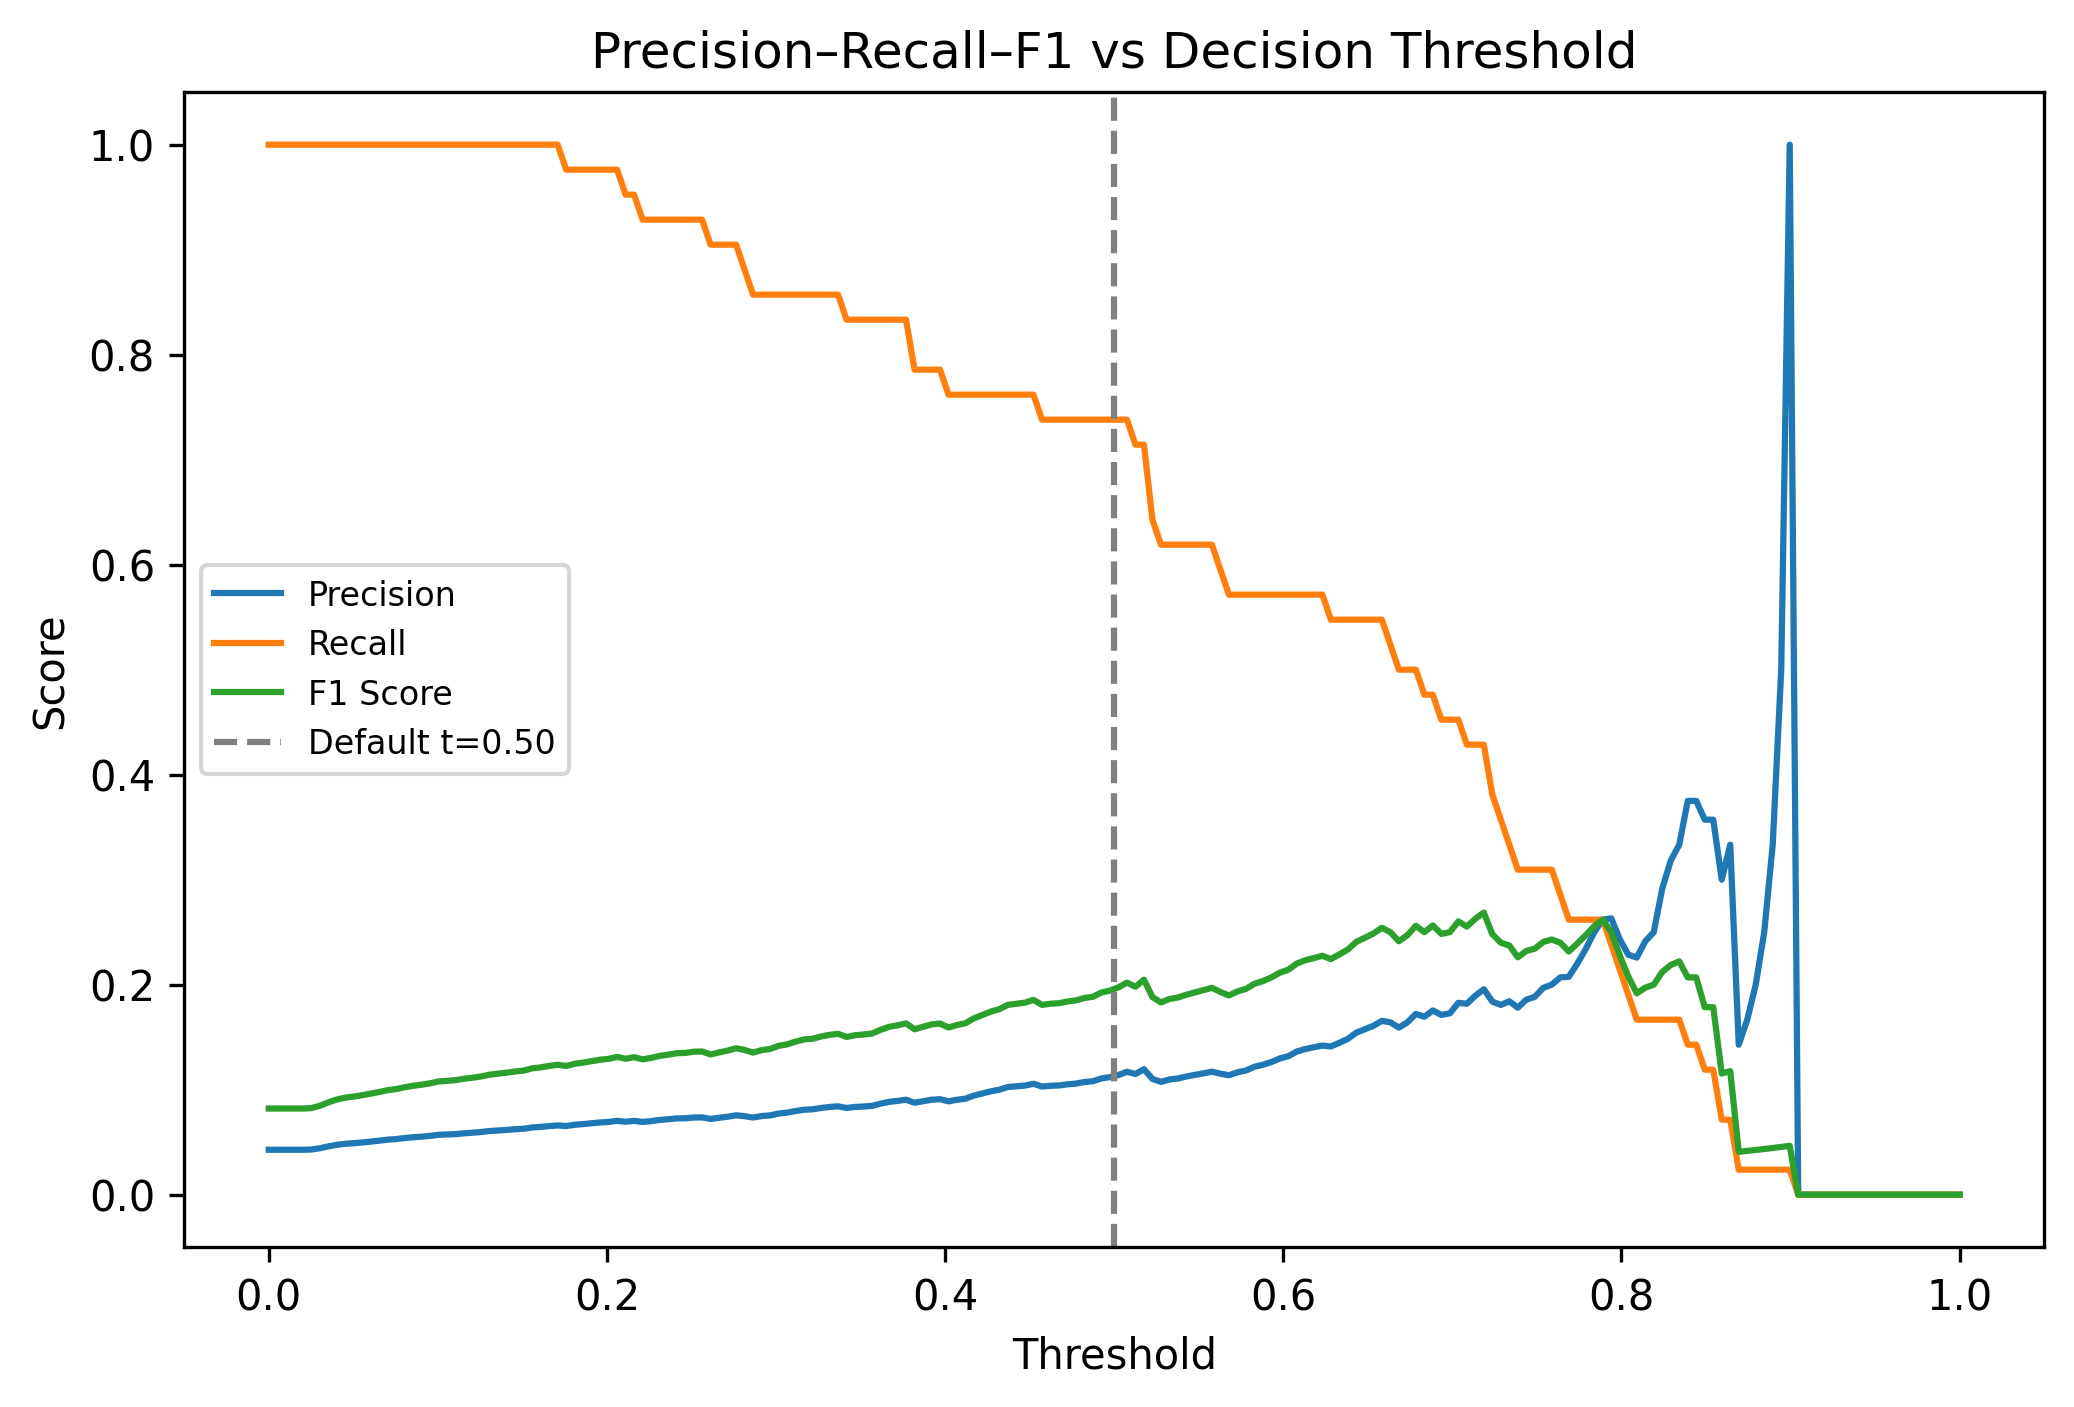

In [108]:
# Tune LinearRegression
best_lr = results['log_reg']['best_model']
y_proba = best_lr.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)


In [109]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)

Best threshold (F1): 0.7185929648241206
Best F1 score: 0.26865671641791045

Best threshold (F2): 0.6582914572864321
Best F2 score: 0.3745928338762215

Best threshold (F3): 0.507537688442211
Best F3 score: 0.4821150855365474


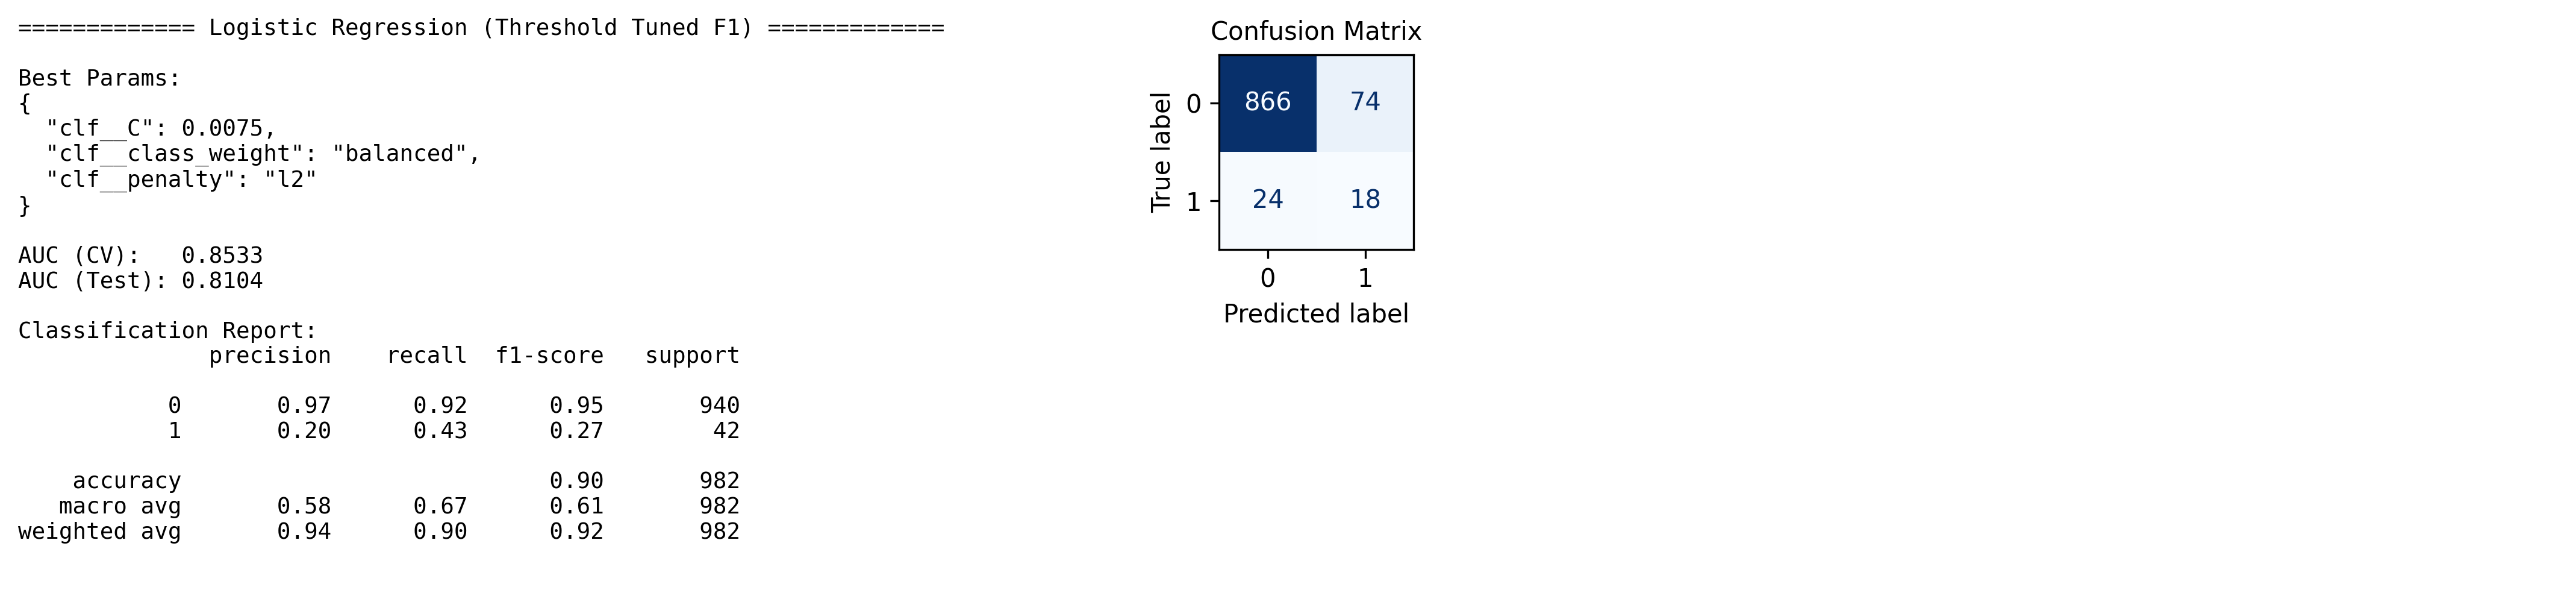

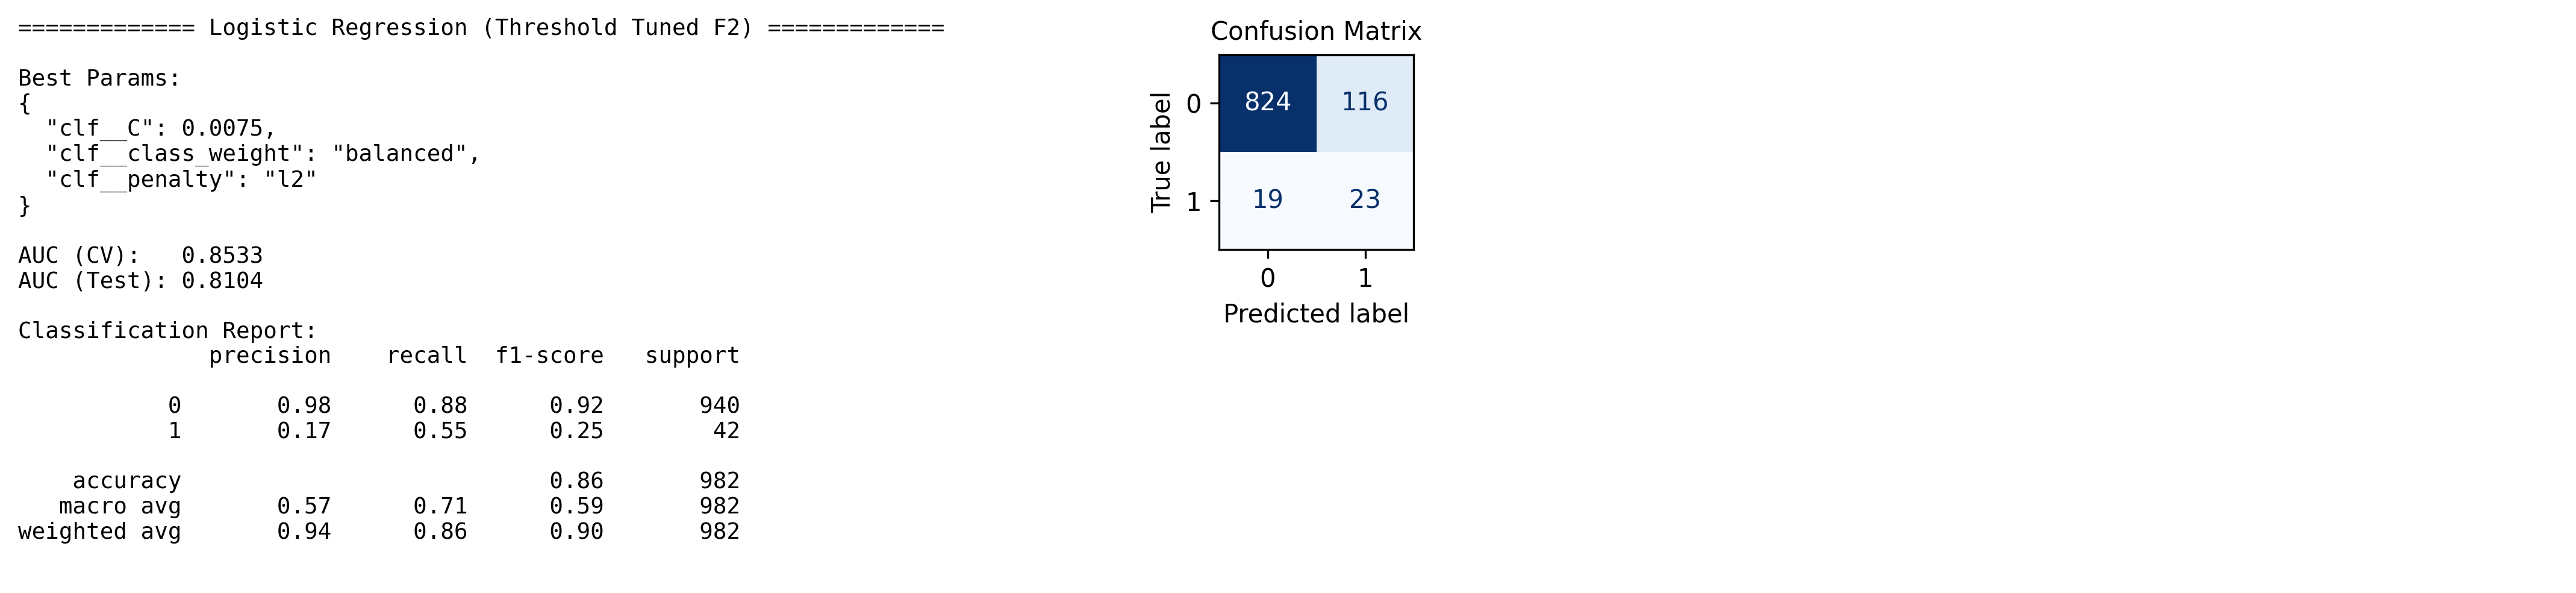

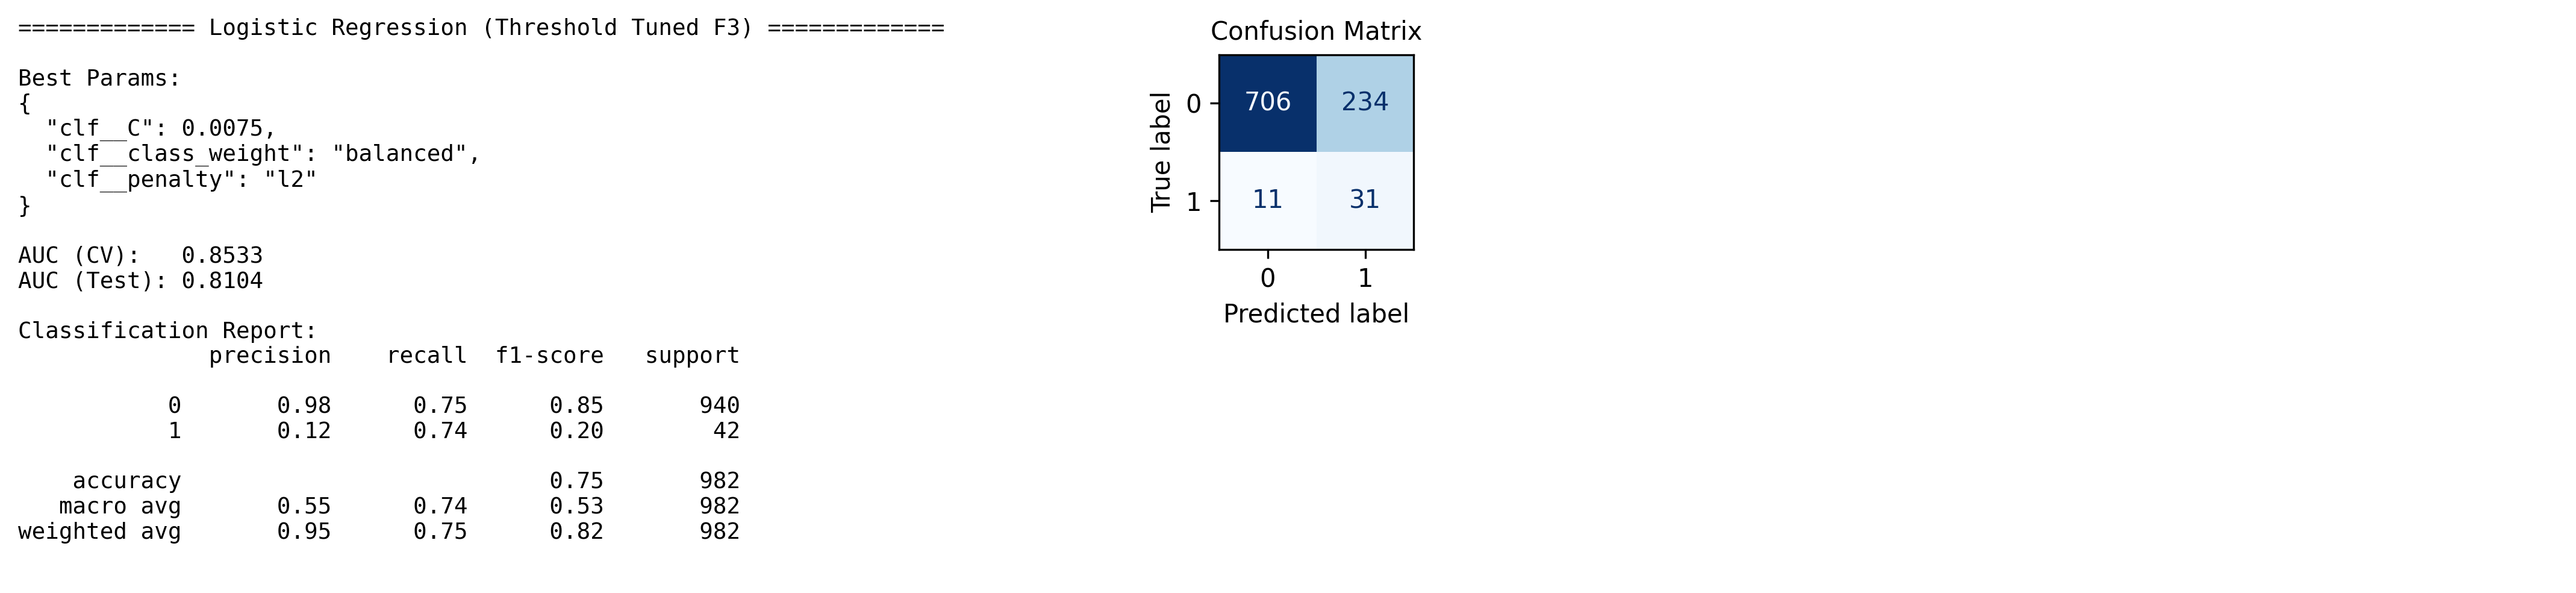

In [111]:
# Evaluate at F1
lr_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="Logistic Regression (Threshold Tuned F1)",
    grid=prelim_results_run3['log_reg']['grid'],
    metrics=lr_th_metrics_f1,
    cm=lr_th_metrics_f1['confusion_matrix'],
    best_model=best_lr
)

# Evaluate at F2
lr_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="Logistic Regression (Threshold Tuned F2)",
    grid=prelim_results_run3['log_reg']['grid'],
    metrics=lr_th_metrics_f2,
    cm=lr_th_metrics_f2['confusion_matrix'],
    best_model=best_lr
)

# Evaluate at F3
lr_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="Logistic Regression (Threshold Tuned F3)",
    grid=prelim_results_run3['log_reg']['grid'],
    metrics=lr_th_metrics_f3,
    cm=lr_th_metrics_f3['confusion_matrix'],
    best_model=best_lr
)


### Gradient Boosting Threshold tuning

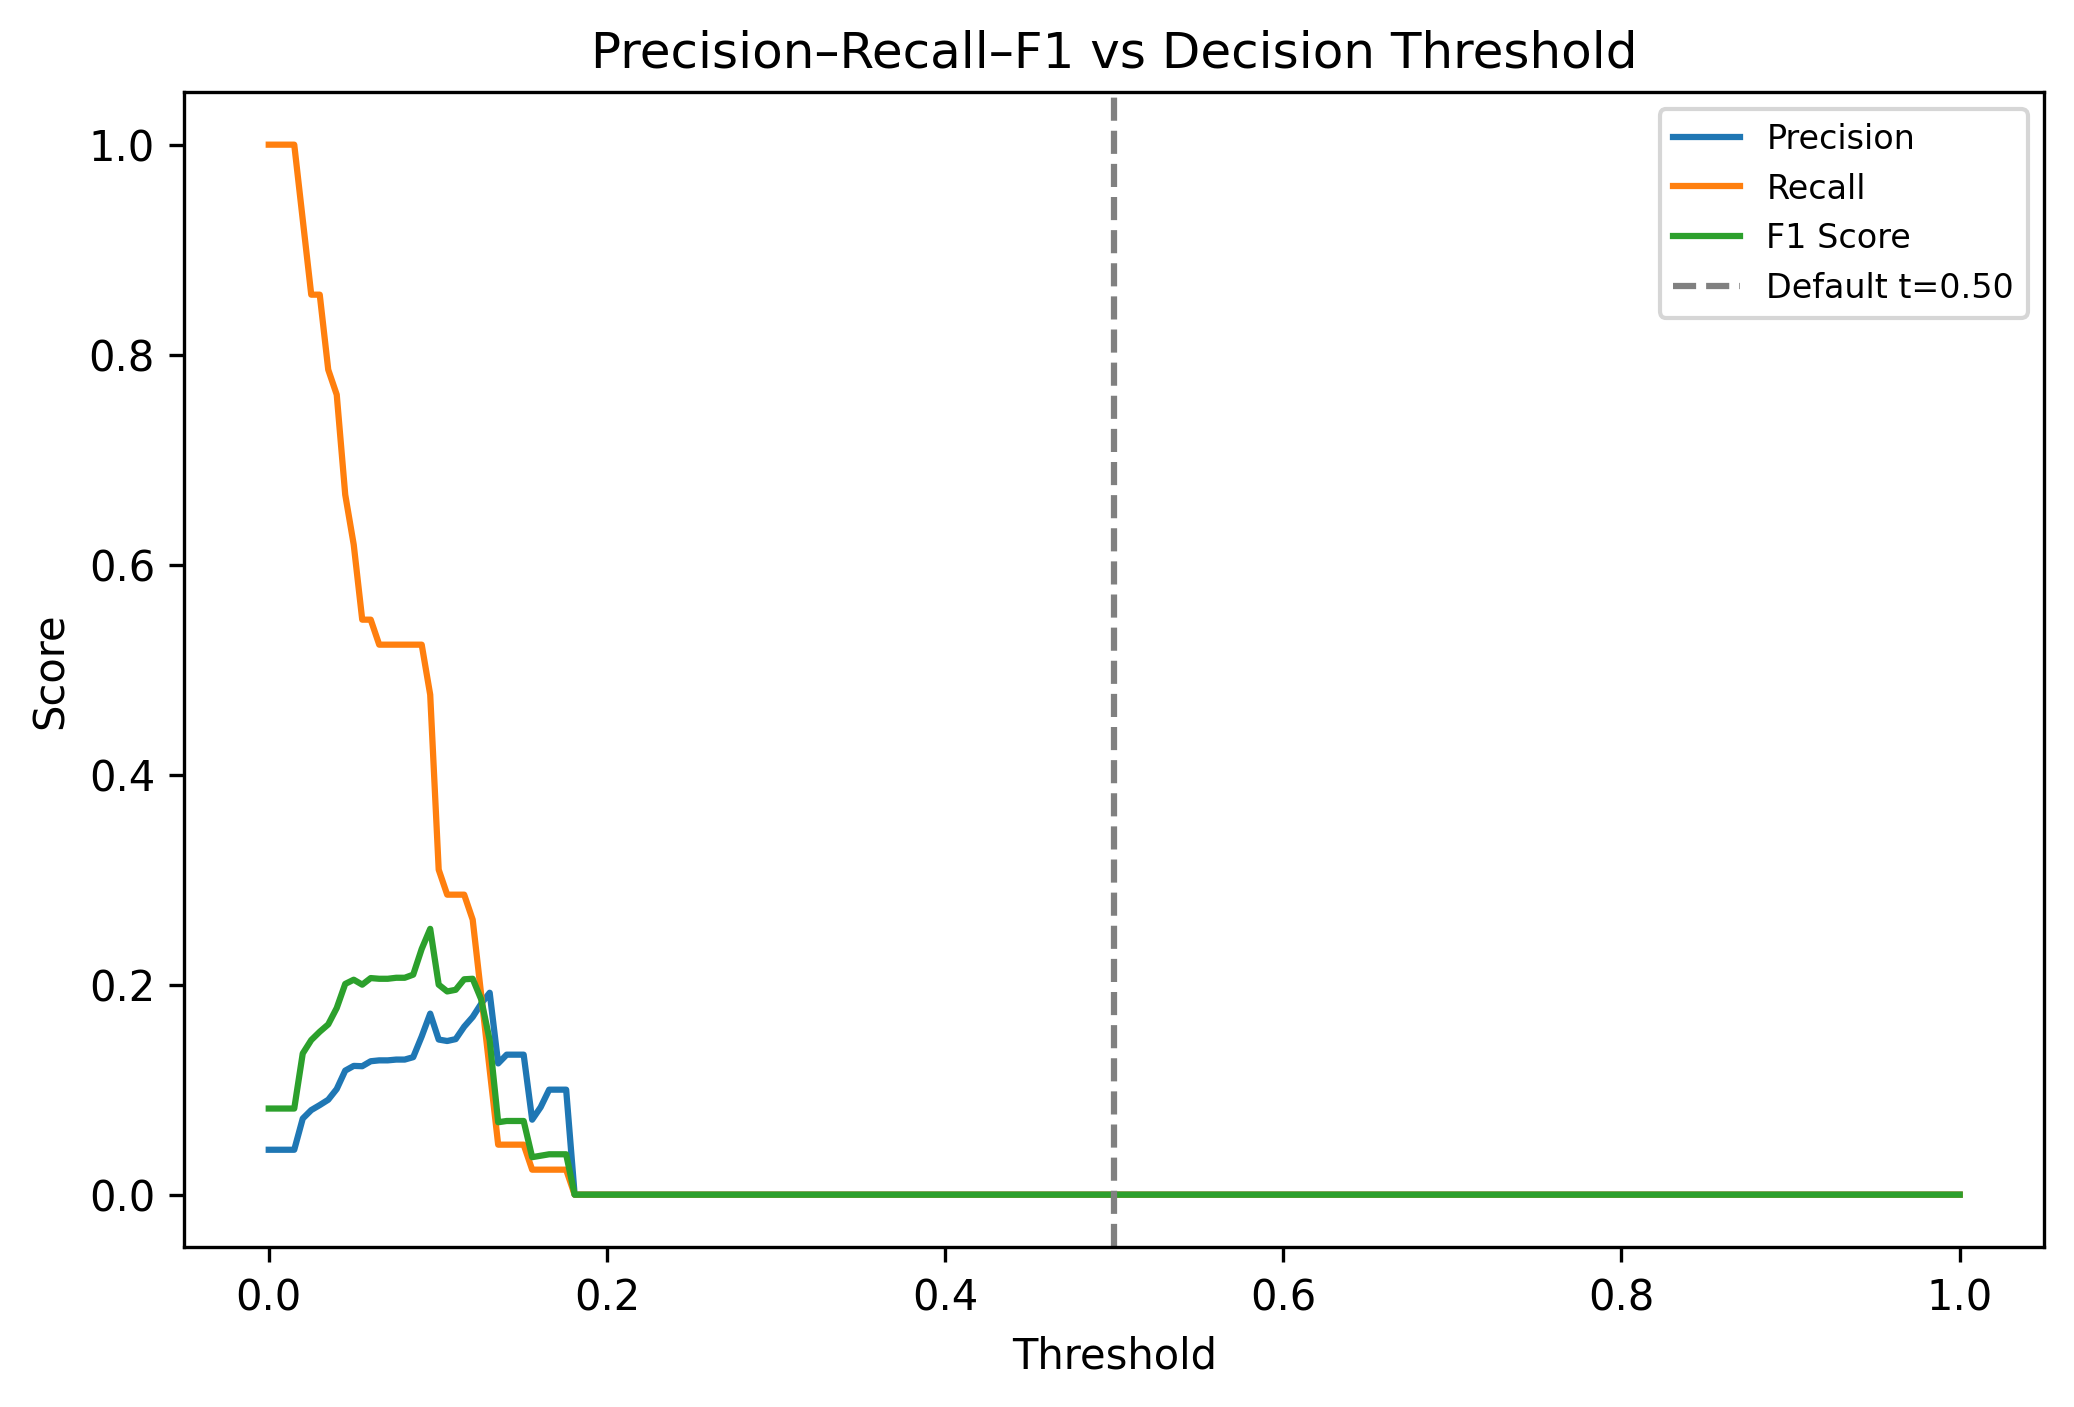

In [112]:
# Tune GradientBoosting
best_gb = results['gb_clf']['best_model']
y_proba = best_gb.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)

In [113]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)

Best threshold (F1): 0.09547738693467336
Best F1 score: 0.25316455696202533

Best threshold (F2): 0.09547738693467336
Best F2 score: 0.352112676056338

Best threshold (F3): 0.04020100502512563
Best F3 score: 0.45977011494252873


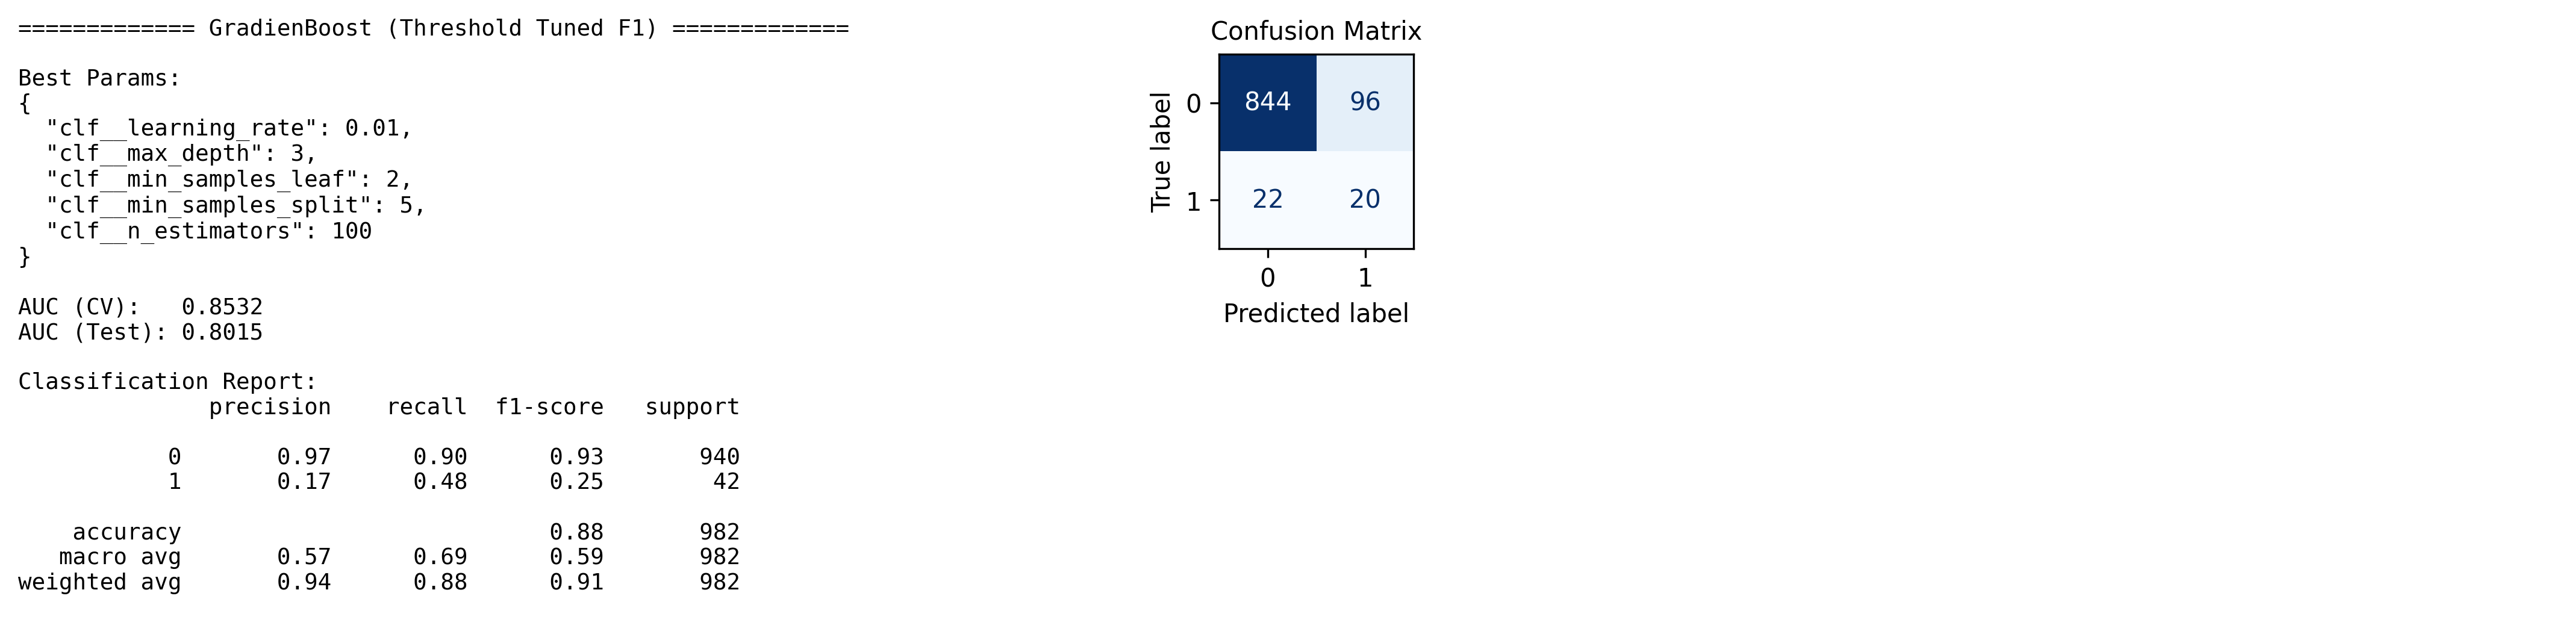

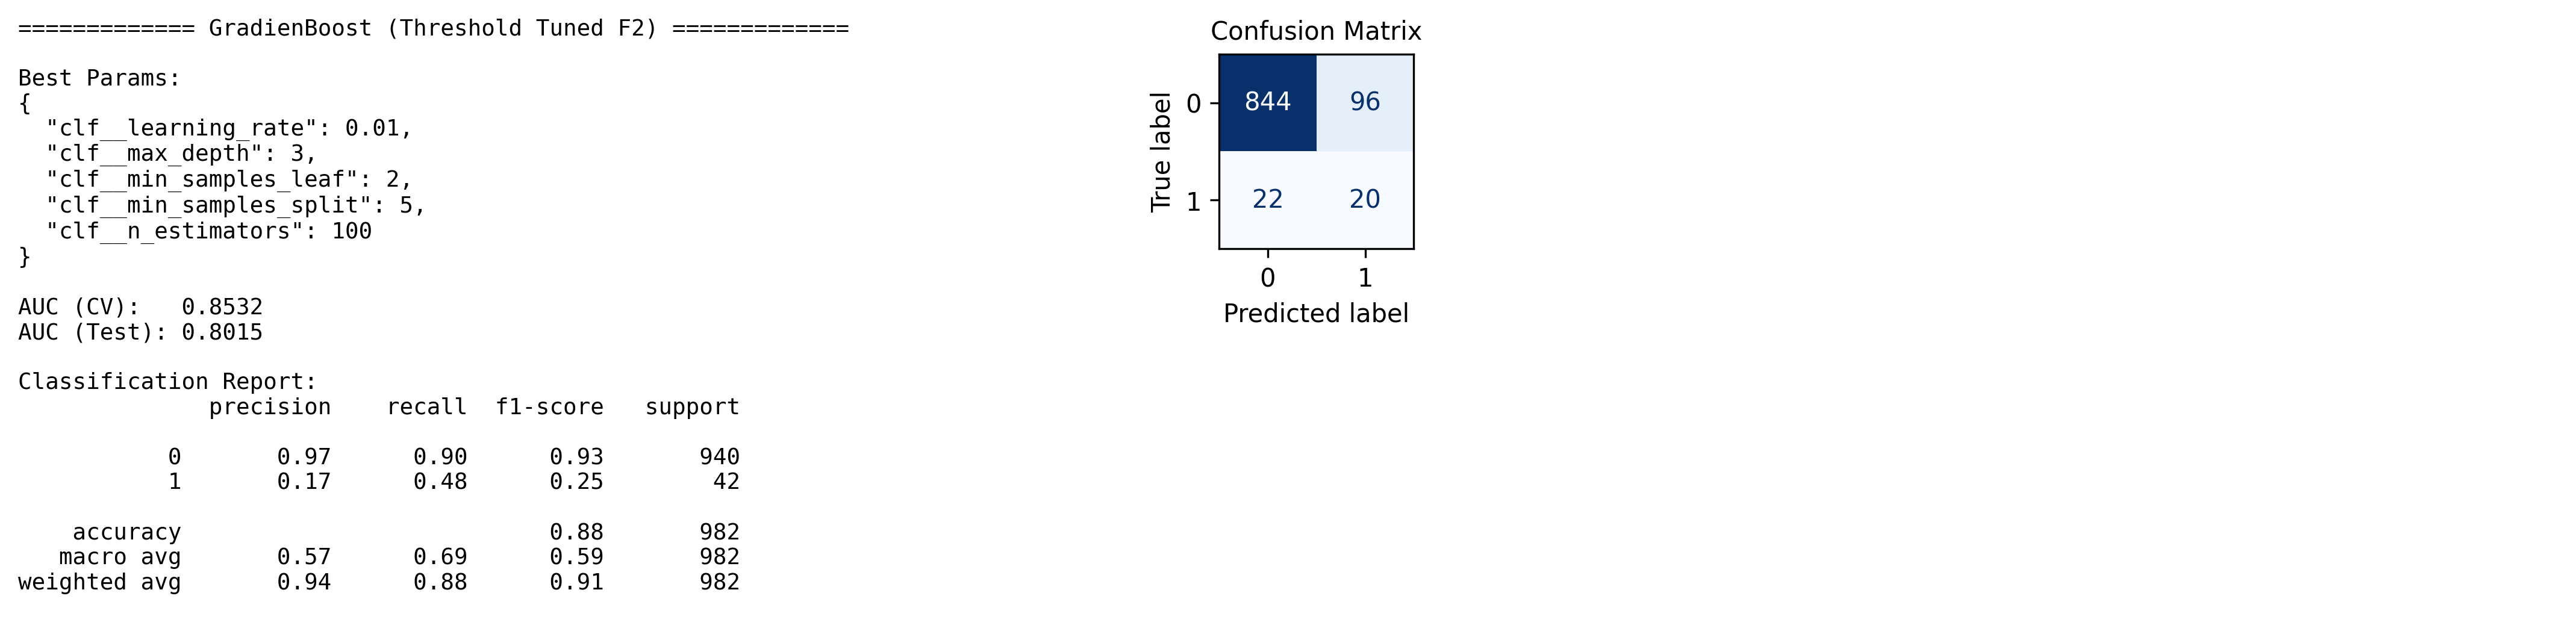

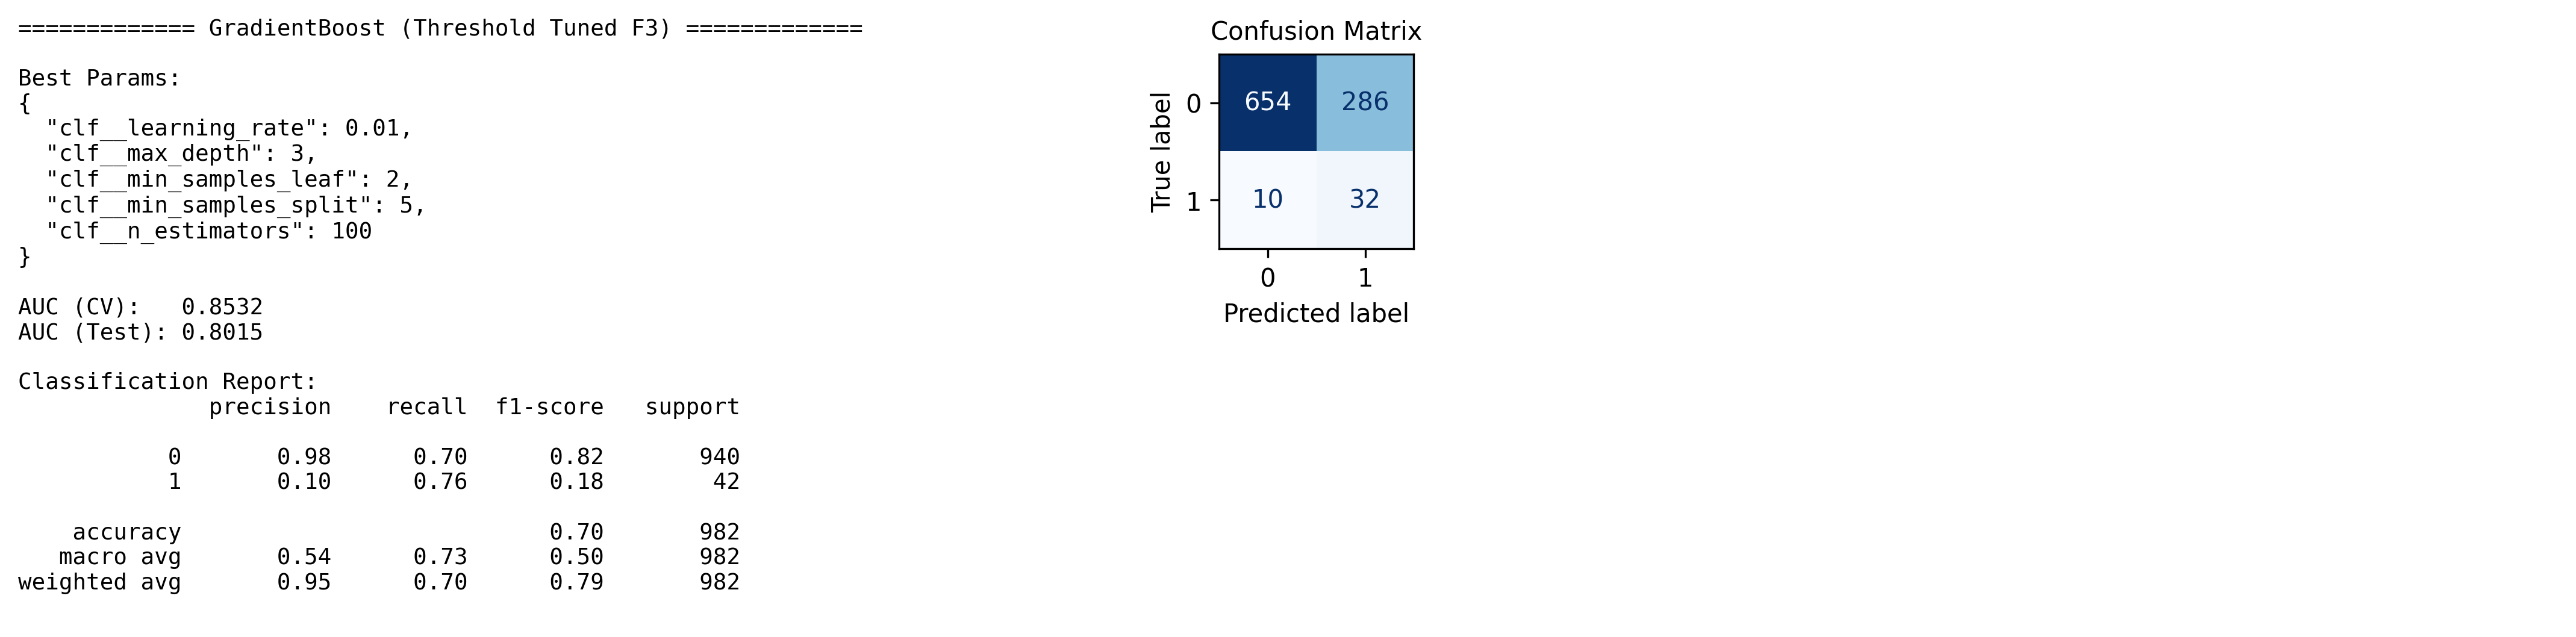

In [114]:
# Evaluate at F1
gb_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="GradienBoost (Threshold Tuned F1)",
    grid=prelim_results_run3['gb_clf']['grid'],
    metrics=gb_th_metrics_f1,
    cm=gb_th_metrics_f1['confusion_matrix'],
    best_model=best_gb
)

# Evaluate at F2
gb_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="GradienBoost (Threshold Tuned F2)",
    grid=prelim_results_run3['gb_clf']['grid'],
    metrics=gb_th_metrics_f2,
    cm=gb_th_metrics_f2['confusion_matrix'],
    best_model=best_gb
)

# Evaluate at F3
gb_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="GradientBoost (Threshold Tuned F3)",
    grid=prelim_results_run3['gb_clf']['grid'],
    metrics=gb_th_metrics_f3,
    cm=gb_th_metrics_f3['confusion_matrix'],
    best_model=best_gb
)

### Random Forest Threshold tuning

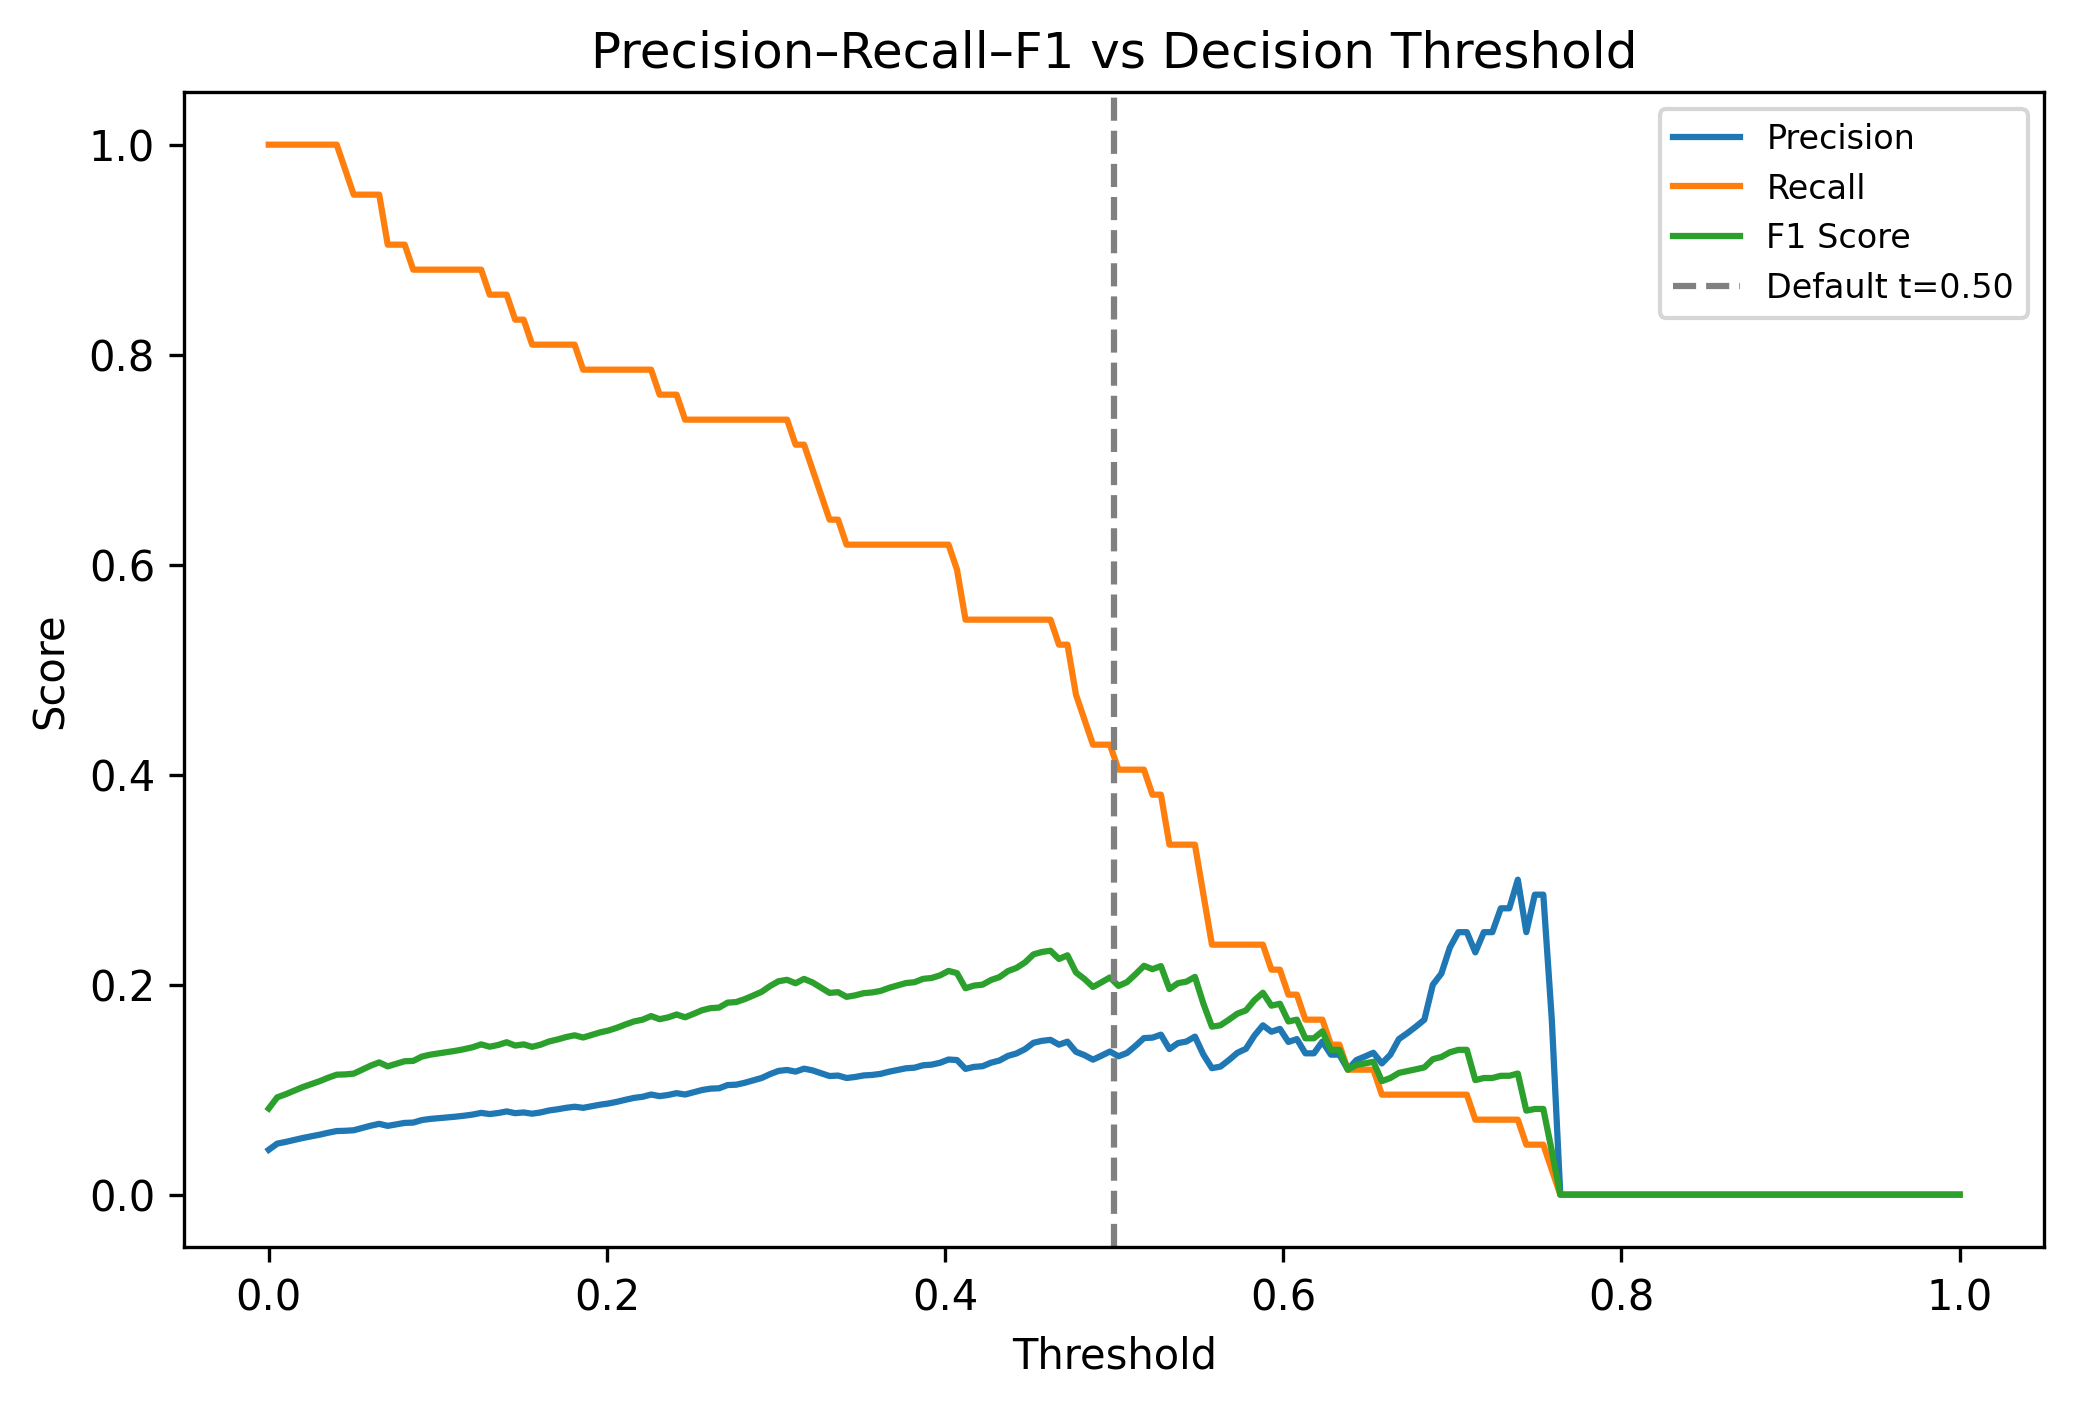

In [115]:
best_rf = results['rf_clf']['best_model']
y_proba = best_rf.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)

In [116]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)

Best threshold (F1): 0.4623115577889447
Best F1 score: 0.23232323232323232

Best threshold (F2): 0.3065326633165829
Best F2 score: 0.3613053613053613

Best threshold (F3): 0.3065326633165829
Best F3 score: 0.48513302034428796


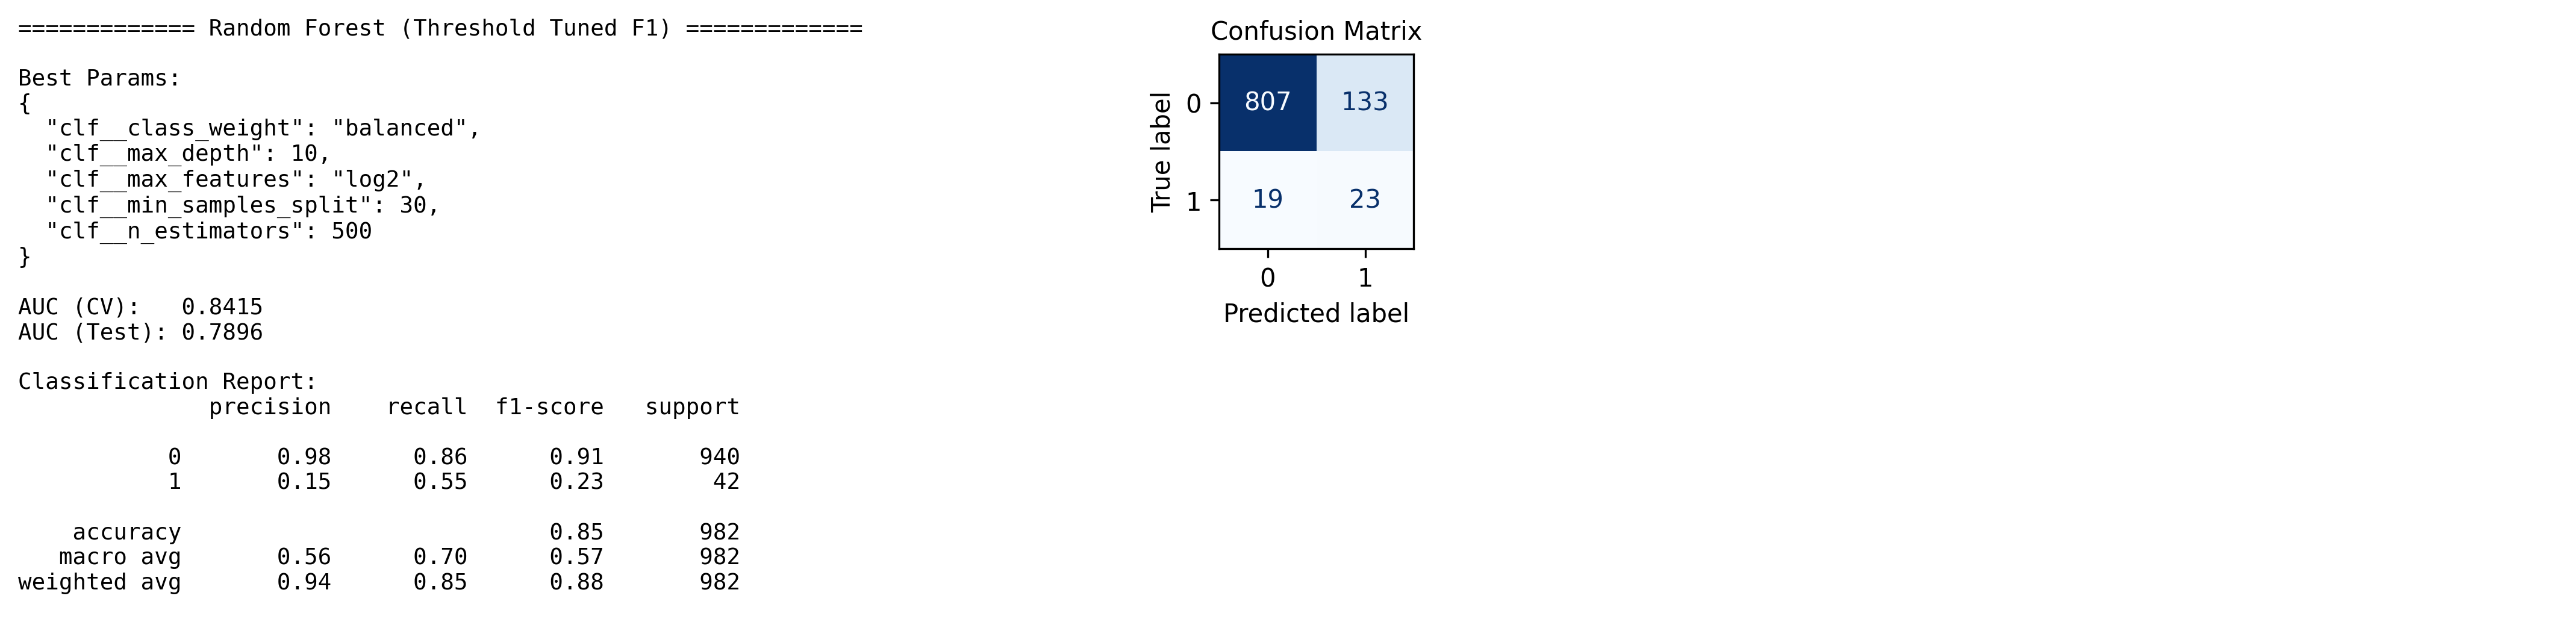

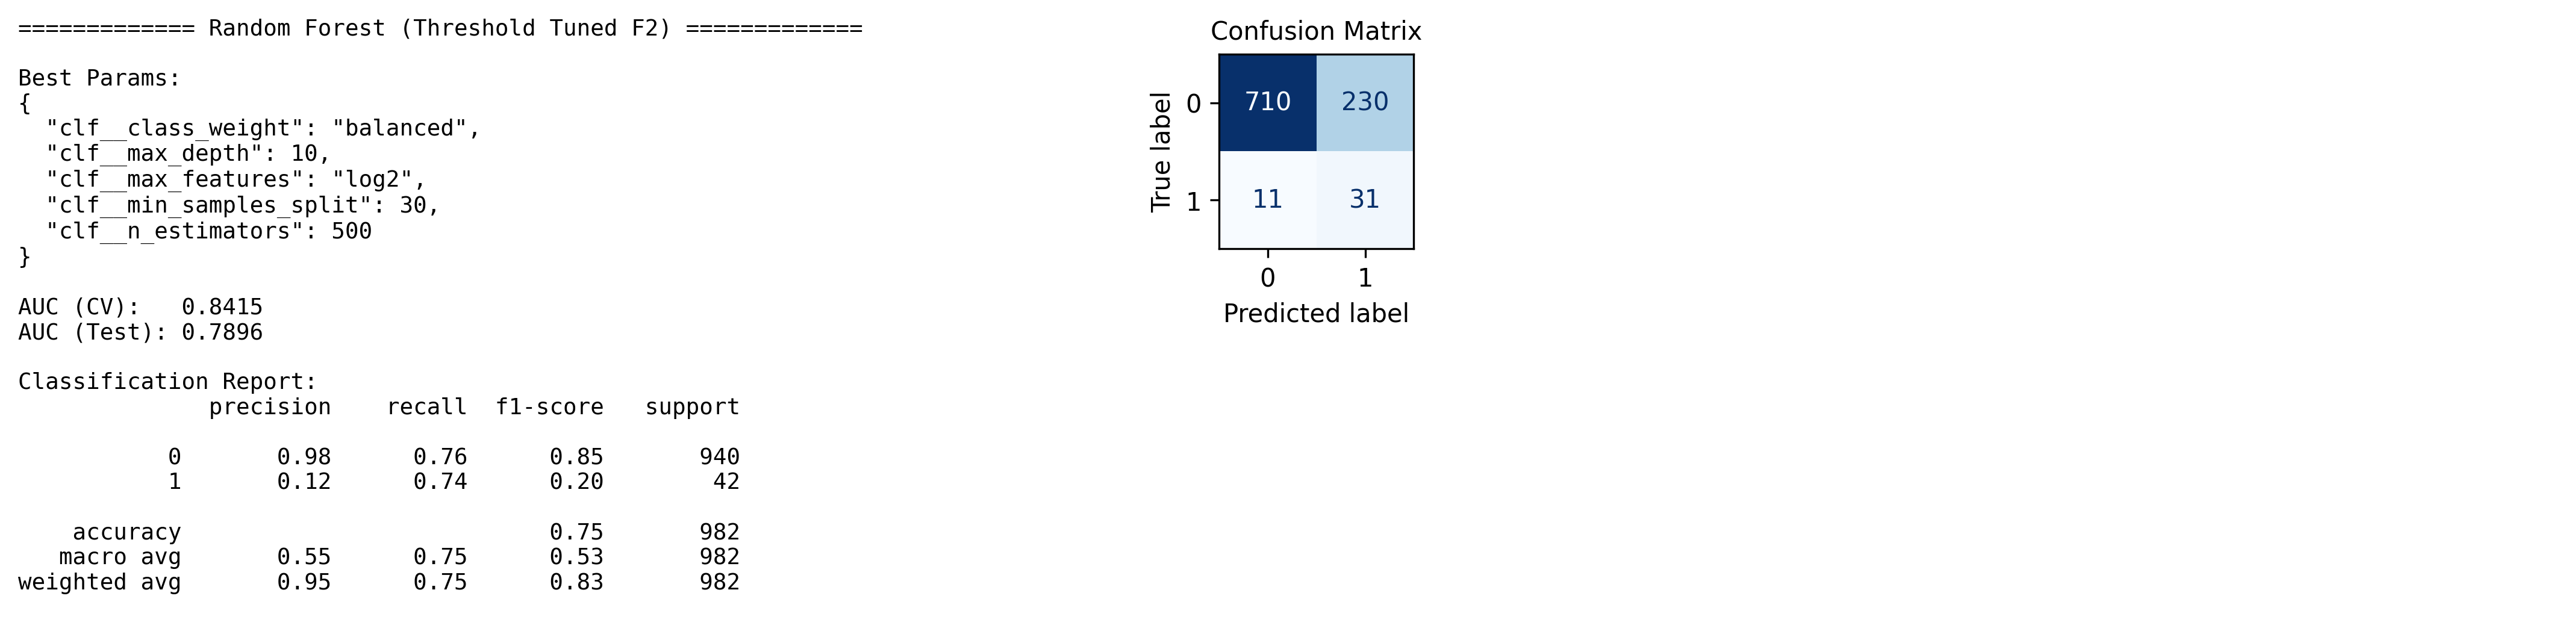

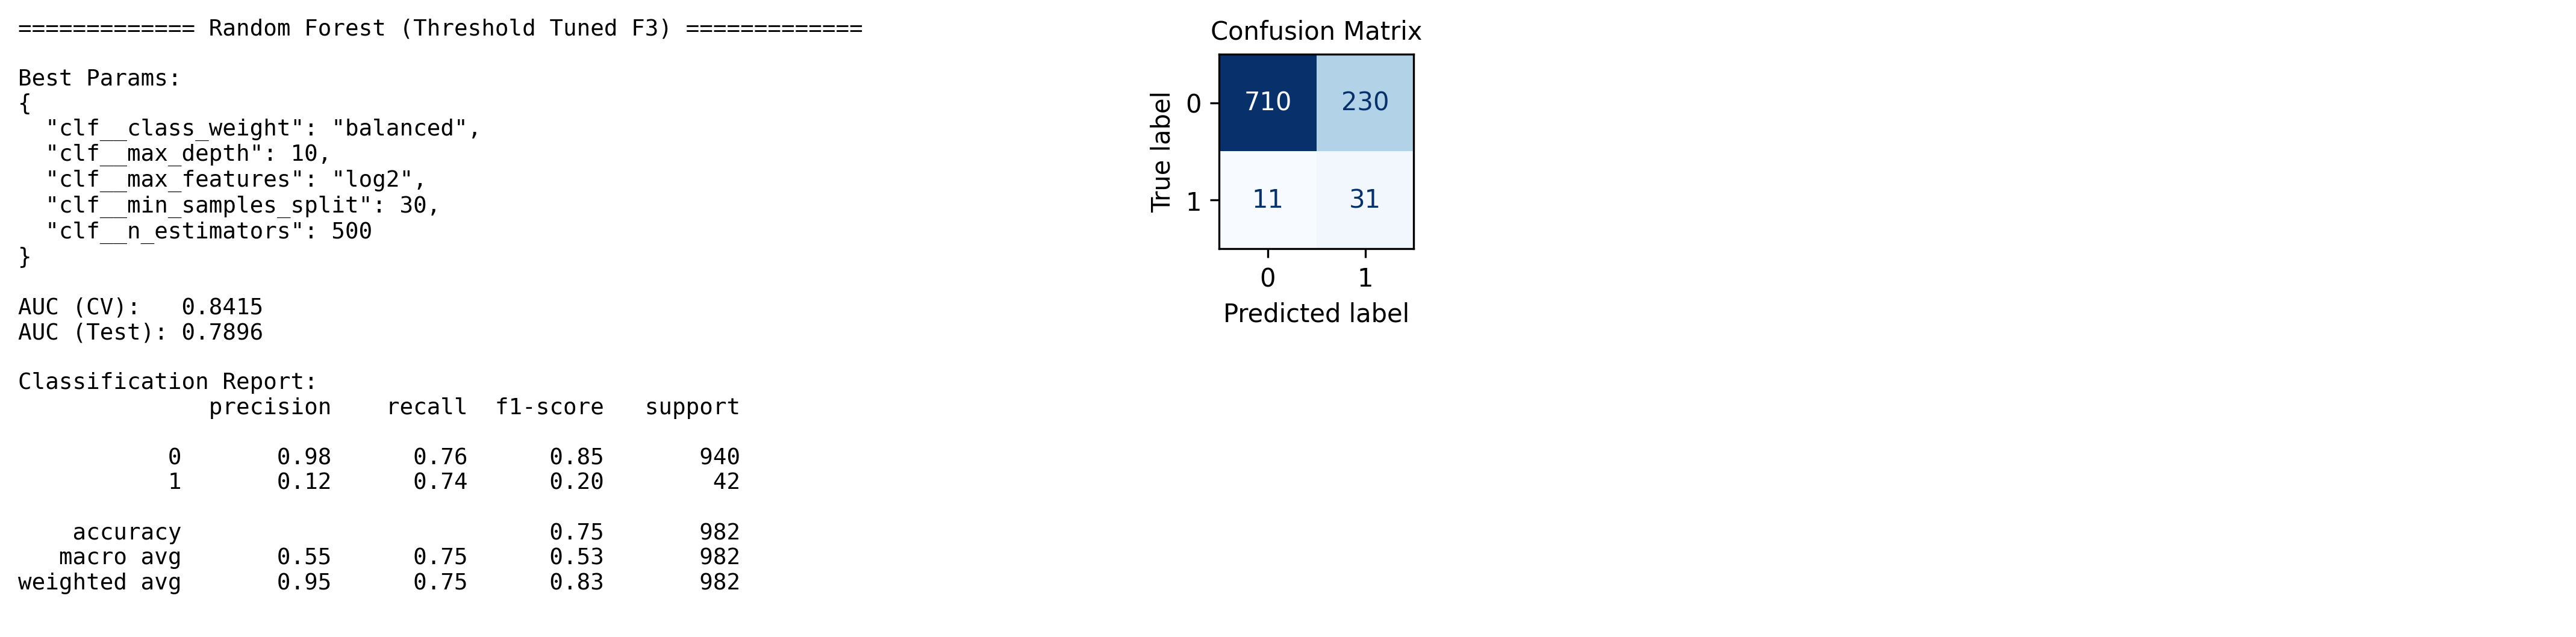

In [117]:
# Evaluate at F1
rf_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="Random Forest (Threshold Tuned F1)",
    grid=prelim_results_run3['rf_clf']['grid'],
    metrics=rf_th_metrics_f1,
    cm=rf_th_metrics_f1['confusion_matrix'],
    best_model=best_rf
)

# Evaluate at F2
rf_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="Random Forest (Threshold Tuned F2)",
    grid=prelim_results_run3['rf_clf']['grid'],
    metrics=rf_th_metrics_f2,
    cm=rf_th_metrics_f2['confusion_matrix'],
    best_model=best_rf
)

# Evaluate at F3
rf_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="Random Forest (Threshold Tuned F3)",
    grid=prelim_results_run3['rf_clf']['grid'],
    metrics=rf_th_metrics_f3,
    cm=rf_th_metrics_f3['confusion_matrix'],
    best_model=best_rf
)

### SVC RBF Threshold tuning

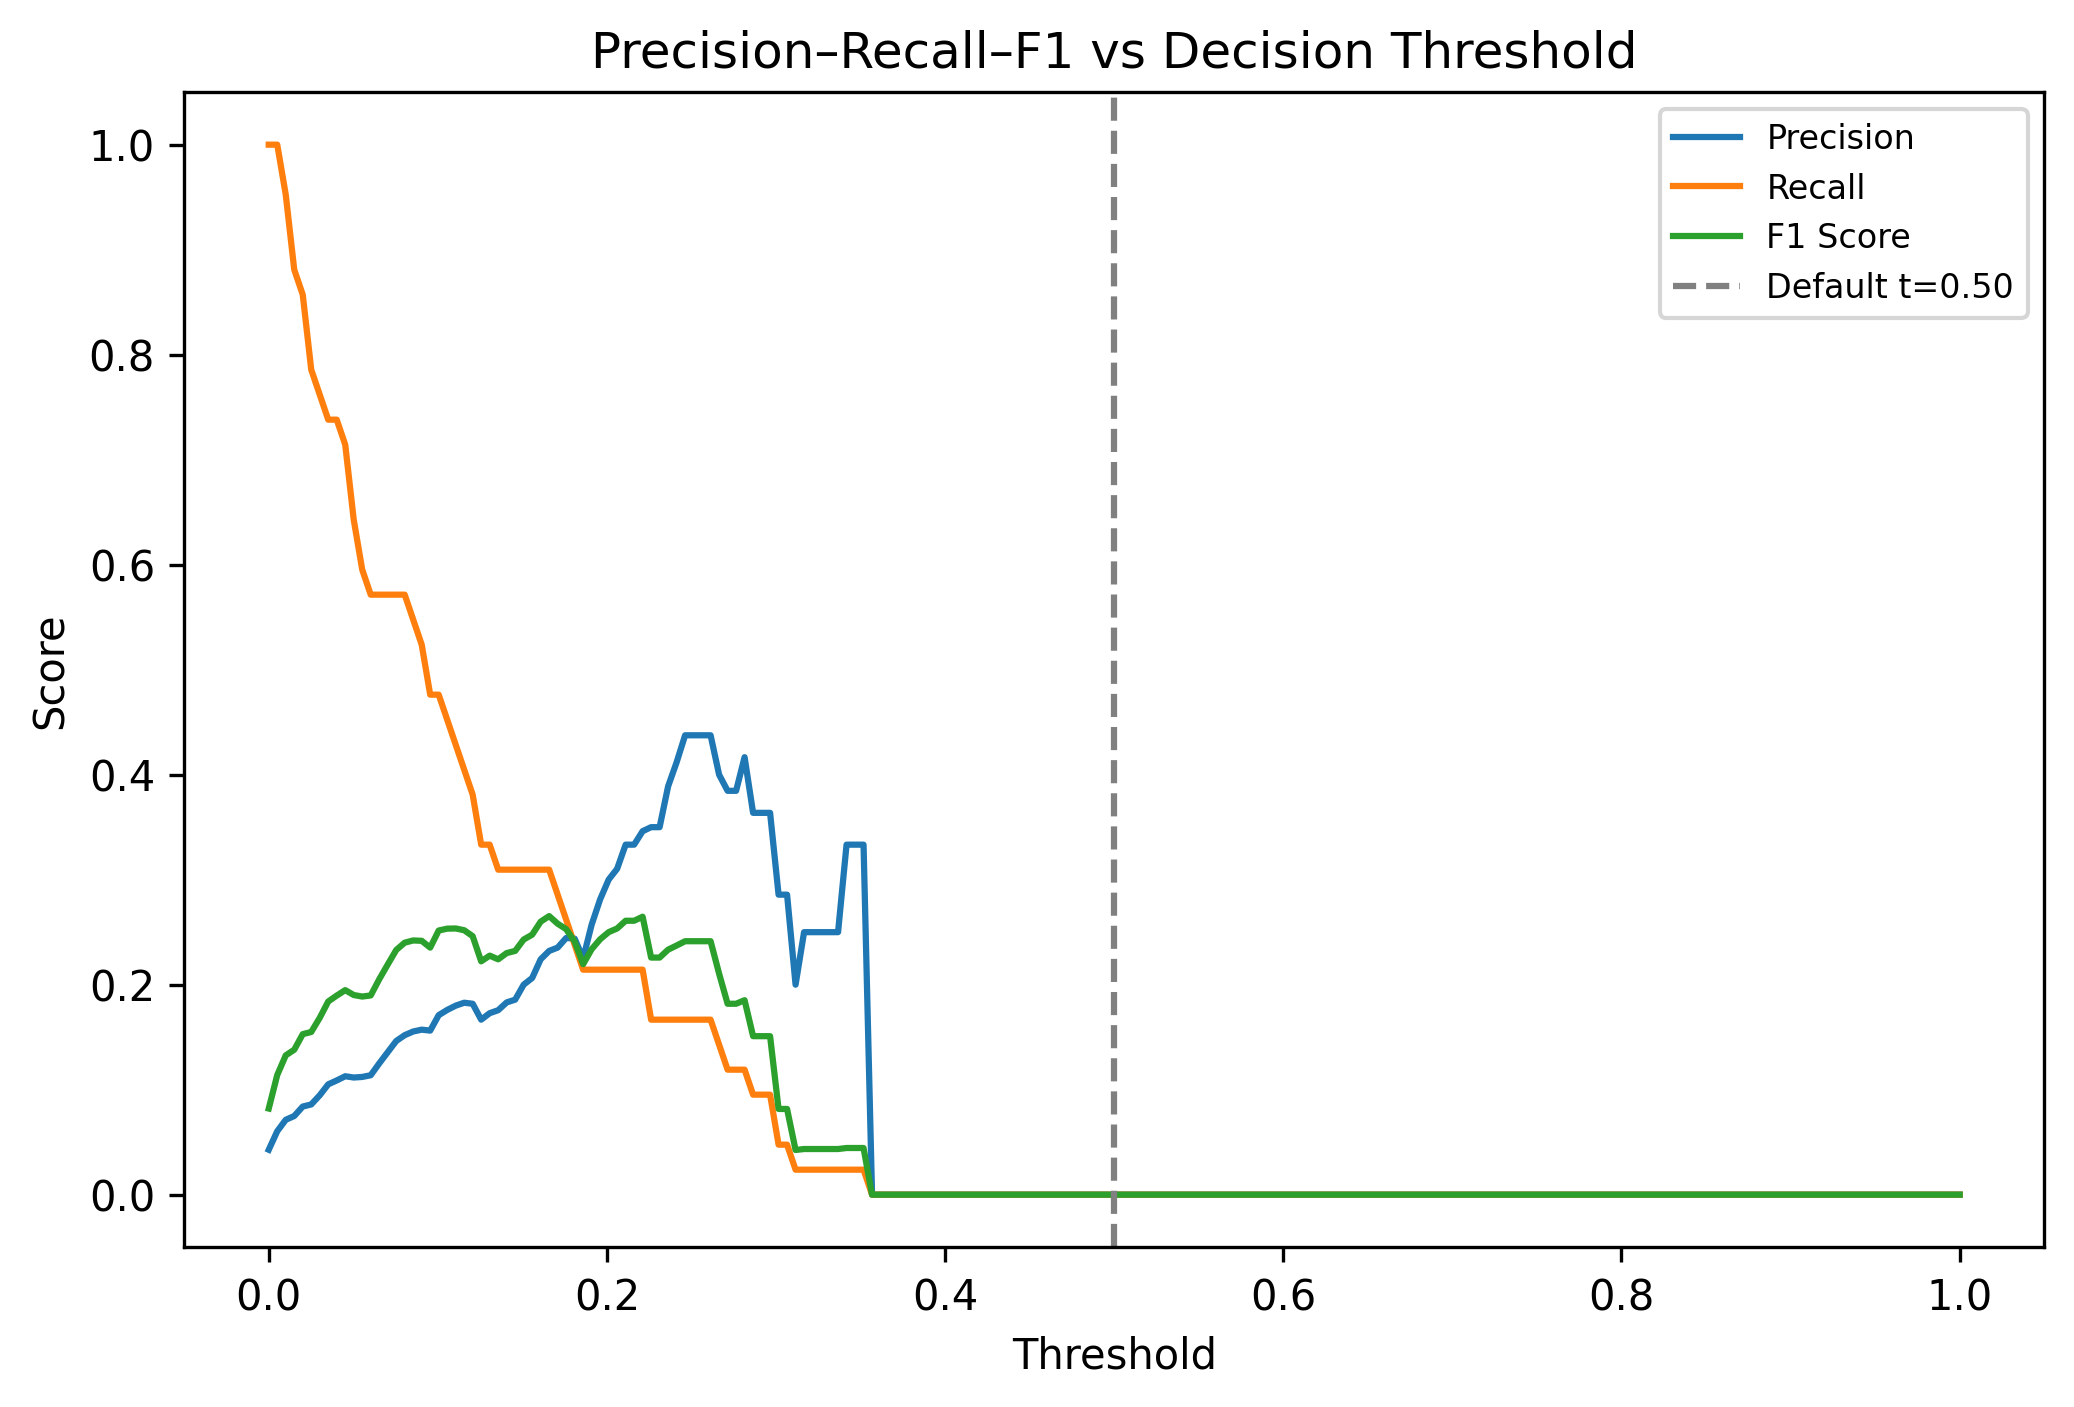

In [118]:
# Tuning SVC
best_svc = results['svc_rbf']['best_model']
y_proba = best_svc.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)

In [119]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)


Best threshold (F1): 0.1658291457286432
Best F1 score: 0.2653061224489796

Best threshold (F2): 0.08040201005025126
Best F2 score: 0.36809815950920244

Best threshold (F3): 0.04020100502512563
Best F3 score: 0.4675716440422323


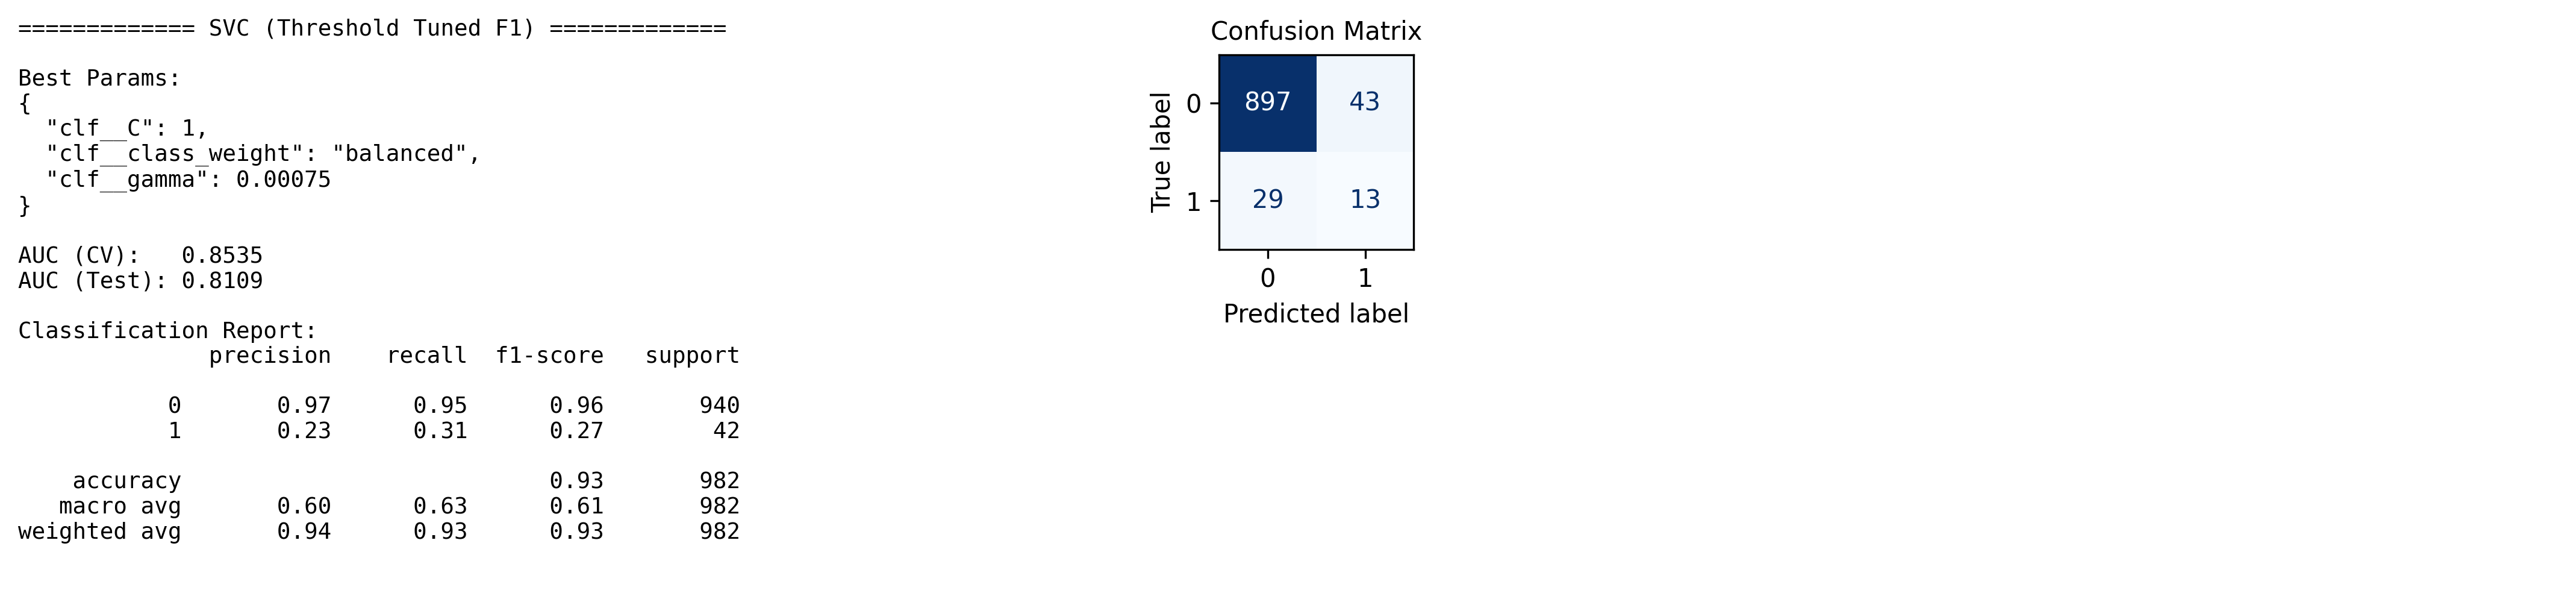

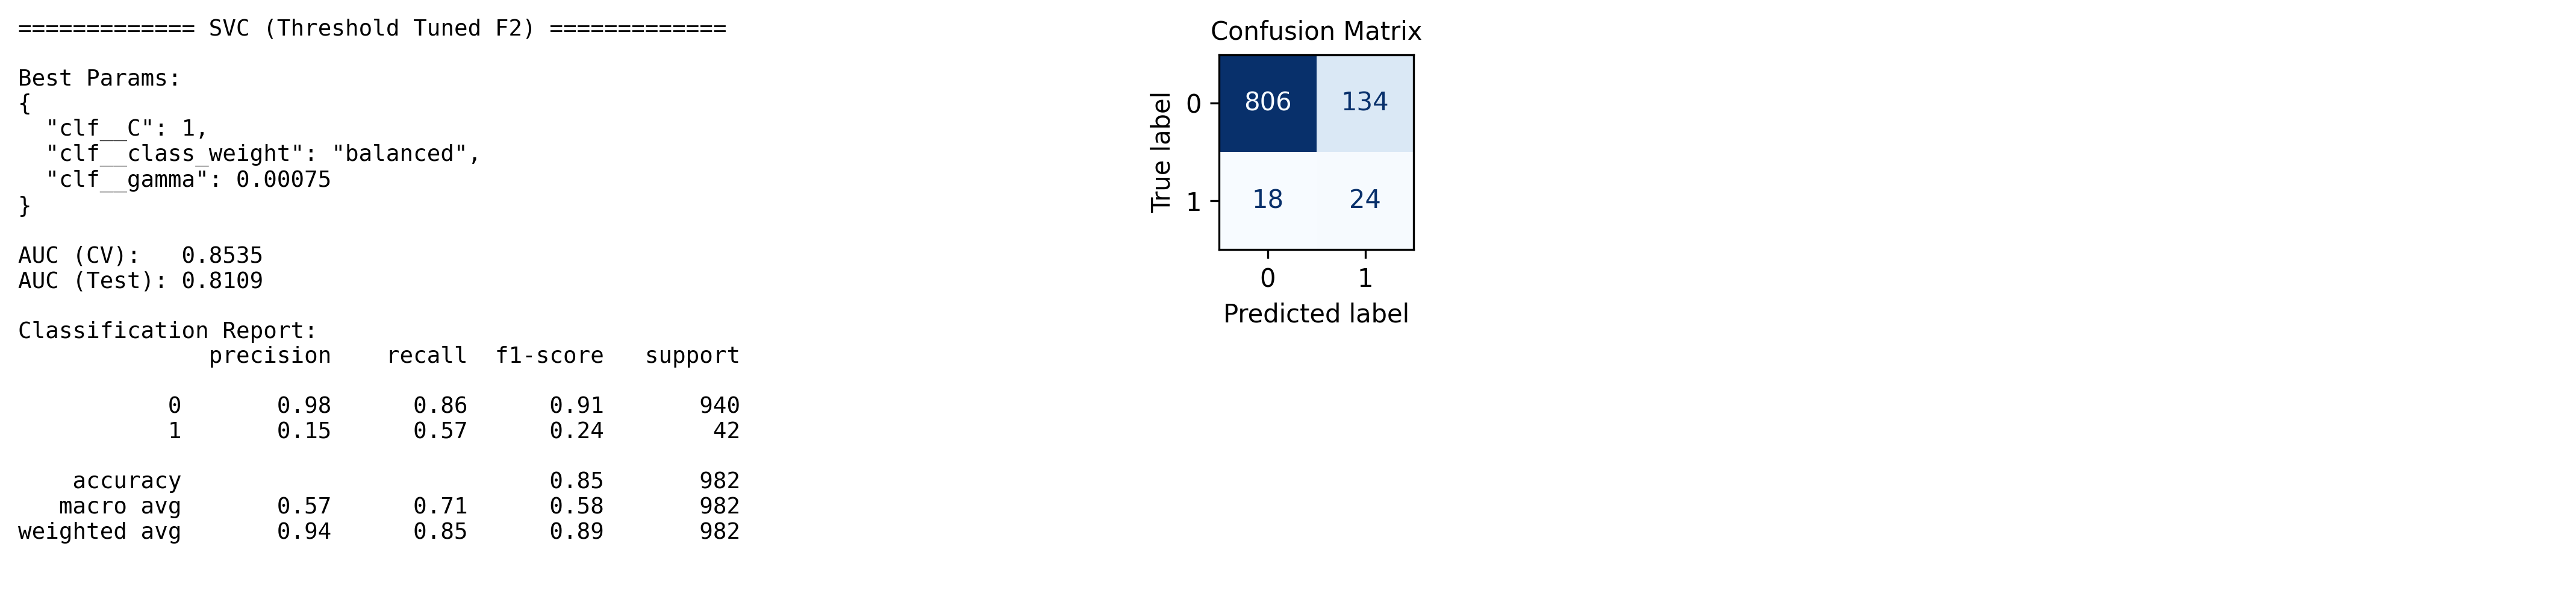

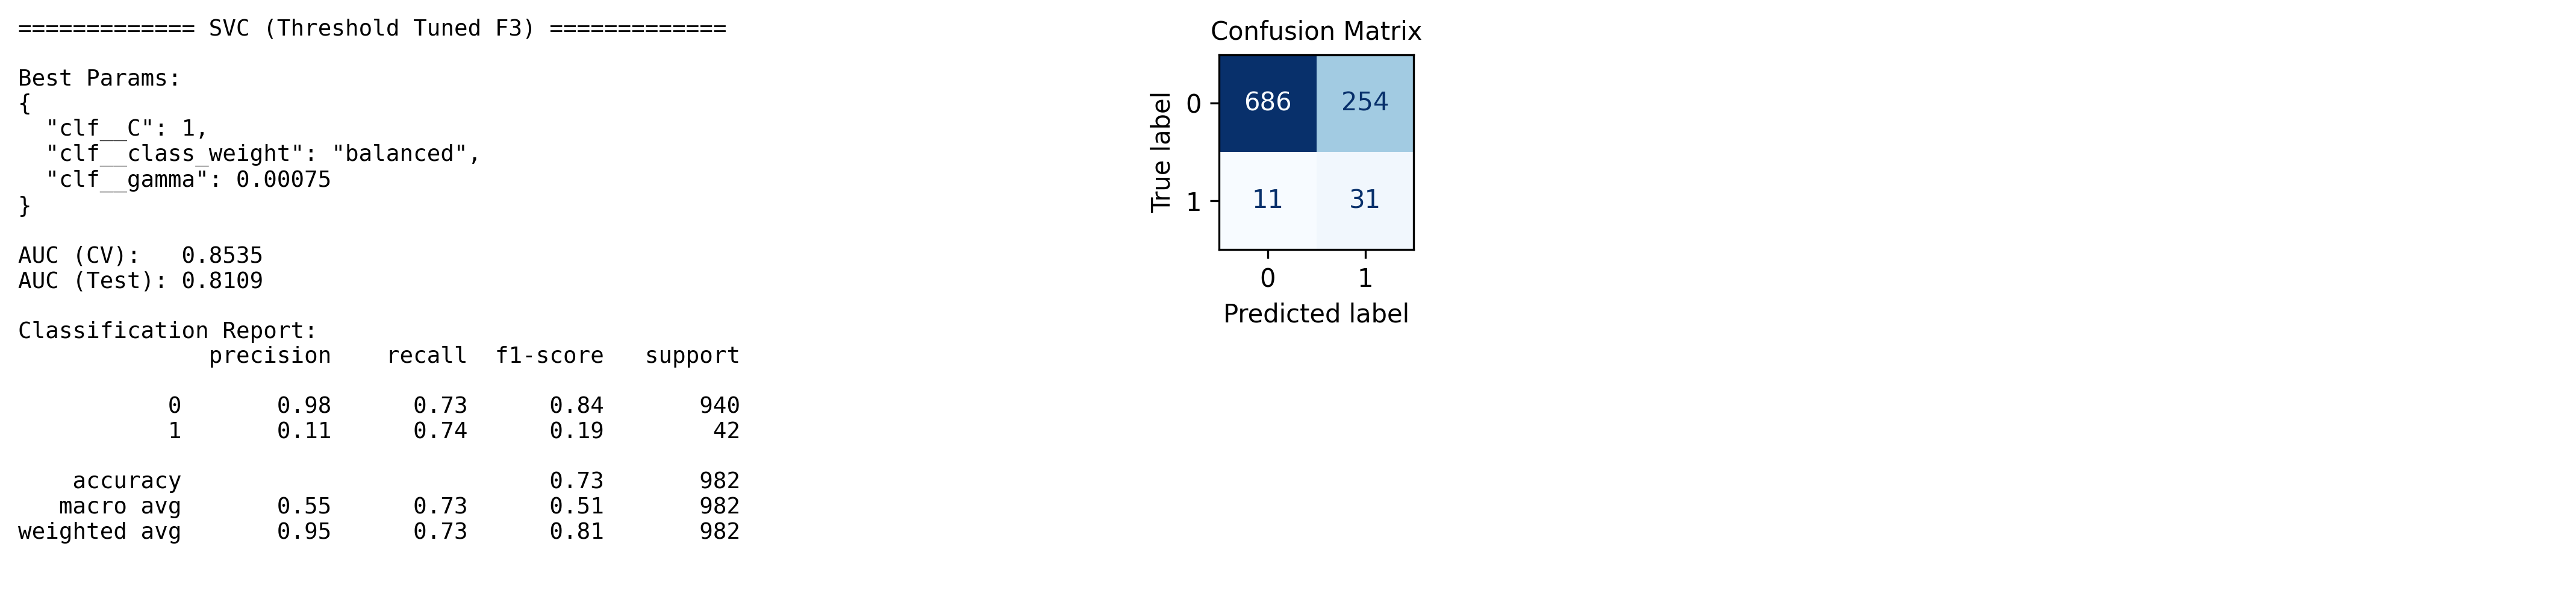

In [120]:
# Evaluate at F1
svc_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="SVC (Threshold Tuned F1)",
    grid=prelim_results_run3['svc_rbf']['grid'],
    metrics=svc_th_metrics_f1,
    cm=svc_th_metrics_f1['confusion_matrix'],
    best_model=best_svc
)

# Evaluate at F2
svc_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="SVC (Threshold Tuned F2)",
    grid=prelim_results_run3['svc_rbf']['grid'],
    metrics=svc_th_metrics_f2,
    cm=svc_th_metrics_f2['confusion_matrix'],
    best_model=best_svc
)

# Evaluate at F3
svc_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="SVC (Threshold Tuned F3)",
    grid=prelim_results_run3['svc_rbf']['grid'],
    metrics=svc_th_metrics_f3,
    cm=svc_th_metrics_f3['confusion_matrix'],
    best_model=best_svc
)

### XGBoost Threshold tuning

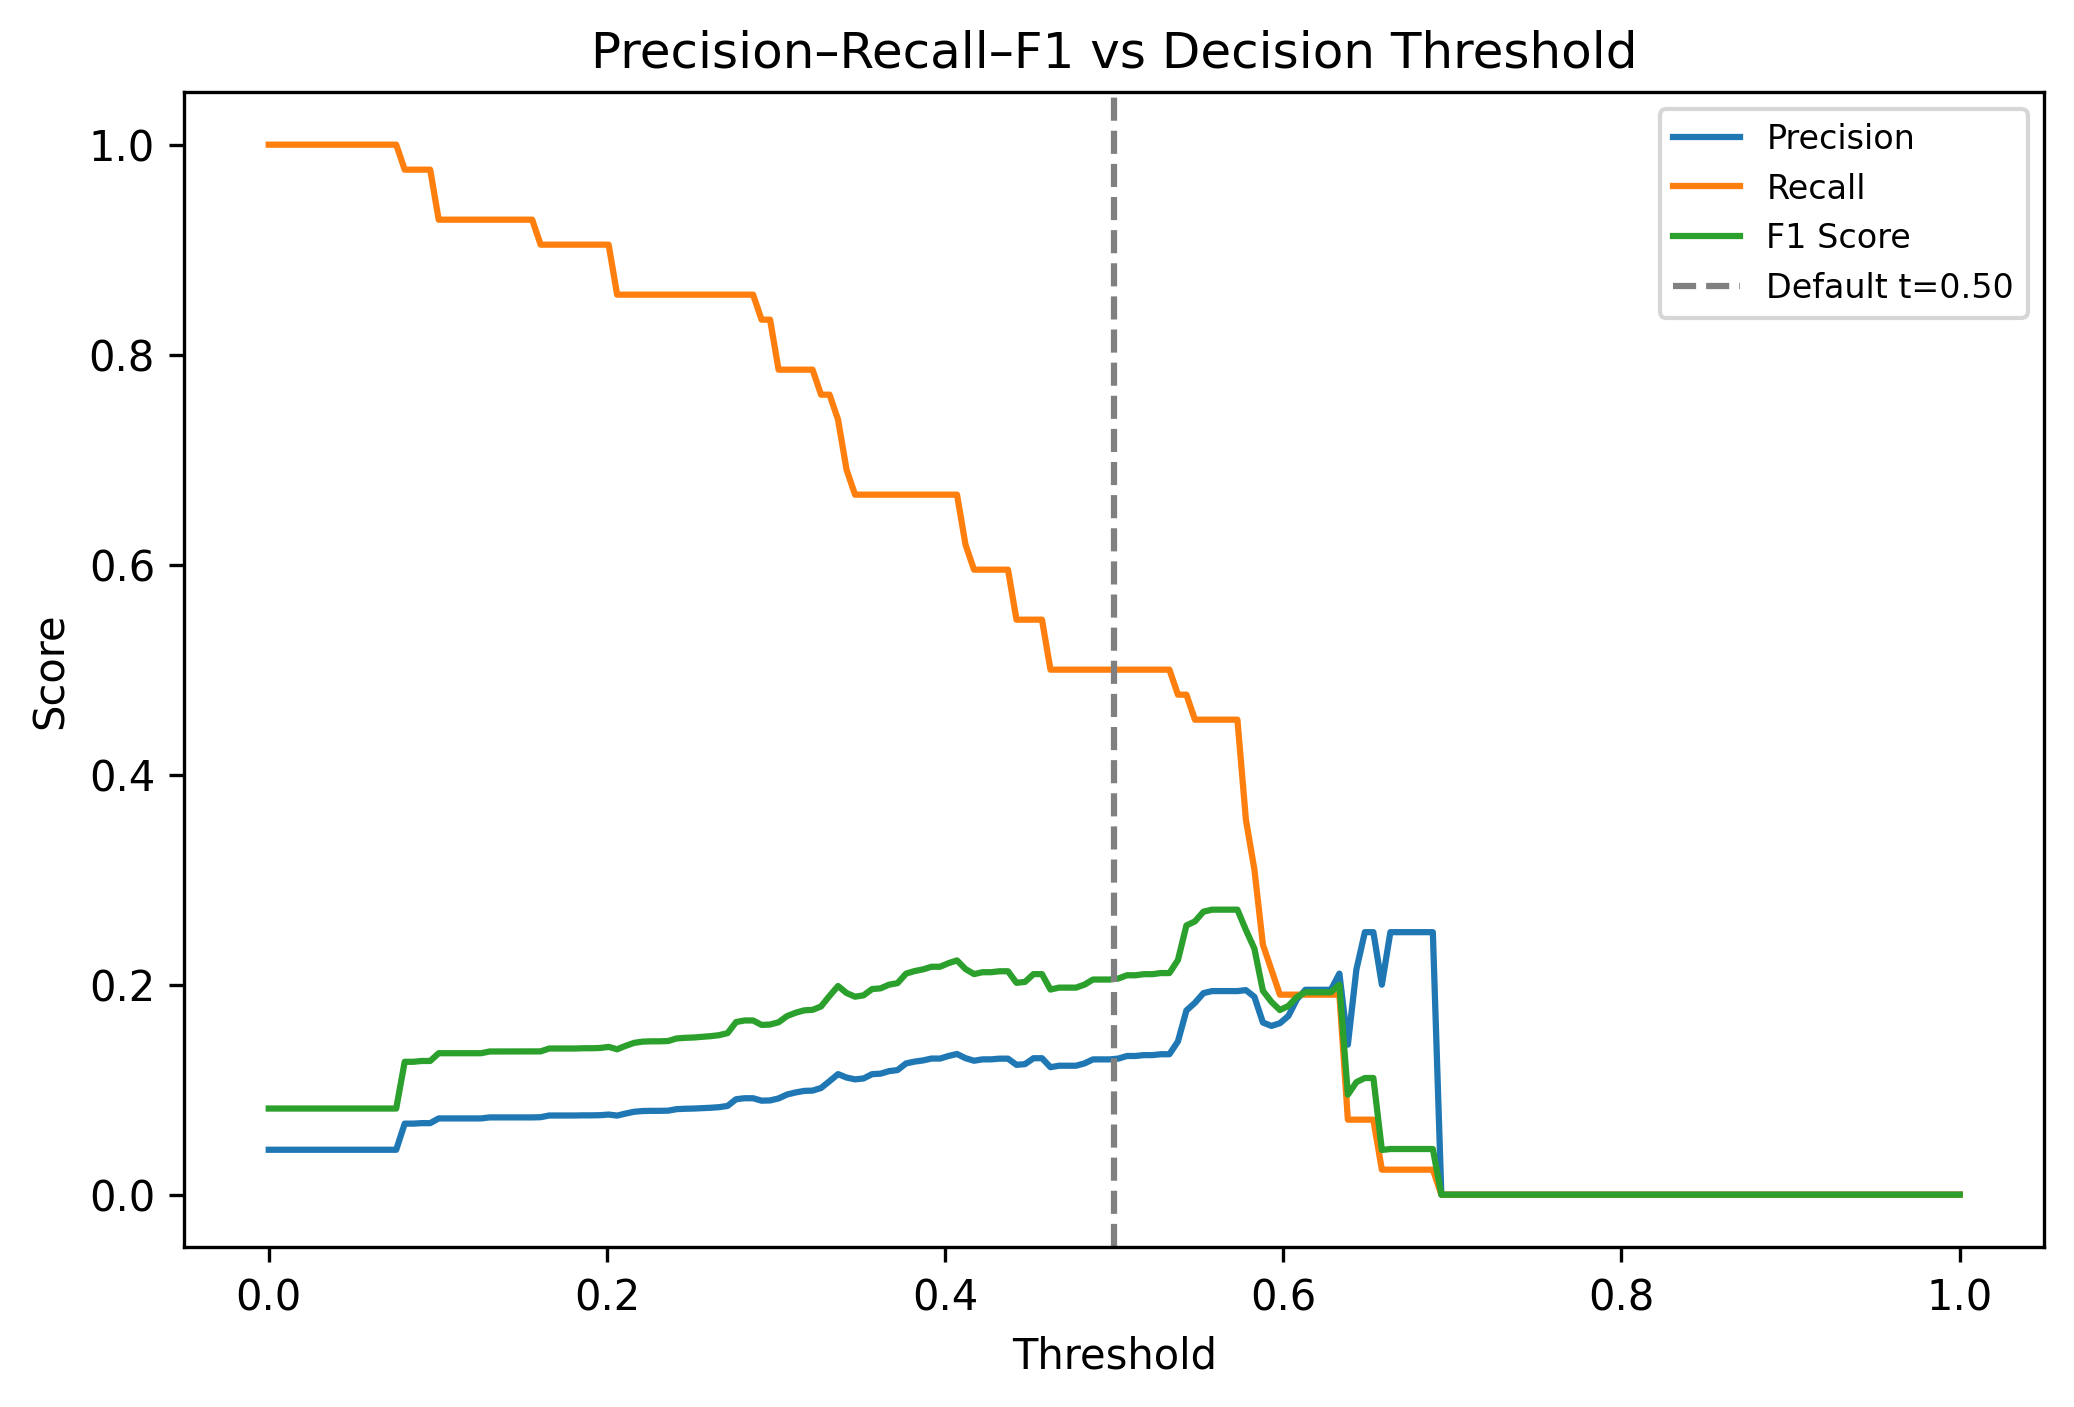

In [121]:
# Tuning XGBoost
best_xgboost = results['xgb_clf']['best_model']
y_proba = best_xgboost.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)


In [122]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)




Best threshold (F1): 0.5577889447236181
Best F1 score: 0.2714285714285714

Best threshold (F2): 0.40703517587939697
Best F2 score: 0.3713527851458886

Best threshold (F3): 0.33668341708542715
Best F3 score: 0.4783950617283951


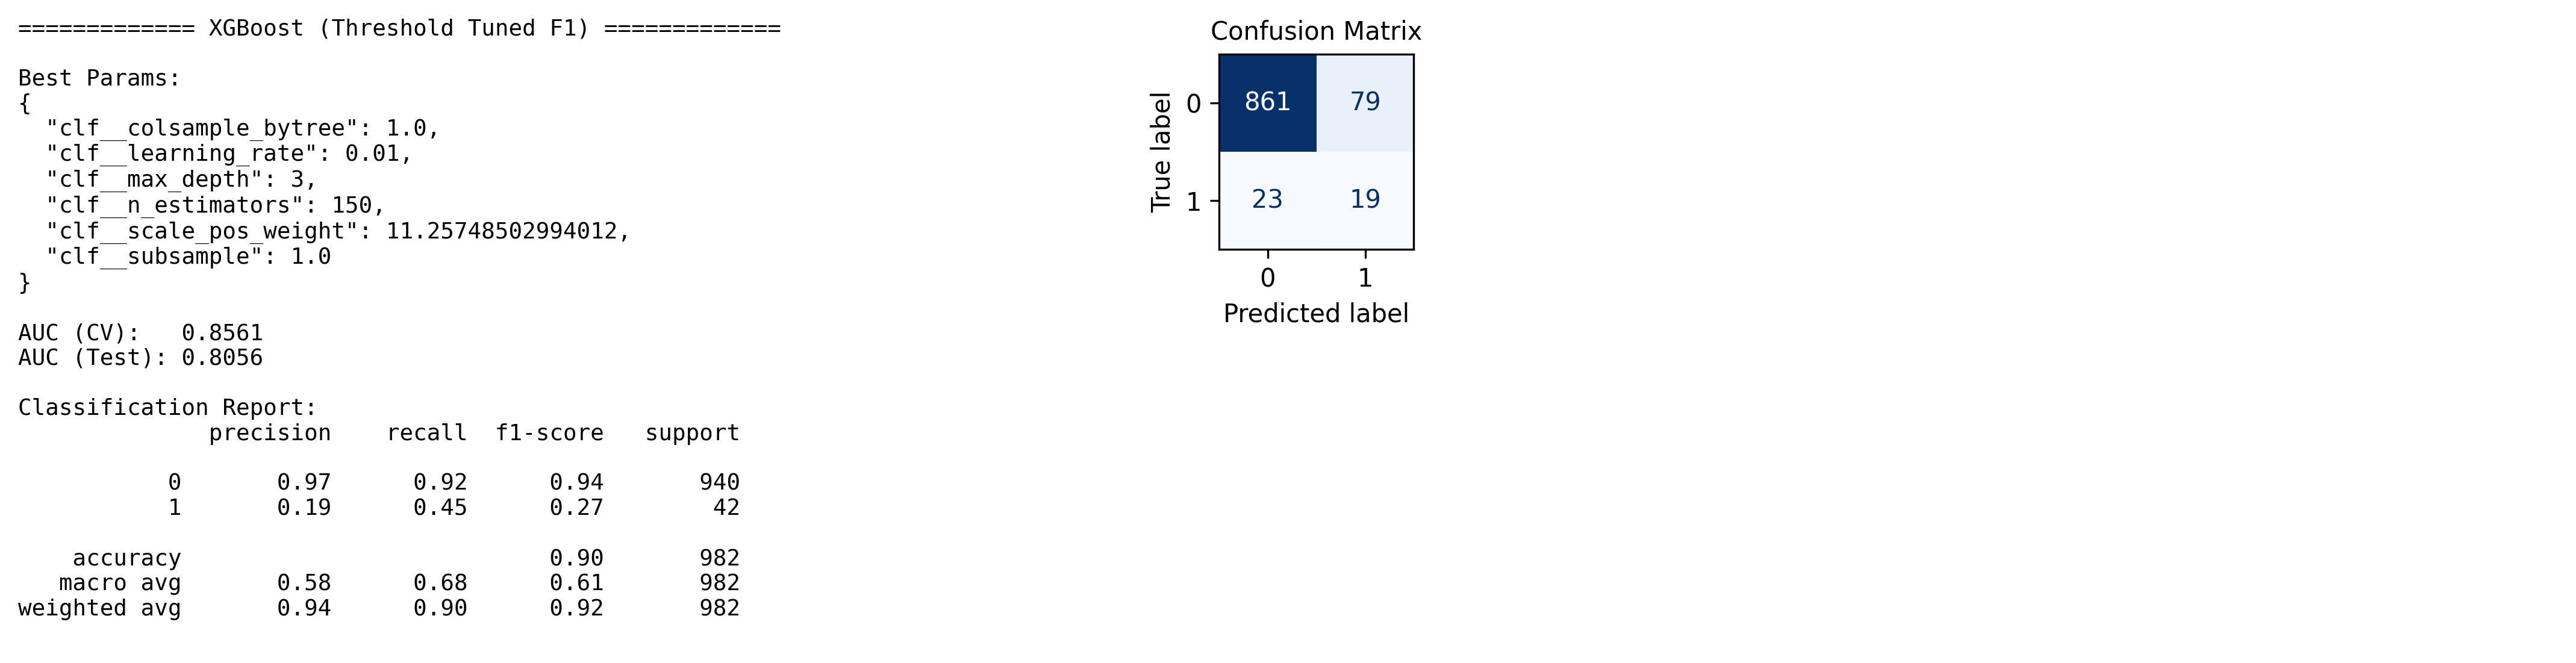

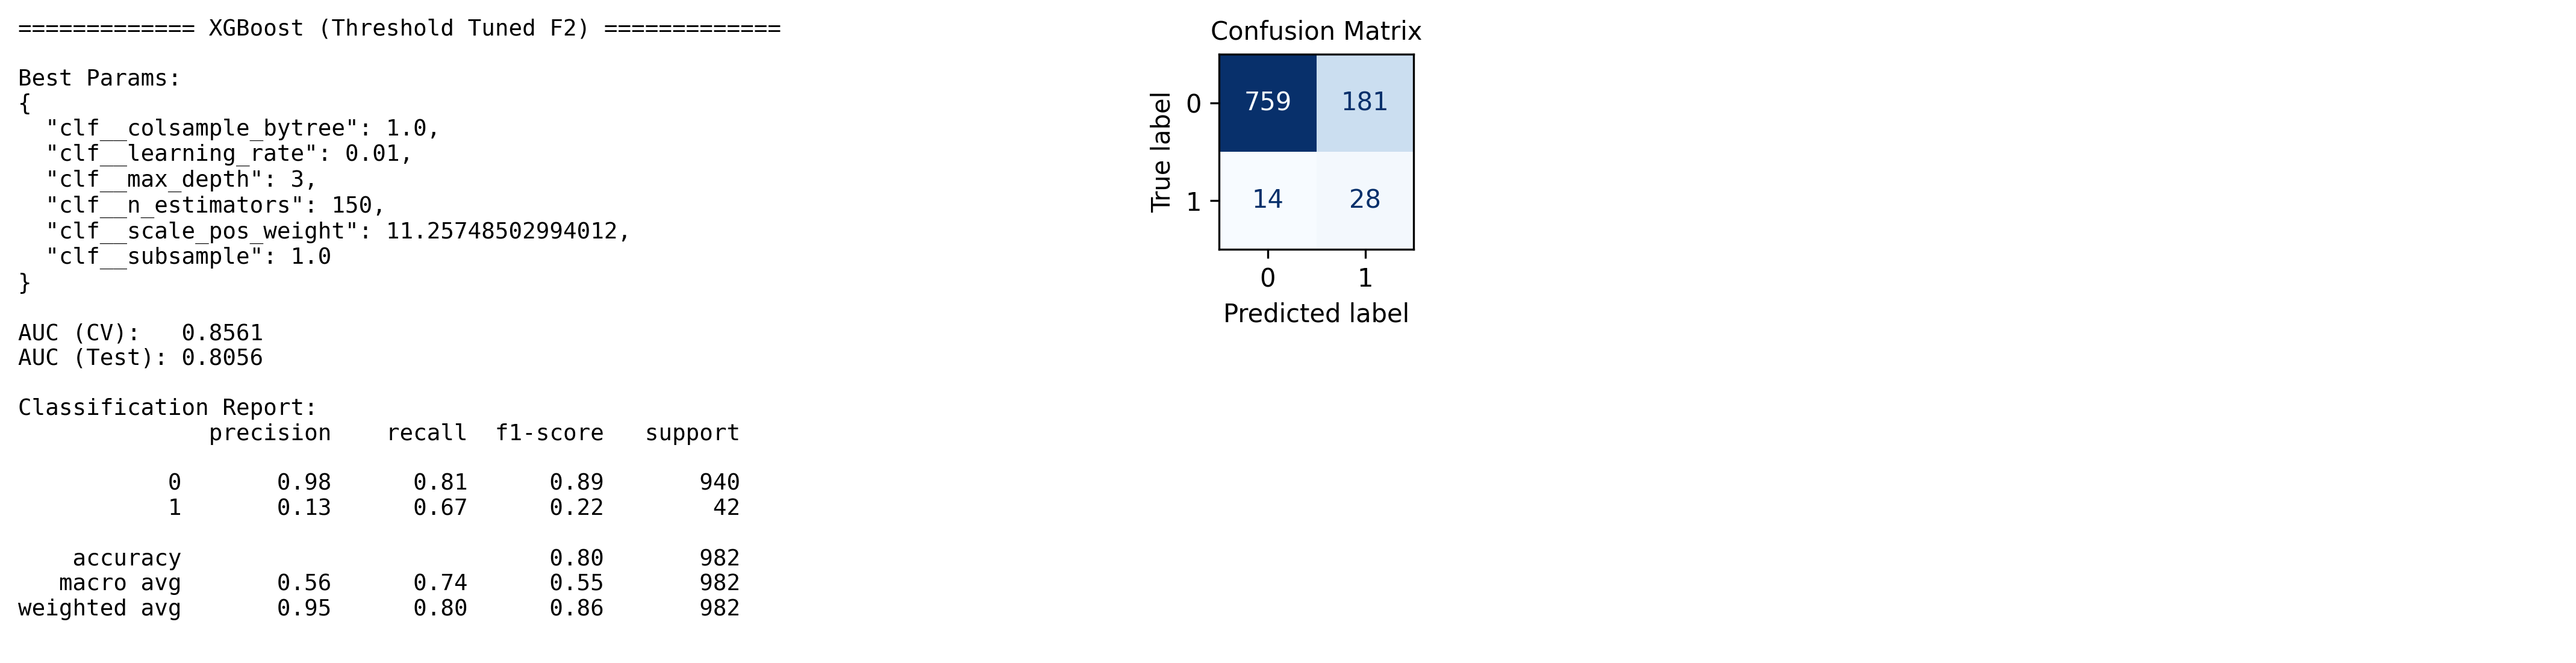

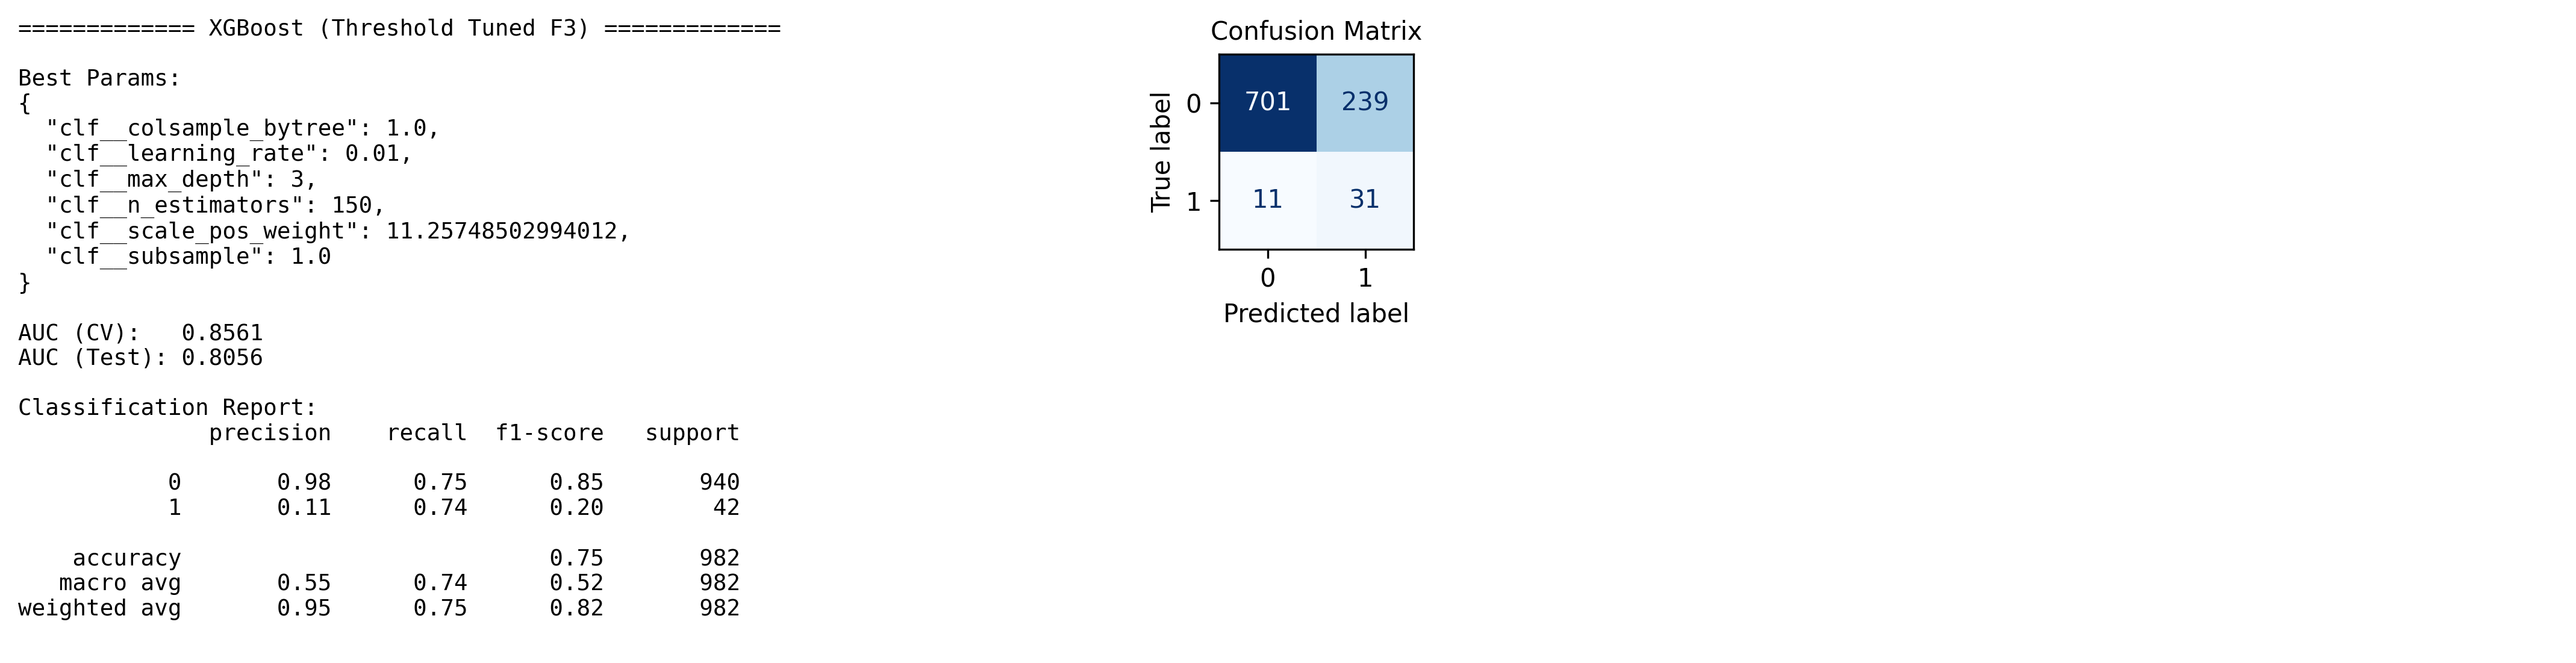

In [123]:
# Evaluate at F1
xgb_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="XGBoost (Threshold Tuned F1)",
    grid=prelim_results_run3['xgb_clf']['grid'],
    metrics=xgb_th_metrics_f1,
    cm=xgb_th_metrics_f1['confusion_matrix'],
    best_model=best_xgboost
)

# Evaluate at F2
xgb_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="XGBoost (Threshold Tuned F2)",
    grid=prelim_results_run3['xgb_clf']['grid'],
    metrics=xgb_th_metrics_f2,
    cm=xgb_th_metrics_f2['confusion_matrix'],
    best_model=best_xgboost
)

# Evaluate at F3
xgb_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="XGBoost (Threshold Tuned F3)",
    grid=prelim_results_run3['xgb_clf']['grid'],
    metrics=xgb_th_metrics_f3,
    cm=xgb_th_metrics_f3['confusion_matrix'],
    best_model=best_xgboost
)


# Final Results
Because the dataset is highly imbalanced (~5% positive class), the default probability threshold (0.50) yields almost no positive predictions. threshold tuning improves recall significantly, which is appropriate for a clinical setting where missing positive cases carries high risk.

In [133]:
models = ['log_reg']*3 + ['gb_clf']*3 + ['rf_clf']*3 +  ['svc_rbf']*3 +  ['xgb_clf']*3
runs = [lr_th_metrics_f1, lr_th_metrics_f2, lr_th_metrics_f3,
       gb_th_metrics_f1, gb_th_metrics_f2, gb_th_metrics_f3,
       rf_th_metrics_f1, rf_th_metrics_f2, rf_th_metrics_f3,
       svc_th_metrics_f1, svc_th_metrics_f2, svc_th_metrics_f3,
       xgb_th_metrics_f1, xgb_th_metrics_f2, xgb_th_metrics_f3]

auc_cv = [ prelim_results_run3[m]['grid'].best_score_ for m in models ]
auc_test = [ run['test_auc'] for run in runs ]  
recall = [ run['recall'] for run in runs ]
precision = [ run['precision'] for run in runs ]
fbeta = [ run['fbeta'] for run in runs ]
threshold = [ run['threshold'] for run in runs ]

results_dict = {
    "Model": models,
    "Run": [ f"Fβ{i+1}" for i in range(3)]*5,
    "AUC CV": auc_cv,
    "AUC Test": auc_test,
    "Recall": recall,
    "Precision": precision,
    "Fβ score": fbeta,
    "Threshold": threshold
}

comparison_tb = pd.DataFrame(results_dict)
#comparison_tb.round(3)

df_pretty = comparison_tb.copy().set_index(["Model", "Run"]).round(3)
df_pretty

AUC CV  AUC Test  Recall  Precision  Fβ score  Threshold
Model   Run                                                          
log_reg Fβ1   0.853     0.810   0.429      0.196     0.269      0.719
        Fβ2   0.853     0.810   0.548      0.165     0.375      0.658
        Fβ3   0.853     0.810   0.738      0.117     0.482      0.508
gb_clf  Fβ1   0.853     0.801   0.476      0.172     0.253      0.095
        Fβ2   0.853     0.801   0.476      0.172     0.352      0.095
        Fβ3   0.853     0.801   0.762      0.101     0.460      0.040
rf_clf  Fβ1   0.842     0.790   0.548      0.147     0.232      0.462
        Fβ2   0.842     0.790   0.738      0.119     0.361      0.307
        Fβ3   0.842     0.790   0.738      0.119     0.485      0.307
svc_rbf Fβ1   0.854     0.811   0.310      0.232     0.265      0.166
        Fβ2   0.854     0.811   0.571      0.152     0.368      0.080
        Fβ3   0.854     0.811   0.738      0.109     0.468      0.040
xgb_clf Fβ1   0.856     0.806   0.452      0.194     0.271      0.558
        Fβ2   0.856     0.806   0.667      0.134     0.371      0.407
        Fβ3   0.856     0.806   0.738      0.115     0.478      0.337

In [142]:
final_result = comparison_tb.copy().set_index("Model")
final_result = final_result[final_result["Run"]=="Fβ3"].round(3)
final_result

Run  AUC CV  AUC Test  Recall  Precision  Fβ score  Threshold
Model                                                                 
log_reg  Fβ3   0.853     0.810   0.738      0.117     0.482      0.508
gb_clf   Fβ3   0.853     0.801   0.762      0.101     0.460      0.040
rf_clf   Fβ3   0.842     0.790   0.738      0.119     0.485      0.307
svc_rbf  Fβ3   0.854     0.811   0.738      0.109     0.468      0.040
xgb_clf  Fβ3   0.856     0.806   0.738      0.115     0.478      0.337

### Observations
Across three training rounds, the models converged in performance. 
XGBoost and Random Forest consistently achieved the highest AUC and 
recall after threshold tuning, making them the preferred models. 
Logistic Regression underfitted due to nonlinear relationships in 
features.

After applying threshold tuning across Fβ = 1, 2, and 3, we see a consistent pattern:

#### Threshold tuning significantly improves recall across all models

> Before tuning, several models (LogReg, GB, XGB) failed to detect any positive cases under default threshold 0.50.
After tuning, even simple models like logistic regression reach:

> - Recall ≈ 0.74 (F3)
> - Fβ score improves accordingly

> This demonstrates that threshold tuning is essential on imbalanced clinical datasets.

#### Increasing β from 1 → 2 → 3 consistently shifts the balance toward recall

> Across all models:
> 
> - F1 → recall ~0.40–0.55
> - F2 → recall ~0.55–0.67
> - F3 → recall ~0.73–0.76
> This monotonic trend is exactly what Fβ is designed to produce:
> Higher β pushes the decision boundary toward more positive predictions.

#### Recall converges to a narrow range across models

> > ite architectural differences, at F3:
> 
> - `log_reg` -> surpringly competitive
> - `gb_clf` --> best recall overall
> - `rf_clf` --> stable across runs
> - `svc_rbf` --> consistent and robust
> - `xgb_clf` --> stable, performance improve to the level of SVC with threshold tuning (as expected)

#### Precision remains low (≈ 0.10–0.13)

> This is expected when maximizing recall on extremely imbalanced data.
> However, precision is still good enough to justify the tradeoff in a clinical screening context.





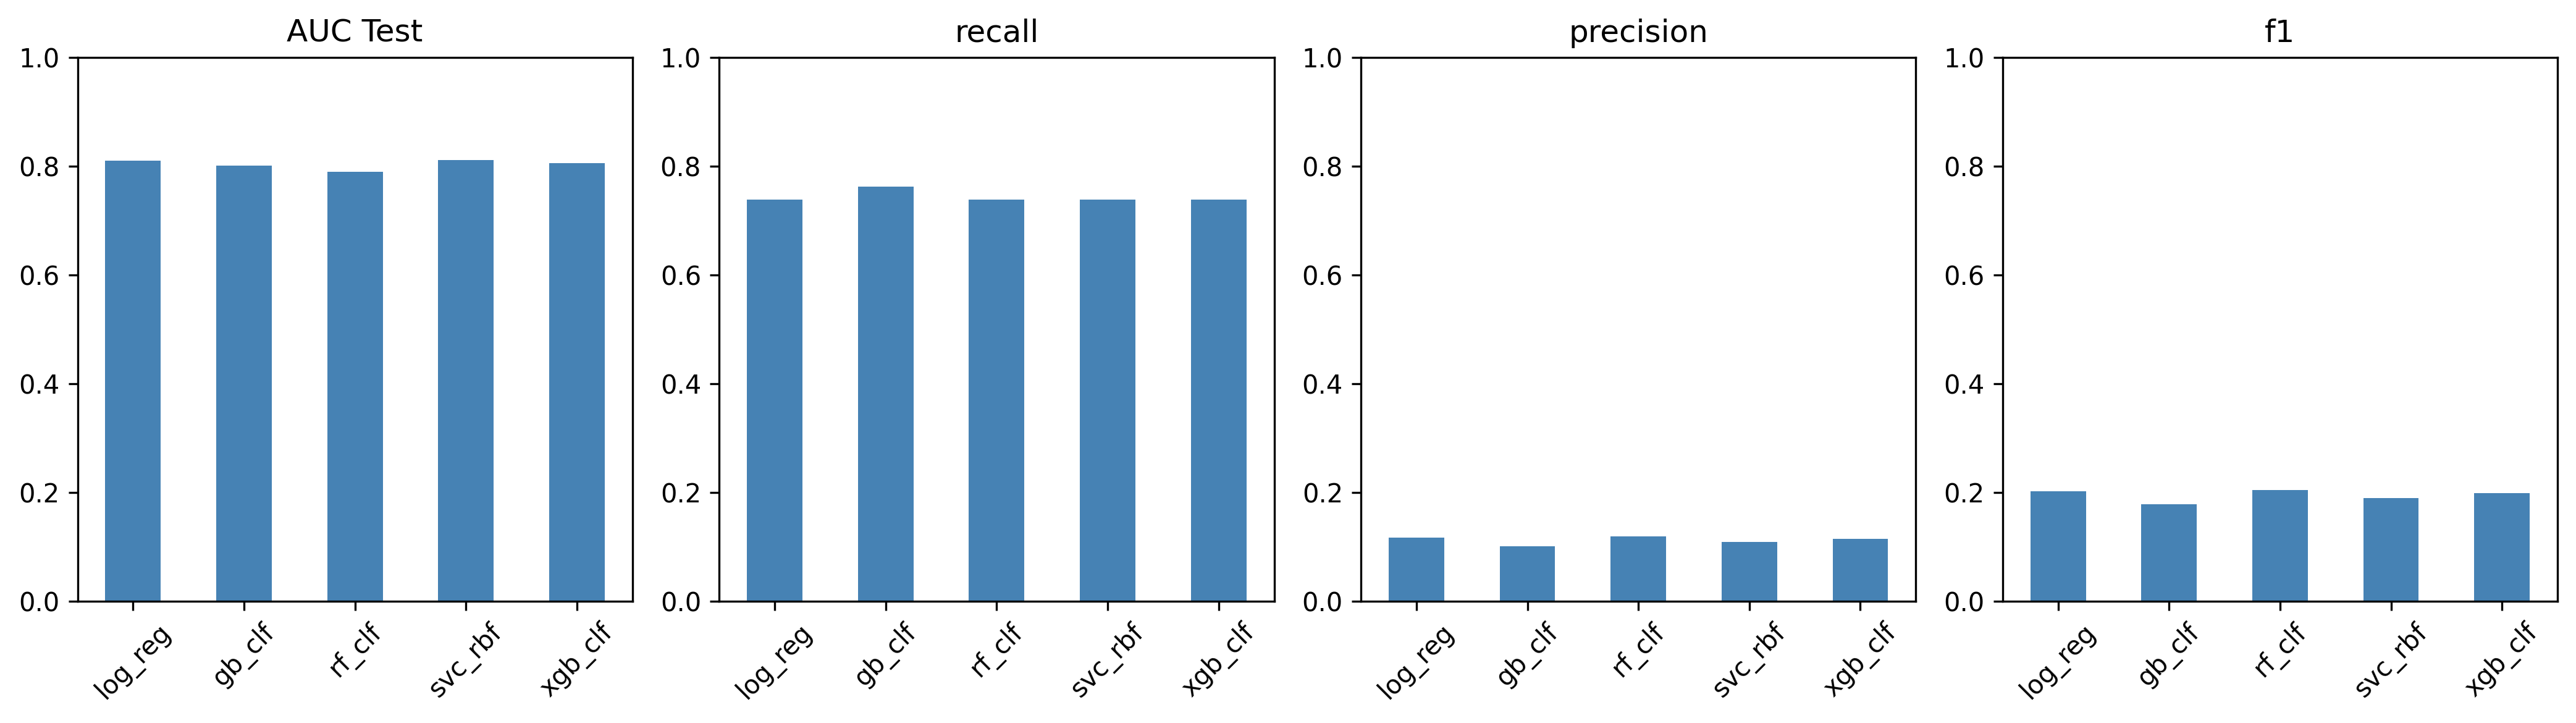

In [131]:
fig, axes = plt.subplots(1,4, figsize=(14, 4))

for i, metric in enumerate(["AUC Test", "recall", "precision", "f1"]):
    final_results[metric].plot(kind="bar", color="steelblue", ax=axes[i])
    axes[i].set_ylim(0, 1)
    axes[i].set_title(metric)
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
#$plt.show()
show_shrunk(fig, width=1200)


We can see all models reaching the same ceiling in performance after threshold tuning.

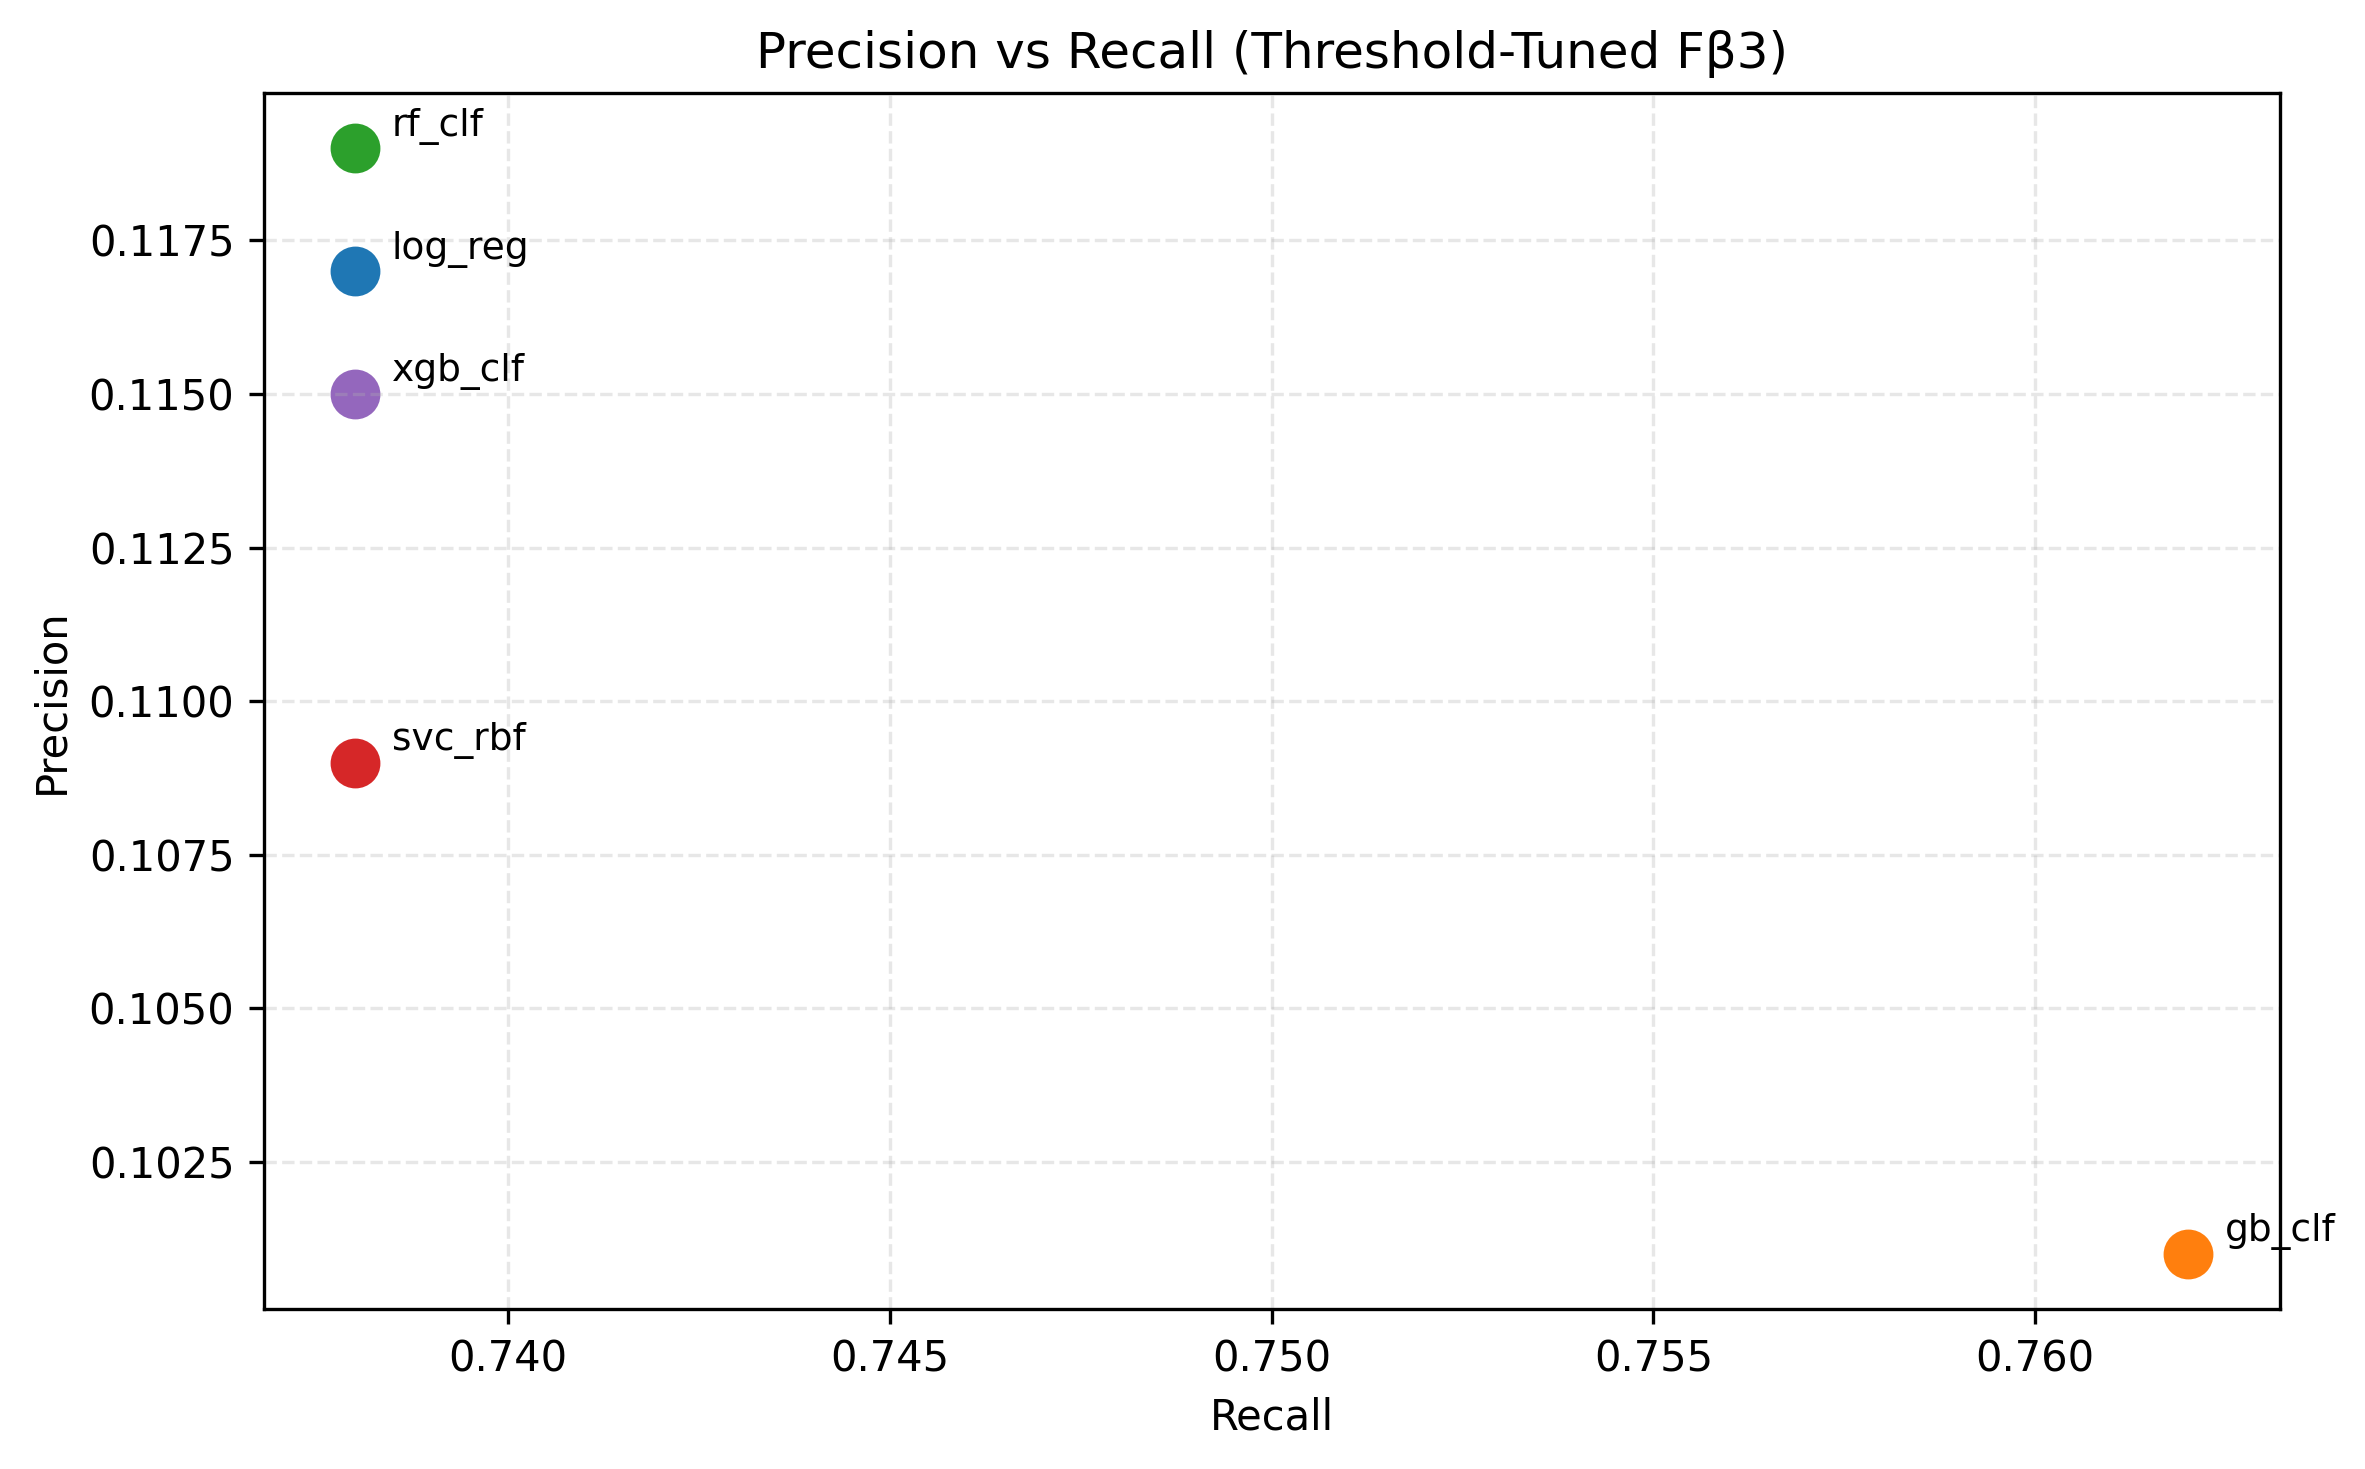

In [160]:
def pr_scatter_ax(df):
    fig, ax = plt.subplots(figsize=(8,5), dpi=200)   # base size (you will shrink later)

    # --- dynamic offsets based on data range ---
    xrange = df["Recall"].max() - df["Recall"].min()
    yrange = df["Precision"].max() - df["Precision"].min()
    xoff = xrange * 0.02
    yoff = yrange * 0.02

    # --- scatter + labels ---
    for model, row in df.iterrows():
        r = row["Recall"]
        p = row["Precision"]
        ax.scatter(r, p, s=120)
        ax.text(r + xoff, p + yoff, model,
                fontsize=9, ha="left", va="center")

    # --- styling ---
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision vs Recall (Threshold-Tuned Fβ3)")
    ax.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    return fig

fig = pr_scatter_ax(final_result)
show_shrunk(fig, width=800)

Although the scale of this plot is very zoomed in, we can observe graphically that gradient boosting performs slightly better in Recall, and consequently lower in Precision.

# Conclusion and Discussion

### Model Selection Summary

Across all models and threshold-tuning regimes (Fβ = 1,2,3), performance converged toward similar AUC values, with most gains driven by recall improvements from threshold adjustment rather than architectural differences. Under Fβ = 3—where recall is prioritized—the strongest performers were Random Forest, SVC (RBF), and XGBoost, all reaching recall values near 0.74 with moderate precision (≈0.11–0.12).

Although AUC values remain tightly clustered (≈0.80–0.81), Random Forest and XGBoost produced more stable Fβ3 scores and clearer feature importances. XGBoost (threshold ≈ 0.337) is retained as the final model due to its balanced recall, reasonable precision, and consistent interpretability.

### Limitations
Model performance is fundamentally limited by the severe class imbalance (≈5% positive cases). Despite class-weighting, the models struggle to achieve meaningful precision, and most recall improvements are achieved through threshold lowering rather than the model learning richer decision boundaries.

Several categorical features contribute little information, and the dataset lacks clinically relevant variables such as cholesterol levels, longitudinal blood-pressure history, or imaging findings. Evaluation is also constrained to a single train–test split; with so few positives, even minor sample changes meaningfully affect measured performance.

### Final Conclusion

This project applied multiple machine-learning models to stroke prediction, supported by hyperparameter tuning, class-imbalance adjustments, and threshold optimization. A key finding is that threshold tuning has a larger effect on recall than model choice, as several architectures produced comparable AUC values but differed in their recall–precision trade-offs.

XGBoost tuned at Fβ = 3 demonstrates the most stable recall performance and is retained as the final model. Overall, the results suggest that improvements in stroke prediction for this dataset depend more on data quality and feature richness than on additional algorithmic complexity.